In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
import seaborn as sns
import tensorflow as tf
import cv2
import keras
import matplotlib.cm as cm
import glob
import os
import time
import torch

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Flatten, AveragePooling2D, Dense, Dropout, GlobalAveragePooling2D, concatenate, Add, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform, Constant
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTEN
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing import image
from GPUtil import showUtilization as gpu_usage
from keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications import resnet50, ResNet50

In [2]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2980329567947175971
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22361931776
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16062059801074391524
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [3]:
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  8% |  6% |


In [4]:
torch.cuda.empty_cache()
gpu_usage() 

| ID | GPU | MEM |
------------------
|  0 |  3% |  6% |


In [5]:
train_df = pd.read_csv(r"D:\Data\Final_Project\train.csv")

In [41]:
train_df.head(3)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0


In [42]:
train_df['target'].value_counts() # classification 진행

0    32542
1      584
Name: target, dtype: int64

In [43]:
A = train_df['target'].value_counts()[0]/ (train_df['target'].value_counts()[0] + train_df['target'].value_counts()[1])
print('target 0 Ratio : %s %%' %(A*100))

target 0 Ratio : 98.23703435367989 %


In [44]:
y_train = train_df['target'].T
y_train = np.ravel(y_train, order = 'c')
y_train.shape

(33126,)

In [45]:
dir_ = (r'D:\Data\Final_Project\jpeg\train')
img_path = glob.glob(dir_ + '.\*.jpg')

176.80361166666665


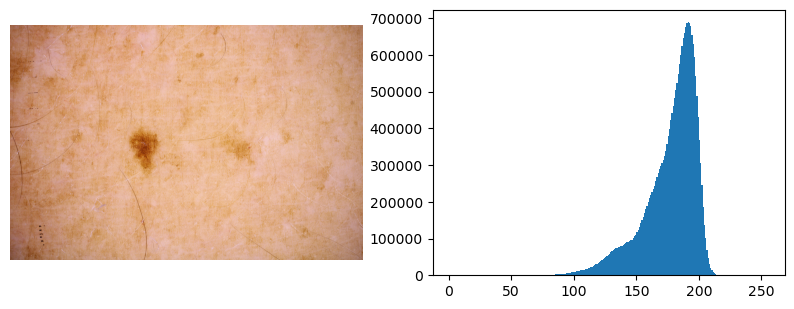

152.86686238342222


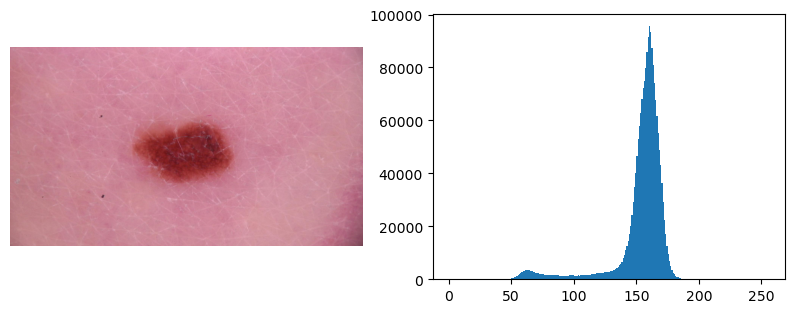

79.2456159040917


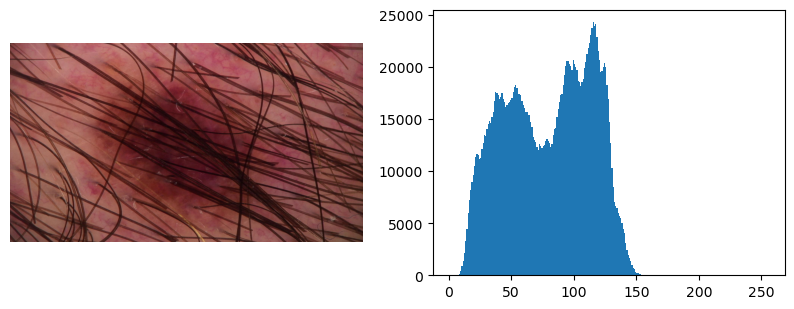

1.93800 sec


In [46]:
X_train = []


start = time.time()
for i in range(3):
    img = cv2.imread(img_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize = (10,20))
    plt.subplot(5, 2, (i*2)+1)
    plt.axis('off') # 창에있는 x축 y축 제거
    plt.imshow(img)
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    print(img.ravel().mean())
    plt.subplot(5, 2, (i*2)+2)
    plt.hist(img.ravel(), 256, [0,256]); 
    plt.show()
    #img = tf.image.resize(img, (128,128))
    #img = np.array(img).astype('float64')
    #X_train.append(img / 255)

end = time.time()
print(f"{end - start:.5f} sec")

In [47]:
dir_many = ['ISIC_0068279','ISIC_0109703', 'ISIC_0181445', 'ISIC_0333051', 'ISIC_0351188', 'ISIC_0374231', 'ISIC_0481702', 'ISIC_0623642', 'ISIC_0728413']
dir_soso = ['ISIC_0080817', 'ISIC_0083035', 'ISIC_0163639', 'ISIC_0194914', 'ISIC_0356904', 'ISIC_0385609', 'ISIC_0484171', 'ISIC_0640806', 'ISIC_0654636']
dir_little = ['ISIC_0074311', 'ISIC_0085718', 'ISIC_0165903', 'ISIC_0199116', 'ISIC_0365410', 'ISIC_0404479', 'ISIC_0507189', 'ISIC_0655635', 'ISIC_0678569']

In [48]:
dir_2 = (r'D:\Data\Final_Project\jpeg\train\\')

In [49]:
many_path = []
soso_path = []
none_path = []

for i in range(9):
    many_path.append(dir_2 + dir_many[i] + '.jpg')
    soso_path.append(dir_2 + dir_soso[i] + '.jpg')
    none_path.append(dir_2 + dir_little[i] + '.jpg')

환부에 털이 매우 많은 사진


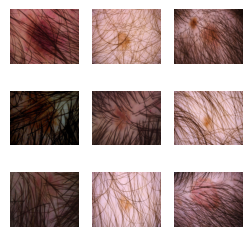

평균 Hist 값 : 101.78871527777777
----------------------------------------
환부에 털이 적당히 있는 사진


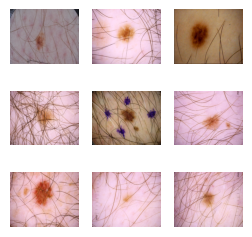

평균 Hist 값 : 169.04278510802467
----------------------------------------
환부에 털이 없는 사진


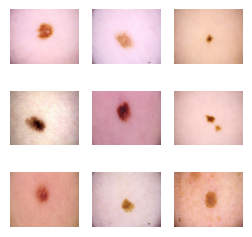

평균 Hist 값 : 195.52528356481483


In [50]:
many_ = []
soso_ = []
none_ = []

print('환부에 털이 매우 많은 사진')
plt.figure(figsize = (3,3))

for i in range(9):
    img_many = cv2.imread(many_path[i])
    img_many = cv2.cvtColor(img_many, cv2.COLOR_BGR2RGB)
    img_many = cv2.resize(img_many, (600,480))
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img_many)
    plt.axis('off') # 창에있는 x축 y축 제거
    
    img_many = cv2.cvtColor(img_many, cv2.COLOR_RGB2GRAY)
    many_.append(img_many.ravel().mean())
    
plt.show()
print('평균 Hist 값 : %s' %(np.mean(many_)))
print('-'*40)
print('환부에 털이 적당히 있는 사진')
plt.figure(figsize = (3,3))

for i in range(9):
    img_soso = cv2.imread(soso_path[i])
    img_soso = cv2.cvtColor(img_soso, cv2.COLOR_BGR2RGB)
    img_soso = cv2.resize(img_soso, (600,480))
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img_soso)
    plt.axis('off') 
    
    img_soso = cv2.cvtColor(img_soso, cv2.COLOR_RGB2GRAY)
    soso_.append(img_soso.ravel().mean())
    
plt.show()
print('평균 Hist 값 : %s' %(np.mean(soso_)))
print('-'*40)
print('환부에 털이 없는 사진')
plt.figure(figsize = (3,3))

for i in range(9):
    img_none = cv2.imread(none_path[i])
    img_none = cv2.cvtColor(img_none, cv2.COLOR_BGR2RGB)
    img_none = cv2.resize(img_none, (600,480))
    
    plt.subplot(3, 3, i+1)
    plt.imshow(img_none)
    plt.axis('off') 
    
    img_none = cv2.cvtColor(img_none, cv2.COLOR_RGB2GRAY)
    none_.append(img_none.ravel().mean())
    
plt.show()
print('평균 Hist 값 : %s' %(np.mean(none_)))

x < 105

drop

105 <  x < 180

털 제거 알고리즘 

256 리사이징

 180 < x

256 리사이징

In [51]:
X_train = []
drop_list = []

start = time.time()
for i in range(len(img_path)):
    img = cv2.imread(img_path[i])
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hist_mean = img_gray.ravel().mean()
    img_resize = cv2.resize(img, (128,128))
    #print(hist_mean)
    
    if hist_mean < 105 :
        drop_list.append(img_path[i].split('\\')[5].split('.')[0])
        print(img_path[i].split('\\')[5].split('.')[0])
        print('Drop')
        
    elif hist_mean > 105 and hist_mean < 180:
        grayScale = cv2.cvtColor(img_resize, cv2.COLOR_BGR2GRAY)
        #kernel for morphological filtering
        kernel = cv2.getStructuringElement(1,(17,17))
        #perform blackhat filtering on the grayscale image to find hair contours
        blackhat = cv2.morphologyEx(grayScale,cv2.MORPH_BLACKHAT,kernel)
        #intensify the hair contours in preparation for the inpainting
        ret, threshold = cv2.threshold(blackhat, 10,255, cv2.THRESH_BINARY)
        #inpaint the original image depending on the mask
        final_image = cv2.inpaint(img_resize,threshold, 1, cv2.INPAINT_TELEA)
        final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
        
        final_image = np.array(final_image).astype('float32')
        X_train.append(final_image / 255)
        print(img_path[i].split('\\')[5].split('.')[0])
        print('Converting Complte')
        
    else:
        final_image = np.array(img_resize).astype('float32')
        X_train.append(final_image / 255)
        print(img_path[i].split('\\')[5].split('.')[0])
        print('Resizing Complete')
    
    print(i)

print(len(drop_list))
print(len(X_train))
end = time.time()
print(f"{end - start:.5f} sec")

ISIC_0015719
Converting Complte
0
ISIC_0052212
Converting Complte
1
ISIC_0068279
Drop
2
ISIC_0074268
Resizing Complete
3
ISIC_0074311
Resizing Complete
4
ISIC_0074542
Resizing Complete
5
ISIC_0075663
Converting Complte
6
ISIC_0075914
Resizing Complete
7
ISIC_0076262
Resizing Complete
8
ISIC_0076545
Converting Complte
9
ISIC_0076742
Resizing Complete
10
ISIC_0076995
Converting Complte
11
ISIC_0077472
Resizing Complete
12
ISIC_0077735
Resizing Complete
13
ISIC_0078703
Resizing Complete
14
ISIC_0078712
Converting Complte
15
ISIC_0079038
Converting Complte
16
ISIC_0080512
Resizing Complete
17
ISIC_0080752
Resizing Complete
18
ISIC_0080817
Converting Complte
19
ISIC_0081956
Converting Complte
20
ISIC_0082348
Resizing Complete
21
ISIC_0082543
Resizing Complete
22
ISIC_0082934
Converting Complte
23
ISIC_0083035
Resizing Complete
24
ISIC_0084086
Converting Complte
25
ISIC_0084270
Converting Complte
26
ISIC_0084395
Converting Complte
27
ISIC_0085172
Resizing Complete
28
ISIC_0085718
Resizing Co

ISIC_0189336
Resizing Complete
239
ISIC_0189694
Converting Complte
240
ISIC_0189837
Resizing Complete
241
ISIC_0190308
Converting Complte
242
ISIC_0190725
Converting Complte
243
ISIC_0190870
Converting Complte
244
ISIC_0191366
Resizing Complete
245
ISIC_0191734
Resizing Complete
246
ISIC_0191871
Converting Complte
247
ISIC_0192419
Resizing Complete
248
ISIC_0192490
Resizing Complete
249
ISIC_0192596
Resizing Complete
250
ISIC_0192701
Resizing Complete
251
ISIC_0192893
Converting Complte
252
ISIC_0193456
Resizing Complete
253
ISIC_0193785
Resizing Complete
254
ISIC_0193907
Converting Complte
255
ISIC_0193920
Resizing Complete
256
ISIC_0194550
Converting Complte
257
ISIC_0194914
Converting Complte
258
ISIC_0195078
Resizing Complete
259
ISIC_0195699
Resizing Complete
260
ISIC_0195972
Converting Complte
261
ISIC_0196273
Resizing Complete
262
ISIC_0196399
Converting Complte
263
ISIC_0196403
Converting Complte
264
ISIC_0196502
Converting Complte
265
ISIC_0196559
Resizing Complete
266
ISIC_01

ISIC_0250455
Converting Complte
473
ISIC_0250839
Converting Complte
474
ISIC_0250842
Resizing Complete
475
ISIC_0251149
Converting Complte
476
ISIC_0252448
Drop
477
ISIC_0252649
Converting Complte
478
ISIC_0253178
Converting Complte
479
ISIC_0253367
Resizing Complete
480
ISIC_0253516
Converting Complte
481
ISIC_0253871
Converting Complte
482
ISIC_0254158
Converting Complte
483
ISIC_0254447
Converting Complte
484
ISIC_0254517
Converting Complte
485
ISIC_0254686
Converting Complte
486
ISIC_0254698
Converting Complte
487
ISIC_0255205
Resizing Complete
488
ISIC_0255508
Converting Complte
489
ISIC_0255796
Resizing Complete
490
ISIC_0255843
Converting Complte
491
ISIC_0255914
Converting Complte
492
ISIC_0255997
Converting Complte
493
ISIC_0256715
Resizing Complete
494
ISIC_0256926
Converting Complte
495
ISIC_0257447
Converting Complte
496
ISIC_0257755
Resizing Complete
497
ISIC_0258061
Drop
498
ISIC_0258065
Resizing Complete
499
ISIC_0258806
Resizing Complete
500
ISIC_0258821
Resizing Comple

ISIC_0314462
Drop
706
ISIC_0315525
Resizing Complete
707
ISIC_0315631
Resizing Complete
708
ISIC_0316025
Converting Complte
709
ISIC_0316484
Resizing Complete
710
ISIC_0316656
Converting Complte
711
ISIC_0316668
Converting Complte
712
ISIC_0316788
Resizing Complete
713
ISIC_0316826
Converting Complte
714
ISIC_0316933
Converting Complte
715
ISIC_0317589
Converting Complte
716
ISIC_0317682
Converting Complte
717
ISIC_0318642
Resizing Complete
718
ISIC_0319410
Resizing Complete
719
ISIC_0319491
Resizing Complete
720
ISIC_0319715
Converting Complte
721
ISIC_0319928
Resizing Complete
722
ISIC_0320013
Resizing Complete
723
ISIC_0320227
Resizing Complete
724
ISIC_0320334
Resizing Complete
725
ISIC_0321114
Converting Complte
726
ISIC_0322004
Resizing Complete
727
ISIC_0322340
Converting Complte
728
ISIC_0322371
Converting Complte
729
ISIC_0322637
Resizing Complete
730
ISIC_0322818
Converting Complte
731
ISIC_0322967
Resizing Complete
732
ISIC_0323624
Converting Complte
733
ISIC_0323792
Convert

ISIC_0387297
Resizing Complete
943
ISIC_0388873
Converting Complte
944
ISIC_0389629
Resizing Complete
945
ISIC_0389955
Converting Complte
946
ISIC_0390920
Converting Complte
947
ISIC_0391694
Resizing Complete
948
ISIC_0391767
Resizing Complete
949
ISIC_0392105
Converting Complte
950
ISIC_0392334
Converting Complte
951
ISIC_0392759
Converting Complte
952
ISIC_0392942
Converting Complte
953
ISIC_0392966
Converting Complte
954
ISIC_0393088
Converting Complte
955
ISIC_0394030
Converting Complte
956
ISIC_0394140
Converting Complte
957
ISIC_0394157
Resizing Complete
958
ISIC_0394664
Converting Complte
959
ISIC_0395456
Drop
960
ISIC_0395933
Converting Complte
961
ISIC_0396184
Resizing Complete
962
ISIC_0396641
Converting Complte
963
ISIC_0396865
Converting Complte
964
ISIC_0397464
Converting Complte
965
ISIC_0397577
Resizing Complete
966
ISIC_0397620
Resizing Complete
967
ISIC_0397658
Converting Complte
968
ISIC_0398005
Converting Complte
969
ISIC_0398069
Converting Complte
970
ISIC_0398140
D

ISIC_0454594
Converting Complte
1170
ISIC_0455262
Resizing Complete
1171
ISIC_0455456
Drop
1172
ISIC_0455625
Converting Complte
1173
ISIC_0455687
Resizing Complete
1174
ISIC_0455743
Converting Complte
1175
ISIC_0455800
Resizing Complete
1176
ISIC_0456090
Converting Complte
1177
ISIC_0456901
Drop
1178
ISIC_0456905
Converting Complte
1179
ISIC_0457030
Drop
1180
ISIC_0457235
Resizing Complete
1181
ISIC_0457385
Converting Complte
1182
ISIC_0457868
Converting Complte
1183
ISIC_0458106
Drop
1184
ISIC_0458240
Resizing Complete
1185
ISIC_0458561
Converting Complte
1186
ISIC_0459035
Converting Complte
1187
ISIC_0459155
Converting Complte
1188
ISIC_0460240
Resizing Complete
1189
ISIC_0460608
Resizing Complete
1190
ISIC_0460815
Converting Complte
1191
ISIC_0460833
Converting Complte
1192
ISIC_0461085
Resizing Complete
1193
ISIC_0461128
Converting Complte
1194
ISIC_0461550
Converting Complte
1195
ISIC_0461634
Resizing Complete
1196
ISIC_0461706
Converting Complte
1197
ISIC_0462956
Drop
1198
ISIC_0

ISIC_0523771
Resizing Complete
1403
ISIC_0524046
Converting Complte
1404
ISIC_0524477
Resizing Complete
1405
ISIC_0524863
Converting Complte
1406
ISIC_0525318
Converting Complte
1407
ISIC_0525376
Resizing Complete
1408
ISIC_0525554
Resizing Complete
1409
ISIC_0525687
Resizing Complete
1410
ISIC_0526291
Resizing Complete
1411
ISIC_0526705
Resizing Complete
1412
ISIC_0526861
Converting Complte
1413
ISIC_0526904
Resizing Complete
1414
ISIC_0526973
Resizing Complete
1415
ISIC_0527088
Resizing Complete
1416
ISIC_0527166
Resizing Complete
1417
ISIC_0527170
Converting Complte
1418
ISIC_0527350
Resizing Complete
1419
ISIC_0527593
Resizing Complete
1420
ISIC_0527870
Converting Complte
1421
ISIC_0528044
Resizing Complete
1422
ISIC_0528380
Resizing Complete
1423
ISIC_0528495
Converting Complte
1424
ISIC_0528791
Resizing Complete
1425
ISIC_0529262
Resizing Complete
1426
ISIC_0529486
Converting Complte
1427
ISIC_0529518
Converting Complte
1428
ISIC_0529784
Converting Complte
1429
ISIC_0530054
Conve

ISIC_0593591
Resizing Complete
1632
ISIC_0593756
Converting Complte
1633
ISIC_0594068
Converting Complte
1634
ISIC_0594289
Converting Complte
1635
ISIC_0594534
Resizing Complete
1636
ISIC_0594695
Resizing Complete
1637
ISIC_0595018
Resizing Complete
1638
ISIC_0595080
Converting Complte
1639
ISIC_0595199
Converting Complte
1640
ISIC_0595472
Resizing Complete
1641
ISIC_0595676
Converting Complte
1642
ISIC_0596043
Resizing Complete
1643
ISIC_0596089
Resizing Complete
1644
ISIC_0596524
Converting Complte
1645
ISIC_0596607
Converting Complte
1646
ISIC_0596942
Resizing Complete
1647
ISIC_0597012
Resizing Complete
1648
ISIC_0597158
Resizing Complete
1649
ISIC_0597414
Converting Complte
1650
ISIC_0597581
Converting Complte
1651
ISIC_0599047
Resizing Complete
1652
ISIC_0599605
Converting Complte
1653
ISIC_0599755
Resizing Complete
1654
ISIC_0599918
Converting Complte
1655
ISIC_0600084
Converting Complte
1656
ISIC_0600789
Resizing Complete
1657
ISIC_0600866
Resizing Complete
1658
ISIC_0601107
Co

ISIC_0658225
Resizing Complete
1859
ISIC_0658963
Resizing Complete
1860
ISIC_0659153
Resizing Complete
1861
ISIC_0659400
Converting Complte
1862
ISIC_0659540
Resizing Complete
1863
ISIC_0659600
Converting Complte
1864
ISIC_0659878
Resizing Complete
1865
ISIC_0660331
Converting Complte
1866
ISIC_0660449
Converting Complte
1867
ISIC_0660770
Resizing Complete
1868
ISIC_0661120
Resizing Complete
1869
ISIC_0661284
Converting Complte
1870
ISIC_0661926
Converting Complte
1871
ISIC_0662000
Converting Complte
1872
ISIC_0662183
Resizing Complete
1873
ISIC_0662867
Converting Complte
1874
ISIC_0662911
Converting Complte
1875
ISIC_0663446
Converting Complte
1876
ISIC_0663588
Resizing Complete
1877
ISIC_0663631
Converting Complte
1878
ISIC_0663824
Resizing Complete
1879
ISIC_0663941
Resizing Complete
1880
ISIC_0664031
Converting Complte
1881
ISIC_0664113
Resizing Complete
1882
ISIC_0664115
Resizing Complete
1883
ISIC_0664452
Resizing Complete
1884
ISIC_0666481
Converting Complte
1885
ISIC_0666591
Re

ISIC_0723083
Resizing Complete
2088
ISIC_0723112
Converting Complte
2089
ISIC_0723505
Converting Complte
2090
ISIC_0723595
Resizing Complete
2091
ISIC_0723780
Resizing Complete
2092
ISIC_0723895
Resizing Complete
2093
ISIC_0725711
Converting Complte
2094
ISIC_0725958
Resizing Complete
2095
ISIC_0726170
Resizing Complete
2096
ISIC_0726626
Converting Complte
2097
ISIC_0727016
Converting Complte
2098
ISIC_0727322
Converting Complte
2099
ISIC_0727425
Converting Complte
2100
ISIC_0727489
Resizing Complete
2101
ISIC_0728291
Resizing Complete
2102
ISIC_0728350
Converting Complte
2103
ISIC_0728413
Drop
2104
ISIC_0728868
Resizing Complete
2105
ISIC_0728967
Converting Complte
2106
ISIC_0729264
Converting Complte
2107
ISIC_0732102
Converting Complte
2108
ISIC_0732124
Resizing Complete
2109
ISIC_0732375
Resizing Complete
2110
ISIC_0732389
Converting Complte
2111
ISIC_0732626
Converting Complte
2112
ISIC_0732636
Converting Complte
2113
ISIC_0732688
Resizing Complete
2114
ISIC_0733140
Resizing Compl

ISIC_0791761
Resizing Complete
2318
ISIC_0792589
Resizing Complete
2319
ISIC_0792805
Resizing Complete
2320
ISIC_0792879
Resizing Complete
2321
ISIC_0793465
Drop
2322
ISIC_0793501
Converting Complte
2323
ISIC_0794216
Resizing Complete
2324
ISIC_0794912
Resizing Complete
2325
ISIC_0795514
Converting Complte
2326
ISIC_0795802
Resizing Complete
2327
ISIC_0796325
Converting Complte
2328
ISIC_0796345
Converting Complte
2329
ISIC_0796372
Resizing Complete
2330
ISIC_0796973
Converting Complte
2331
ISIC_0797473
Drop
2332
ISIC_0797476
Resizing Complete
2333
ISIC_0797931
Converting Complte
2334
ISIC_0798355
Converting Complte
2335
ISIC_0798837
Converting Complte
2336
ISIC_0799347
Converting Complte
2337
ISIC_0799535
Resizing Complete
2338
ISIC_0800069
Converting Complte
2339
ISIC_0800079
Resizing Complete
2340
ISIC_0800269
Resizing Complete
2341
ISIC_0800628
Resizing Complete
2342
ISIC_0800882
Converting Complte
2343
ISIC_0801281
Converting Complte
2344
ISIC_0801563
Converting Complte
2345
ISIC_

ISIC_0865521
Resizing Complete
2549
ISIC_0865887
Resizing Complete
2550
ISIC_0867090
Converting Complte
2551
ISIC_0867357
Converting Complte
2552
ISIC_0867503
Converting Complte
2553
ISIC_0867709
Resizing Complete
2554
ISIC_0868636
Converting Complte
2555
ISIC_0868656
Resizing Complete
2556
ISIC_0868876
Resizing Complete
2557
ISIC_0869142
Converting Complte
2558
ISIC_0869231
Resizing Complete
2559
ISIC_0869745
Converting Complte
2560
ISIC_0870696
Resizing Complete
2561
ISIC_0870751
Resizing Complete
2562
ISIC_0871035
Resizing Complete
2563
ISIC_0871833
Resizing Complete
2564
ISIC_0871853
Resizing Complete
2565
ISIC_0872145
Converting Complte
2566
ISIC_0872350
Resizing Complete
2567
ISIC_0872409
Resizing Complete
2568
ISIC_0872420
Resizing Complete
2569
ISIC_0872477
Resizing Complete
2570
ISIC_0872821
Resizing Complete
2571
ISIC_0872845
Resizing Complete
2572
ISIC_0873044
Resizing Complete
2573
ISIC_0873114
Resizing Complete
2574
ISIC_0873358
Resizing Complete
2575
ISIC_0873568
Converti

ISIC_0929517
Converting Complte
2776
ISIC_0930135
Resizing Complete
2777
ISIC_0930417
Converting Complte
2778
ISIC_0930924
Converting Complte
2779
ISIC_0930944
Resizing Complete
2780
ISIC_0930980
Converting Complte
2781
ISIC_0931218
Resizing Complete
2782
ISIC_0931454
Resizing Complete
2783
ISIC_0931725
Converting Complte
2784
ISIC_0932428
Resizing Complete
2785
ISIC_0932862
Converting Complte
2786
ISIC_0933075
Converting Complte
2787
ISIC_0933647
Converting Complte
2788
ISIC_0933689
Resizing Complete
2789
ISIC_0933821
Converting Complte
2790
ISIC_0934204
Resizing Complete
2791
ISIC_0934223
Converting Complte
2792
ISIC_0934367
Resizing Complete
2793
ISIC_0934368
Resizing Complete
2794
ISIC_0935859
Converting Complte
2795
ISIC_0936865
Converting Complte
2796
ISIC_0937257
Resizing Complete
2797
ISIC_0937261
Converting Complte
2798
ISIC_0937346
Drop
2799
ISIC_0937378
Converting Complte
2800
ISIC_0938463
Converting Complte
2801
ISIC_0938864
Resizing Complete
2802
ISIC_0938927
Converting Co

ISIC_1001731
Converting Complte
3004
ISIC_1002107
Converting Complte
3005
ISIC_1002473
Converting Complte
3006
ISIC_1002979
Resizing Complete
3007
ISIC_1003459
Resizing Complete
3008
ISIC_1003701
Resizing Complete
3009
ISIC_1003703
Resizing Complete
3010
ISIC_1004225
Converting Complte
3011
ISIC_1004265
Converting Complte
3012
ISIC_1004416
Resizing Complete
3013
ISIC_1005038
Converting Complte
3014
ISIC_1005048
Resizing Complete
3015
ISIC_1005544
Resizing Complete
3016
ISIC_1005597
Converting Complte
3017
ISIC_1005683
Drop
3018
ISIC_1005745
Converting Complte
3019
ISIC_1006632
Resizing Complete
3020
ISIC_1006874
Resizing Complete
3021
ISIC_1007014
Converting Complte
3022
ISIC_1007608
Converting Complte
3023
ISIC_1007838
Converting Complte
3024
ISIC_1008321
Converting Complte
3025
ISIC_1008609
Resizing Complete
3026
ISIC_1009042
Converting Complte
3027
ISIC_1009273
Resizing Complete
3028
ISIC_1009378
Converting Complte
3029
ISIC_1009958
Converting Complte
3030
ISIC_1010416
Resizing Comp

ISIC_1076091
Resizing Complete
3232
ISIC_1076339
Resizing Complete
3233
ISIC_1076474
Resizing Complete
3234
ISIC_1076554
Converting Complte
3235
ISIC_1077375
Resizing Complete
3236
ISIC_1077822
Resizing Complete
3237
ISIC_1077911
Converting Complte
3238
ISIC_1078527
Converting Complte
3239
ISIC_1078563
Converting Complte
3240
ISIC_1078707
Converting Complte
3241
ISIC_1078823
Converting Complte
3242
ISIC_1078854
Resizing Complete
3243
ISIC_1079069
Converting Complte
3244
ISIC_1079829
Converting Complte
3245
ISIC_1080640
Resizing Complete
3246
ISIC_1080647
Converting Complte
3247
ISIC_1081051
Converting Complte
3248
ISIC_1081430
Converting Complte
3249
ISIC_1081510
Resizing Complete
3250
ISIC_1081635
Resizing Complete
3251
ISIC_1082020
Converting Complte
3252
ISIC_1082748
Converting Complte
3253
ISIC_1083365
Converting Complte
3254
ISIC_1083392
Converting Complte
3255
ISIC_1083466
Resizing Complete
3256
ISIC_1083584
Converting Complte
3257
ISIC_1083668
Converting Complte
3258
ISIC_108367

ISIC_1148874
Resizing Complete
3461
ISIC_1148932
Converting Complte
3462
ISIC_1149061
Resizing Complete
3463
ISIC_1149469
Converting Complte
3464
ISIC_1149693
Converting Complte
3465
ISIC_1150399
Resizing Complete
3466
ISIC_1150482
Resizing Complete
3467
ISIC_1151269
Converting Complte
3468
ISIC_1151651
Converting Complte
3469
ISIC_1151910
Converting Complte
3470
ISIC_1151929
Converting Complte
3471
ISIC_1152051
Converting Complte
3472
ISIC_1152559
Resizing Complete
3473
ISIC_1152648
Resizing Complete
3474
ISIC_1152737
Converting Complte
3475
ISIC_1153069
Drop
3476
ISIC_1153106
Resizing Complete
3477
ISIC_1153335
Resizing Complete
3478
ISIC_1153940
Resizing Complete
3479
ISIC_1154064
Resizing Complete
3480
ISIC_1154072
Resizing Complete
3481
ISIC_1154109
Resizing Complete
3482
ISIC_1154756
Converting Complte
3483
ISIC_1155407
Resizing Complete
3484
ISIC_1155483
Converting Complte
3485
ISIC_1155612
Converting Complte
3486
ISIC_1155782
Resizing Complete
3487
ISIC_1156157
Converting Compl

ISIC_1210338
Converting Complte
3689
ISIC_1210565
Converting Complte
3690
ISIC_1210620
Converting Complte
3691
ISIC_1210893
Resizing Complete
3692
ISIC_1211024
Converting Complte
3693
ISIC_1211506
Resizing Complete
3694
ISIC_1212555
Resizing Complete
3695
ISIC_1212587
Converting Complte
3696
ISIC_1213303
Converting Complte
3697
ISIC_1213493
Resizing Complete
3698
ISIC_1215482
Resizing Complete
3699
ISIC_1215640
Resizing Complete
3700
ISIC_1216139
Converting Complte
3701
ISIC_1216201
Resizing Complete
3702
ISIC_1216381
Converting Complte
3703
ISIC_1216698
Resizing Complete
3704
ISIC_1216822
Resizing Complete
3705
ISIC_1217314
Converting Complte
3706
ISIC_1217717
Resizing Complete
3707
ISIC_1218358
Converting Complte
3708
ISIC_1218931
Resizing Complete
3709
ISIC_1219154
Resizing Complete
3710
ISIC_1219427
Converting Complte
3711
ISIC_1219783
Converting Complte
3712
ISIC_1219894
Resizing Complete
3713
ISIC_1220029
Resizing Complete
3714
ISIC_1220154
Resizing Complete
3715
ISIC_1221361
Con

ISIC_1281431
Converting Complte
3919
ISIC_1281742
Resizing Complete
3920
ISIC_1282063
Resizing Complete
3921
ISIC_1282857
Converting Complte
3922
ISIC_1282922
Converting Complte
3923
ISIC_1283320
Drop
3924
ISIC_1283518
Converting Complte
3925
ISIC_1283950
Resizing Complete
3926
ISIC_1284089
Converting Complte
3927
ISIC_1284397
Converting Complte
3928
ISIC_1284496
Resizing Complete
3929
ISIC_1285203
Resizing Complete
3930
ISIC_1285870
Resizing Complete
3931
ISIC_1285997
Converting Complte
3932
ISIC_1286298
Converting Complte
3933
ISIC_1286857
Converting Complte
3934
ISIC_1287050
Resizing Complete
3935
ISIC_1287173
Resizing Complete
3936
ISIC_1287370
Converting Complte
3937
ISIC_1287495
Resizing Complete
3938
ISIC_1288751
Converting Complte
3939
ISIC_1288895
Converting Complte
3940
ISIC_1289608
Resizing Complete
3941
ISIC_1289942
Converting Complte
3942
ISIC_1290184
Resizing Complete
3943
ISIC_1290295
Resizing Complete
3944
ISIC_1290366
Converting Complte
3945
ISIC_1290465
Resizing Compl

ISIC_1352631
Resizing Complete
4149
ISIC_1352841
Converting Complte
4150
ISIC_1352911
Converting Complte
4151
ISIC_1353051
Converting Complte
4152
ISIC_1353094
Converting Complte
4153
ISIC_1353530
Converting Complte
4154
ISIC_1353532
Resizing Complete
4155
ISIC_1353653
Converting Complte
4156
ISIC_1353668
Converting Complte
4157
ISIC_1353949
Converting Complte
4158
ISIC_1354862
Resizing Complete
4159
ISIC_1355104
Converting Complte
4160
ISIC_1355214
Converting Complte
4161
ISIC_1355286
Converting Complte
4162
ISIC_1355494
Converting Complte
4163
ISIC_1355722
Resizing Complete
4164
ISIC_1355890
Drop
4165
ISIC_1355907
Converting Complte
4166
ISIC_1356715
Resizing Complete
4167
ISIC_1356907
Converting Complte
4168
ISIC_1356945
Resizing Complete
4169
ISIC_1357166
Resizing Complete
4170
ISIC_1357175
Converting Complte
4171
ISIC_1357836
Drop
4172
ISIC_1358147
Converting Complte
4173
ISIC_1358348
Converting Complte
4174
ISIC_1358441
Converting Complte
4175
ISIC_1358527
Converting Complte
4176

ISIC_1418166
Resizing Complete
4377
ISIC_1418304
Converting Complte
4378
ISIC_1418391
Converting Complte
4379
ISIC_1418788
Resizing Complete
4380
ISIC_1418941
Resizing Complete
4381
ISIC_1419399
Converting Complte
4382
ISIC_1419510
Converting Complte
4383
ISIC_1419980
Converting Complte
4384
ISIC_1420201
Converting Complte
4385
ISIC_1420555
Resizing Complete
4386
ISIC_1421074
Resizing Complete
4387
ISIC_1421568
Converting Complte
4388
ISIC_1421644
Converting Complte
4389
ISIC_1422217
Resizing Complete
4390
ISIC_1422429
Converting Complte
4391
ISIC_1422973
Resizing Complete
4392
ISIC_1423497
Converting Complte
4393
ISIC_1424529
Resizing Complete
4394
ISIC_1424655
Converting Complte
4395
ISIC_1425404
Resizing Complete
4396
ISIC_1425958
Resizing Complete
4397
ISIC_1425961
Resizing Complete
4398
ISIC_1426279
Converting Complte
4399
ISIC_1426331
Resizing Complete
4400
ISIC_1426781
Resizing Complete
4401
ISIC_1426974
Converting Complte
4402
ISIC_1427744
Resizing Complete
4403
ISIC_1428310
Re

ISIC_1484525
Resizing Complete
4605
ISIC_1484621
Converting Complte
4606
ISIC_1484659
Converting Complte
4607
ISIC_1484841
Resizing Complete
4608
ISIC_1485132
Resizing Complete
4609
ISIC_1485908
Converting Complte
4610
ISIC_1485969
Resizing Complete
4611
ISIC_1486076
Resizing Complete
4612
ISIC_1486154
Converting Complte
4613
ISIC_1486209
Converting Complte
4614
ISIC_1486589
Resizing Complete
4615
ISIC_1487253
Converting Complte
4616
ISIC_1487443
Resizing Complete
4617
ISIC_1487510
Converting Complte
4618
ISIC_1487601
Resizing Complete
4619
ISIC_1487640
Converting Complte
4620
ISIC_1487670
Resizing Complete
4621
ISIC_1487856
Converting Complte
4622
ISIC_1488047
Resizing Complete
4623
ISIC_1488127
Converting Complte
4624
ISIC_1488569
Resizing Complete
4625
ISIC_1488598
Converting Complte
4626
ISIC_1488722
Resizing Complete
4627
ISIC_1488725
Resizing Complete
4628
ISIC_1488727
Resizing Complete
4629
ISIC_1489699
Resizing Complete
4630
ISIC_1489934
Resizing Complete
4631
ISIC_1490117
Conv

ISIC_1553853
Converting Complte
4838
ISIC_1554131
Converting Complte
4839
ISIC_1554843
Resizing Complete
4840
ISIC_1554893
Resizing Complete
4841
ISIC_1554992
Converting Complte
4842
ISIC_1555147
Converting Complte
4843
ISIC_1556209
Converting Complte
4844
ISIC_1556765
Converting Complte
4845
ISIC_1556906
Converting Complte
4846
ISIC_1557225
Resizing Complete
4847
ISIC_1557301
Resizing Complete
4848
ISIC_1558639
Converting Complte
4849
ISIC_1558731
Resizing Complete
4850
ISIC_1559267
Resizing Complete
4851
ISIC_1559422
Resizing Complete
4852
ISIC_1560026
Resizing Complete
4853
ISIC_1560272
Converting Complte
4854
ISIC_1560455
Resizing Complete
4855
ISIC_1560888
Converting Complte
4856
ISIC_1561068
Converting Complte
4857
ISIC_1561091
Converting Complte
4858
ISIC_1561177
Converting Complte
4859
ISIC_1561369
Converting Complte
4860
ISIC_1562512
Converting Complte
4861
ISIC_1562894
Converting Complte
4862
ISIC_1564127
Converting Complte
4863
ISIC_1564564
Converting Complte
4864
ISIC_15647

ISIC_1621431
Resizing Complete
5066
ISIC_1621479
Resizing Complete
5067
ISIC_1621961
Resizing Complete
5068
ISIC_1624520
Converting Complte
5069
ISIC_1624873
Converting Complte
5070
ISIC_1625064
Drop
5071
ISIC_1625688
Resizing Complete
5072
ISIC_1626033
Resizing Complete
5073
ISIC_1626069
Resizing Complete
5074
ISIC_1626359
Resizing Complete
5075
ISIC_1626814
Resizing Complete
5076
ISIC_1626834
Resizing Complete
5077
ISIC_1626843
Resizing Complete
5078
ISIC_1627019
Resizing Complete
5079
ISIC_1627111
Converting Complte
5080
ISIC_1627241
Drop
5081
ISIC_1627328
Resizing Complete
5082
ISIC_1627427
Converting Complte
5083
ISIC_1627900
Converting Complte
5084
ISIC_1628425
Resizing Complete
5085
ISIC_1628539
Converting Complte
5086
ISIC_1628853
Resizing Complete
5087
ISIC_1629433
Resizing Complete
5088
ISIC_1629539
Converting Complte
5089
ISIC_1630209
Converting Complte
5090
ISIC_1630301
Converting Complte
5091
ISIC_1630515
Converting Complte
5092
ISIC_1631050
Converting Complte
5093
ISIC_16

ISIC_1684067
Resizing Complete
5298
ISIC_1684107
Converting Complte
5299
ISIC_1684127
Converting Complte
5300
ISIC_1684266
Resizing Complete
5301
ISIC_1684603
Converting Complte
5302
ISIC_1684829
Resizing Complete
5303
ISIC_1684948
Converting Complte
5304
ISIC_1685257
Converting Complte
5305
ISIC_1685333
Converting Complte
5306
ISIC_1685653
Resizing Complete
5307
ISIC_1685833
Converting Complte
5308
ISIC_1686113
Converting Complte
5309
ISIC_1686254
Converting Complte
5310
ISIC_1686556
Converting Complte
5311
ISIC_1687004
Converting Complte
5312
ISIC_1687278
Resizing Complete
5313
ISIC_1687478
Resizing Complete
5314
ISIC_1687584
Resizing Complete
5315
ISIC_1688150
Converting Complte
5316
ISIC_1688160
Converting Complte
5317
ISIC_1688271
Resizing Complete
5318
ISIC_1688301
Resizing Complete
5319
ISIC_1688776
Converting Complte
5320
ISIC_1689309
Converting Complte
5321
ISIC_1689678
Resizing Complete
5322
ISIC_1689686
Resizing Complete
5323
ISIC_1690499
Converting Complte
5324
ISIC_1690665

ISIC_1750621
Drop
5525
ISIC_1750674
Resizing Complete
5526
ISIC_1752228
Converting Complte
5527
ISIC_1752306
Resizing Complete
5528
ISIC_1752589
Resizing Complete
5529
ISIC_1752665
Resizing Complete
5530
ISIC_1752943
Converting Complte
5531
ISIC_1753040
Resizing Complete
5532
ISIC_1753360
Converting Complte
5533
ISIC_1753391
Converting Complte
5534
ISIC_1753877
Converting Complte
5535
ISIC_1754140
Converting Complte
5536
ISIC_1754491
Drop
5537
ISIC_1755019
Converting Complte
5538
ISIC_1755832
Converting Complte
5539
ISIC_1756265
Resizing Complete
5540
ISIC_1756631
Drop
5541
ISIC_1756660
Resizing Complete
5542
ISIC_1756982
Converting Complte
5543
ISIC_1757212
Drop
5544
ISIC_1757941
Converting Complte
5545
ISIC_1758119
Resizing Complete
5546
ISIC_1758149
Resizing Complete
5547
ISIC_1758397
Converting Complte
5548
ISIC_1758558
Converting Complte
5549
ISIC_1759817
Resizing Complete
5550
ISIC_1760981
Resizing Complete
5551
ISIC_1761083
Converting Complte
5552
ISIC_1761138
Converting Complte

ISIC_1828652
Resizing Complete
5756
ISIC_1829378
Drop
5757
ISIC_1829654
Resizing Complete
5758
ISIC_1829721
Resizing Complete
5759
ISIC_1830017
Resizing Complete
5760
ISIC_1831304
Converting Complte
5761
ISIC_1831325
Resizing Complete
5762
ISIC_1831600
Converting Complte
5763
ISIC_1832110
Resizing Complete
5764
ISIC_1832582
Resizing Complete
5765
ISIC_1832586
Converting Complte
5766
ISIC_1833122
Resizing Complete
5767
ISIC_1833138
Converting Complte
5768
ISIC_1833259
Drop
5769
ISIC_1833337
Converting Complte
5770
ISIC_1833947
Converting Complte
5771
ISIC_1834367
Resizing Complete
5772
ISIC_1834416
Converting Complte
5773
ISIC_1834652
Resizing Complete
5774
ISIC_1834920
Converting Complte
5775
ISIC_1835041
Converting Complte
5776
ISIC_1835426
Resizing Complete
5777
ISIC_1835970
Converting Complte
5778
ISIC_1836352
Converting Complte
5779
ISIC_1836410
Converting Complte
5780
ISIC_1836661
Converting Complte
5781
ISIC_1836687
Converting Complte
5782
ISIC_1836914
Resizing Complete
5783
ISIC

ISIC_1891419
Resizing Complete
5982
ISIC_1891515
Converting Complte
5983
ISIC_1891539
Resizing Complete
5984
ISIC_1891677
Converting Complte
5985
ISIC_1892011
Resizing Complete
5986
ISIC_1892350
Converting Complte
5987
ISIC_1892887
Converting Complte
5988
ISIC_1893232
Converting Complte
5989
ISIC_1894087
Resizing Complete
5990
ISIC_1894133
Resizing Complete
5991
ISIC_1894141
Converting Complte
5992
ISIC_1894324
Converting Complte
5993
ISIC_1894573
Converting Complte
5994
ISIC_1894639
Converting Complte
5995
ISIC_1894676
Converting Complte
5996
ISIC_1894741
Drop
5997
ISIC_1894782
Resizing Complete
5998
ISIC_1894918
Resizing Complete
5999
ISIC_1896191
Converting Complte
6000
ISIC_1896306
Resizing Complete
6001
ISIC_1896350
Converting Complte
6002
ISIC_1896364
Converting Complte
6003
ISIC_1896477
Converting Complte
6004
ISIC_1897312
Resizing Complete
6005
ISIC_1897327
Resizing Complete
6006
ISIC_1897507
Resizing Complete
6007
ISIC_1897994
Converting Complte
6008
ISIC_1899198
Converting Co

ISIC_1958321
Converting Complte
6213
ISIC_1958612
Converting Complte
6214
ISIC_1959040
Resizing Complete
6215
ISIC_1959078
Converting Complte
6216
ISIC_1959412
Resizing Complete
6217
ISIC_1959529
Converting Complte
6218
ISIC_1959715
Converting Complte
6219
ISIC_1959939
Converting Complte
6220
ISIC_1960067
Converting Complte
6221
ISIC_1960360
Resizing Complete
6222
ISIC_1960393
Resizing Complete
6223
ISIC_1960446
Resizing Complete
6224
ISIC_1960468
Resizing Complete
6225
ISIC_1960472
Drop
6226
ISIC_1960550
Resizing Complete
6227
ISIC_1961064
Converting Complte
6228
ISIC_1961213
Converting Complte
6229
ISIC_1961412
Converting Complte
6230
ISIC_1961810
Converting Complte
6231
ISIC_1962061
Resizing Complete
6232
ISIC_1962482
Resizing Complete
6233
ISIC_1962639
Resizing Complete
6234
ISIC_1962845
Resizing Complete
6235
ISIC_1963008
Converting Complte
6236
ISIC_1963919
Converting Complte
6237
ISIC_1964157
Resizing Complete
6238
ISIC_1964243
Converting Complte
6239
ISIC_1964334
Resizing Compl

ISIC_2021413
Converting Complte
6440
ISIC_2022396
Resizing Complete
6441
ISIC_2022525
Converting Complte
6442
ISIC_2023070
Converting Complte
6443
ISIC_2023198
Resizing Complete
6444
ISIC_2023592
Converting Complte
6445
ISIC_2023594
Converting Complte
6446
ISIC_2024062
Converting Complte
6447
ISIC_2024384
Resizing Complete
6448
ISIC_2024502
Converting Complte
6449
ISIC_2025058
Converting Complte
6450
ISIC_2027392
Resizing Complete
6451
ISIC_2027490
Resizing Complete
6452
ISIC_2027582
Drop
6453
ISIC_2027628
Resizing Complete
6454
ISIC_2027705
Converting Complte
6455
ISIC_2027733
Resizing Complete
6456
ISIC_2027840
Converting Complte
6457
ISIC_2028658
Converting Complte
6458
ISIC_2029351
Resizing Complete
6459
ISIC_2029418
Converting Complte
6460
ISIC_2030101
Converting Complte
6461
ISIC_2030126
Converting Complte
6462
ISIC_2030479
Resizing Complete
6463
ISIC_2030997
Resizing Complete
6464
ISIC_2031177
Resizing Complete
6465
ISIC_2031252
Resizing Complete
6466
ISIC_2031360
Resizing Compl

ISIC_2092968
Resizing Complete
6667
ISIC_2093167
Converting Complte
6668
ISIC_2093476
Resizing Complete
6669
ISIC_2093604
Converting Complte
6670
ISIC_2093777
Resizing Complete
6671
ISIC_2093988
Converting Complte
6672
ISIC_2094064
Converting Complte
6673
ISIC_2094198
Converting Complte
6674
ISIC_2094324
Resizing Complete
6675
ISIC_2094429
Converting Complte
6676
ISIC_2094481
Converting Complte
6677
ISIC_2094598
Resizing Complete
6678
ISIC_2094603
Converting Complte
6679
ISIC_2095143
Converting Complte
6680
ISIC_2095347
Resizing Complete
6681
ISIC_2096695
Converting Complte
6682
ISIC_2096870
Converting Complte
6683
ISIC_2097186
Converting Complte
6684
ISIC_2097198
Resizing Complete
6685
ISIC_2097704
Converting Complte
6686
ISIC_2097809
Resizing Complete
6687
ISIC_2098084
Resizing Complete
6688
ISIC_2098109
Converting Complte
6689
ISIC_2098331
Converting Complte
6690
ISIC_2098525
Converting Complte
6691
ISIC_2098959
Converting Complte
6692
ISIC_2099059
Converting Complte
6693
ISIC_20993

ISIC_2158873
Resizing Complete
6895
ISIC_2159294
Converting Complte
6896
ISIC_2159379
Converting Complte
6897
ISIC_2159510
Converting Complte
6898
ISIC_2159525
Converting Complte
6899
ISIC_2159788
Converting Complte
6900
ISIC_2159914
Resizing Complete
6901
ISIC_2159982
Converting Complte
6902
ISIC_2160139
Converting Complte
6903
ISIC_2160145
Converting Complte
6904
ISIC_2160379
Converting Complte
6905
ISIC_2160913
Resizing Complete
6906
ISIC_2161202
Converting Complte
6907
ISIC_2161444
Resizing Complete
6908
ISIC_2161819
Resizing Complete
6909
ISIC_2161864
Converting Complte
6910
ISIC_2161930
Converting Complte
6911
ISIC_2161978
Converting Complte
6912
ISIC_2162118
Resizing Complete
6913
ISIC_2162120
Converting Complte
6914
ISIC_2162458
Converting Complte
6915
ISIC_2162542
Converting Complte
6916
ISIC_2162728
Converting Complte
6917
ISIC_2163567
Resizing Complete
6918
ISIC_2163675
Resizing Complete
6919
ISIC_2163734
Converting Complte
6920
ISIC_2164802
Resizing Complete
6921
ISIC_21648

ISIC_2227328
Resizing Complete
7125
ISIC_2227830
Converting Complte
7126
ISIC_2228053
Resizing Complete
7127
ISIC_2228262
Converting Complte
7128
ISIC_2228270
Resizing Complete
7129
ISIC_2228271
Converting Complte
7130
ISIC_2228511
Resizing Complete
7131
ISIC_2229251
Converting Complte
7132
ISIC_2229764
Converting Complte
7133
ISIC_2229806
Converting Complte
7134
ISIC_2229831
Resizing Complete
7135
ISIC_2231078
Resizing Complete
7136
ISIC_2231191
Resizing Complete
7137
ISIC_2231300
Resizing Complete
7138
ISIC_2231307
Converting Complte
7139
ISIC_2231591
Resizing Complete
7140
ISIC_2231787
Resizing Complete
7141
ISIC_2232349
Resizing Complete
7142
ISIC_2232442
Converting Complte
7143
ISIC_2232461
Converting Complte
7144
ISIC_2232546
Converting Complte
7145
ISIC_2232883
Resizing Complete
7146
ISIC_2234023
Converting Complte
7147
ISIC_2234076
Resizing Complete
7148
ISIC_2234161
Resizing Complete
7149
ISIC_2234794
Converting Complte
7150
ISIC_2234899
Drop
7151
ISIC_2235566
Resizing Complet

ISIC_2299497
Resizing Complete
7355
ISIC_2299591
Converting Complte
7356
ISIC_2299695
Converting Complte
7357
ISIC_2299749
Converting Complte
7358
ISIC_2299769
Resizing Complete
7359
ISIC_2299862
Resizing Complete
7360
ISIC_2300279
Converting Complte
7361
ISIC_2300540
Resizing Complete
7362
ISIC_2300635
Converting Complte
7363
ISIC_2301029
Resizing Complete
7364
ISIC_2301133
Converting Complte
7365
ISIC_2301843
Converting Complte
7366
ISIC_2302257
Converting Complte
7367
ISIC_2302286
Converting Complte
7368
ISIC_2302713
Resizing Complete
7369
ISIC_2303197
Converting Complte
7370
ISIC_2304459
Converting Complte
7371
ISIC_2304753
Resizing Complete
7372
ISIC_2305416
Resizing Complete
7373
ISIC_2305427
Resizing Complete
7374
ISIC_2305651
Resizing Complete
7375
ISIC_2305742
Converting Complte
7376
ISIC_2305905
Converting Complte
7377
ISIC_2306330
Converting Complte
7378
ISIC_2306349
Converting Complte
7379
ISIC_2306653
Converting Complte
7380
ISIC_2306793
Resizing Complete
7381
ISIC_2307135

ISIC_2369986
Resizing Complete
7582
ISIC_2370061
Converting Complte
7583
ISIC_2370136
Converting Complte
7584
ISIC_2370260
Converting Complte
7585
ISIC_2370610
Resizing Complete
7586
ISIC_2370650
Resizing Complete
7587
ISIC_2371033
Converting Complte
7588
ISIC_2371495
Resizing Complete
7589
ISIC_2371734
Converting Complte
7590
ISIC_2371892
Converting Complte
7591
ISIC_2372032
Resizing Complete
7592
ISIC_2372468
Resizing Complete
7593
ISIC_2373071
Resizing Complete
7594
ISIC_2373200
Converting Complte
7595
ISIC_2373398
Resizing Complete
7596
ISIC_2373760
Resizing Complete
7597
ISIC_2374243
Resizing Complete
7598
ISIC_2374434
Resizing Complete
7599
ISIC_2374436
Converting Complte
7600
ISIC_2374446
Converting Complte
7601
ISIC_2374777
Resizing Complete
7602
ISIC_2375107
Resizing Complete
7603
ISIC_2375233
Converting Complte
7604
ISIC_2375394
Resizing Complete
7605
ISIC_2375586
Resizing Complete
7606
ISIC_2375714
Converting Complte
7607
ISIC_2375871
Converting Complte
7608
ISIC_2376016
Res

ISIC_2435523
Converting Complte
7809
ISIC_2435789
Converting Complte
7810
ISIC_2436371
Converting Complte
7811
ISIC_2436616
Converting Complte
7812
ISIC_2437106
Converting Complte
7813
ISIC_2437188
Converting Complte
7814
ISIC_2437633
Resizing Complete
7815
ISIC_2438067
Resizing Complete
7816
ISIC_2438305
Converting Complte
7817
ISIC_2438329
Converting Complte
7818
ISIC_2438917
Resizing Complete
7819
ISIC_2438935
Resizing Complete
7820
ISIC_2439485
Resizing Complete
7821
ISIC_2439714
Resizing Complete
7822
ISIC_2439978
Converting Complte
7823
ISIC_2440165
Resizing Complete
7824
ISIC_2440281
Resizing Complete
7825
ISIC_2440407
Resizing Complete
7826
ISIC_2440802
Resizing Complete
7827
ISIC_2441708
Converting Complte
7828
ISIC_2441954
Resizing Complete
7829
ISIC_2442479
Converting Complte
7830
ISIC_2442872
Converting Complte
7831
ISIC_2443065
Converting Complte
7832
ISIC_2443367
Drop
7833
ISIC_2443396
Resizing Complete
7834
ISIC_2444092
Resizing Complete
7835
ISIC_2444344
Converting Comp

ISIC_2503789
Converting Complte
8038
ISIC_2504207
Converting Complte
8039
ISIC_2504659
Converting Complte
8040
ISIC_2505144
Converting Complte
8041
ISIC_2505880
Resizing Complete
8042
ISIC_2506200
Resizing Complete
8043
ISIC_2507096
Converting Complte
8044
ISIC_2507340
Resizing Complete
8045
ISIC_2507701
Resizing Complete
8046
ISIC_2507761
Resizing Complete
8047
ISIC_2507845
Converting Complte
8048
ISIC_2507944
Resizing Complete
8049
ISIC_2508032
Converting Complte
8050
ISIC_2508759
Resizing Complete
8051
ISIC_2508901
Resizing Complete
8052
ISIC_2509046
Converting Complte
8053
ISIC_2509304
Converting Complte
8054
ISIC_2509329
Converting Complte
8055
ISIC_2509358
Resizing Complete
8056
ISIC_2509736
Resizing Complete
8057
ISIC_2509796
Resizing Complete
8058
ISIC_2509850
Resizing Complete
8059
ISIC_2510255
Converting Complte
8060
ISIC_2510414
Converting Complte
8061
ISIC_2511249
Resizing Complete
8062
ISIC_2511658
Converting Complte
8063
ISIC_2511771
Converting Complte
8064
ISIC_2511975
C

ISIC_2580289
Resizing Complete
8268
ISIC_2580667
Converting Complte
8269
ISIC_2580689
Converting Complte
8270
ISIC_2580891
Resizing Complete
8271
ISIC_2581307
Resizing Complete
8272
ISIC_2581480
Resizing Complete
8273
ISIC_2581536
Converting Complte
8274
ISIC_2581592
Resizing Complete
8275
ISIC_2582493
Converting Complte
8276
ISIC_2582497
Resizing Complete
8277
ISIC_2582511
Resizing Complete
8278
ISIC_2583592
Converting Complte
8279
ISIC_2583900
Converting Complte
8280
ISIC_2584165
Converting Complte
8281
ISIC_2584872
Converting Complte
8282
ISIC_2584939
Resizing Complete
8283
ISIC_2584999
Resizing Complete
8284
ISIC_2585066
Resizing Complete
8285
ISIC_2585839
Resizing Complete
8286
ISIC_2586049
Converting Complte
8287
ISIC_2586109
Converting Complte
8288
ISIC_2586269
Converting Complte
8289
ISIC_2586487
Converting Complte
8290
ISIC_2586708
Converting Complte
8291
ISIC_2586805
Converting Complte
8292
ISIC_2586859
Resizing Complete
8293
ISIC_2586937
Resizing Complete
8294
ISIC_2586968
R

ISIC_2649999
Converting Complte
8499
ISIC_2650222
Converting Complte
8500
ISIC_2650468
Converting Complte
8501
ISIC_2650571
Converting Complte
8502
ISIC_2651049
Converting Complte
8503
ISIC_2651065
Resizing Complete
8504
ISIC_2652502
Resizing Complete
8505
ISIC_2652721
Resizing Complete
8506
ISIC_2652786
Resizing Complete
8507
ISIC_2652808
Resizing Complete
8508
ISIC_2653098
Resizing Complete
8509
ISIC_2653214
Resizing Complete
8510
ISIC_2653824
Converting Complte
8511
ISIC_2654197
Converting Complte
8512
ISIC_2654412
Converting Complte
8513
ISIC_2654417
Resizing Complete
8514
ISIC_2654937
Converting Complte
8515
ISIC_2655423
Converting Complte
8516
ISIC_2656544
Resizing Complete
8517
ISIC_2656666
Resizing Complete
8518
ISIC_2656780
Resizing Complete
8519
ISIC_2656925
Resizing Complete
8520
ISIC_2657193
Resizing Complete
8521
ISIC_2657843
Converting Complte
8522
ISIC_2657913
Resizing Complete
8523
ISIC_2657946
Converting Complte
8524
ISIC_2658460
Converting Complte
8525
ISIC_2658854
Re

ISIC_2720790
Resizing Complete
8730
ISIC_2720851
Converting Complte
8731
ISIC_2720971
Converting Complte
8732
ISIC_2721178
Converting Complte
8733
ISIC_2721512
Converting Complte
8734
ISIC_2721543
Converting Complte
8735
ISIC_2721699
Resizing Complete
8736
ISIC_2721934
Drop
8737
ISIC_2722070
Converting Complte
8738
ISIC_2722607
Converting Complte
8739
ISIC_2722940
Converting Complte
8740
ISIC_2723407
Converting Complte
8741
ISIC_2723413
Resizing Complete
8742
ISIC_2723438
Resizing Complete
8743
ISIC_2724278
Converting Complte
8744
ISIC_2724529
Converting Complte
8745
ISIC_2725183
Resizing Complete
8746
ISIC_2725196
Converting Complte
8747
ISIC_2726186
Converting Complte
8748
ISIC_2726326
Resizing Complete
8749
ISIC_2726570
Resizing Complete
8750
ISIC_2726665
Converting Complte
8751
ISIC_2727016
Converting Complte
8752
ISIC_2727309
Converting Complte
8753
ISIC_2727651
Resizing Complete
8754
ISIC_2728024
Resizing Complete
8755
ISIC_2728181
Converting Complte
8756
ISIC_2728348
Resizing Co

ISIC_2783541
Converting Complte
8957
ISIC_2783810
Resizing Complete
8958
ISIC_2784664
Converting Complte
8959
ISIC_2784686
Resizing Complete
8960
ISIC_2784965
Resizing Complete
8961
ISIC_2784986
Converting Complte
8962
ISIC_2785296
Converting Complte
8963
ISIC_2785789
Converting Complte
8964
ISIC_2786082
Converting Complte
8965
ISIC_2786160
Resizing Complete
8966
ISIC_2786246
Converting Complte
8967
ISIC_2786263
Converting Complte
8968
ISIC_2786378
Converting Complte
8969
ISIC_2786383
Converting Complte
8970
ISIC_2787700
Converting Complte
8971
ISIC_2787702
Converting Complte
8972
ISIC_2788026
Converting Complte
8973
ISIC_2788286
Converting Complte
8974
ISIC_2788802
Resizing Complete
8975
ISIC_2788847
Converting Complte
8976
ISIC_2788933
Resizing Complete
8977
ISIC_2789145
Resizing Complete
8978
ISIC_2789384
Converting Complte
8979
ISIC_2790255
Converting Complte
8980
ISIC_2790365
Resizing Complete
8981
ISIC_2790561
Converting Complte
8982
ISIC_2790630
Converting Complte
8983
ISIC_2791

ISIC_2847555
Resizing Complete
9184
ISIC_2848606
Converting Complte
9185
ISIC_2848654
Converting Complte
9186
ISIC_2849229
Resizing Complete
9187
ISIC_2849353
Resizing Complete
9188
ISIC_2849717
Converting Complte
9189
ISIC_2850143
Resizing Complete
9190
ISIC_2850155
Resizing Complete
9191
ISIC_2850190
Resizing Complete
9192
ISIC_2850769
Converting Complte
9193
ISIC_2851852
Converting Complte
9194
ISIC_2852497
Converting Complte
9195
ISIC_2852805
Resizing Complete
9196
ISIC_2853222
Resizing Complete
9197
ISIC_2853290
Resizing Complete
9198
ISIC_2853454
Converting Complte
9199
ISIC_2853584
Converting Complte
9200
ISIC_2853981
Converting Complte
9201
ISIC_2854220
Converting Complte
9202
ISIC_2854303
Resizing Complete
9203
ISIC_2854416
Converting Complte
9204
ISIC_2854610
Resizing Complete
9205
ISIC_2855052
Converting Complte
9206
ISIC_2855191
Converting Complte
9207
ISIC_2855326
Converting Complte
9208
ISIC_2855626
Drop
9209
ISIC_2856521
Converting Complte
9210
ISIC_2856658
Resizing Comp

ISIC_2920639
Resizing Complete
9413
ISIC_2920940
Resizing Complete
9414
ISIC_2921459
Resizing Complete
9415
ISIC_2921537
Converting Complte
9416
ISIC_2921549
Resizing Complete
9417
ISIC_2921679
Converting Complte
9418
ISIC_2921933
Resizing Complete
9419
ISIC_2922099
Resizing Complete
9420
ISIC_2922104
Resizing Complete
9421
ISIC_2922270
Resizing Complete
9422
ISIC_2922381
Converting Complte
9423
ISIC_2923483
Converting Complte
9424
ISIC_2923525
Resizing Complete
9425
ISIC_2923530
Converting Complte
9426
ISIC_2924066
Resizing Complete
9427
ISIC_2924281
Converting Complte
9428
ISIC_2924346
Converting Complte
9429
ISIC_2924418
Resizing Complete
9430
ISIC_2924486
Converting Complte
9431
ISIC_2924748
Converting Complte
9432
ISIC_2924968
Converting Complte
9433
ISIC_2925481
Converting Complte
9434
ISIC_2925512
Drop
9435
ISIC_2925891
Converting Complte
9436
ISIC_2926076
Converting Complte
9437
ISIC_2927109
Resizing Complete
9438
ISIC_2927205
Converting Complte
9439
ISIC_2927289
Converting Com

ISIC_2987630
Converting Complte
9641
ISIC_2987677
Resizing Complete
9642
ISIC_2988437
Converting Complte
9643
ISIC_2988460
Resizing Complete
9644
ISIC_2988753
Converting Complte
9645
ISIC_2988832
Resizing Complete
9646
ISIC_2988939
Resizing Complete
9647
ISIC_2988993
Converting Complte
9648
ISIC_2989425
Resizing Complete
9649
ISIC_2989918
Resizing Complete
9650
ISIC_2990155
Resizing Complete
9651
ISIC_2990228
Converting Complte
9652
ISIC_2990503
Drop
9653
ISIC_2990722
Resizing Complete
9654
ISIC_2991680
Resizing Complete
9655
ISIC_2991936
Resizing Complete
9656
ISIC_2991986
Converting Complte
9657
ISIC_2993032
Converting Complte
9658
ISIC_2993197
Converting Complte
9659
ISIC_2993517
Resizing Complete
9660
ISIC_2993530
Converting Complte
9661
ISIC_2994085
Resizing Complete
9662
ISIC_2994633
Resizing Complete
9663
ISIC_2994684
Resizing Complete
9664
ISIC_2994772
Resizing Complete
9665
ISIC_2995521
Converting Complte
9666
ISIC_2995801
Converting Complte
9667
ISIC_2996057
Converting Complt

ISIC_3063649
Resizing Complete
9871
ISIC_3063923
Converting Complte
9872
ISIC_3064103
Resizing Complete
9873
ISIC_3064486
Converting Complte
9874
ISIC_3064807
Converting Complte
9875
ISIC_3065032
Converting Complte
9876
ISIC_3065175
Converting Complte
9877
ISIC_3065253
Resizing Complete
9878
ISIC_3065254
Converting Complte
9879
ISIC_3066296
Resizing Complete
9880
ISIC_3066463
Converting Complte
9881
ISIC_3067522
Resizing Complete
9882
ISIC_3067657
Converting Complte
9883
ISIC_3067885
Resizing Complete
9884
ISIC_3067949
Converting Complte
9885
ISIC_3068513
Converting Complte
9886
ISIC_3068575
Resizing Complete
9887
ISIC_3068885
Drop
9888
ISIC_3069054
Converting Complte
9889
ISIC_3069157
Resizing Complete
9890
ISIC_3069268
Converting Complte
9891
ISIC_3069307
Resizing Complete
9892
ISIC_3069511
Converting Complte
9893
ISIC_3069594
Resizing Complete
9894
ISIC_3070087
Resizing Complete
9895
ISIC_3070142
Converting Complte
9896
ISIC_3070178
Converting Complte
9897
ISIC_3070206
Resizing Comp

ISIC_3128860
Converting Complte
10095
ISIC_3129363
Converting Complte
10096
ISIC_3129578
Resizing Complete
10097
ISIC_3129999
Resizing Complete
10098
ISIC_3131292
Converting Complte
10099
ISIC_3131821
Converting Complte
10100
ISIC_3132378
Converting Complte
10101
ISIC_3132543
Resizing Complete
10102
ISIC_3132725
Resizing Complete
10103
ISIC_3133127
Resizing Complete
10104
ISIC_3133588
Converting Complte
10105
ISIC_3134070
Resizing Complete
10106
ISIC_3134259
Converting Complte
10107
ISIC_3134415
Resizing Complete
10108
ISIC_3134444
Converting Complte
10109
ISIC_3134556
Resizing Complete
10110
ISIC_3134589
Converting Complte
10111
ISIC_3134683
Resizing Complete
10112
ISIC_3134745
Converting Complte
10113
ISIC_3134824
Converting Complte
10114
ISIC_3135594
Resizing Complete
10115
ISIC_3135818
Converting Complte
10116
ISIC_3135941
Resizing Complete
10117
ISIC_3136228
Converting Complte
10118
ISIC_3136263
Resizing Complete
10119
ISIC_3136309
Converting Complte
10120
ISIC_3136397
Resizing Co

ISIC_3197069
Converting Complte
10319
ISIC_3197616
Converting Complte
10320
ISIC_3197712
Converting Complte
10321
ISIC_3198071
Converting Complte
10322
ISIC_3198078
Resizing Complete
10323
ISIC_3198111
Resizing Complete
10324
ISIC_3198225
Converting Complte
10325
ISIC_3198731
Resizing Complete
10326
ISIC_3199719
Converting Complte
10327
ISIC_3199821
Resizing Complete
10328
ISIC_3200264
Converting Complte
10329
ISIC_3201891
Converting Complte
10330
ISIC_3201945
Resizing Complete
10331
ISIC_3202083
Resizing Complete
10332
ISIC_3202094
Converting Complte
10333
ISIC_3202358
Resizing Complete
10334
ISIC_3202724
Resizing Complete
10335
ISIC_3202829
Converting Complte
10336
ISIC_3203303
Resizing Complete
10337
ISIC_3203344
Converting Complte
10338
ISIC_3203435
Resizing Complete
10339
ISIC_3204009
Converting Complte
10340
ISIC_3204063
Converting Complte
10341
ISIC_3204481
Resizing Complete
10342
ISIC_3204621
Converting Complte
10343
ISIC_3204983
Converting Complte
10344
ISIC_3205052
Converting

ISIC_3256395
Resizing Complete
10542
ISIC_3256887
Resizing Complete
10543
ISIC_3256966
Converting Complte
10544
ISIC_3257327
Converting Complte
10545
ISIC_3257455
Converting Complte
10546
ISIC_3258291
Converting Complte
10547
ISIC_3258598
Converting Complte
10548
ISIC_3259144
Resizing Complete
10549
ISIC_3259494
Resizing Complete
10550
ISIC_3260019
Converting Complte
10551
ISIC_3260068
Converting Complte
10552
ISIC_3260211
Resizing Complete
10553
ISIC_3260549
Converting Complte
10554
ISIC_3260571
Resizing Complete
10555
ISIC_3260649
Converting Complte
10556
ISIC_3260696
Drop
10557
ISIC_3260746
Converting Complte
10558
ISIC_3260888
Resizing Complete
10559
ISIC_3260974
Converting Complte
10560
ISIC_3261043
Resizing Complete
10561
ISIC_3261511
Resizing Complete
10562
ISIC_3262153
Resizing Complete
10563
ISIC_3262171
Converting Complte
10564
ISIC_3262383
Resizing Complete
10565
ISIC_3262904
Converting Complte
10566
ISIC_3263757
Converting Complte
10567
ISIC_3264096
Converting Complte
10568

ISIC_3317424
Converting Complte
10766
ISIC_3317695
Resizing Complete
10767
ISIC_3317877
Drop
10768
ISIC_3317953
Drop
10769
ISIC_3317982
Resizing Complete
10770
ISIC_3318860
Converting Complte
10771
ISIC_3318928
Resizing Complete
10772
ISIC_3319163
Resizing Complete
10773
ISIC_3319229
Converting Complte
10774
ISIC_3319361
Resizing Complete
10775
ISIC_3319411
Resizing Complete
10776
ISIC_3319573
Converting Complte
10777
ISIC_3322492
Converting Complte
10778
ISIC_3323904
Converting Complte
10779
ISIC_3324479
Resizing Complete
10780
ISIC_3326306
Resizing Complete
10781
ISIC_3326604
Converting Complte
10782
ISIC_3326704
Converting Complte
10783
ISIC_3327152
Converting Complte
10784
ISIC_3327201
Resizing Complete
10785
ISIC_3327257
Converting Complte
10786
ISIC_3328295
Resizing Complete
10787
ISIC_3328612
Resizing Complete
10788
ISIC_3328736
Resizing Complete
10789
ISIC_3329099
Resizing Complete
10790
ISIC_3329255
Converting Complte
10791
ISIC_3329692
Resizing Complete
10792
ISIC_3329997
Res

ISIC_3390387
Resizing Complete
10990
ISIC_3391100
Resizing Complete
10991
ISIC_3391254
Converting Complte
10992
ISIC_3391427
Converting Complte
10993
ISIC_3391651
Converting Complte
10994
ISIC_3391654
Resizing Complete
10995
ISIC_3392146
Resizing Complete
10996
ISIC_3392276
Resizing Complete
10997
ISIC_3392311
Converting Complte
10998
ISIC_3392433
Resizing Complete
10999
ISIC_3392451
Resizing Complete
11000
ISIC_3392571
Resizing Complete
11001
ISIC_3393160
Converting Complte
11002
ISIC_3393651
Converting Complte
11003
ISIC_3393767
Resizing Complete
11004
ISIC_3394080
Converting Complte
11005
ISIC_3394520
Converting Complte
11006
ISIC_3394796
Resizing Complete
11007
ISIC_3395488
Converting Complte
11008
ISIC_3395529
Resizing Complete
11009
ISIC_3395644
Converting Complte
11010
ISIC_3395743
Converting Complte
11011
ISIC_3395787
Resizing Complete
11012
ISIC_3396790
Converting Complte
11013
ISIC_3397174
Resizing Complete
11014
ISIC_3397377
Resizing Complete
11015
ISIC_3397468
Converting Co

ISIC_3451676
Converting Complte
11216
ISIC_3451688
Resizing Complete
11217
ISIC_3452266
Resizing Complete
11218
ISIC_3452564
Resizing Complete
11219
ISIC_3452622
Converting Complte
11220
ISIC_3453060
Resizing Complete
11221
ISIC_3453763
Converting Complte
11222
ISIC_3453832
Resizing Complete
11223
ISIC_3454208
Resizing Complete
11224
ISIC_3455136
Converting Complte
11225
ISIC_3455285
Resizing Complete
11226
ISIC_3455311
Resizing Complete
11227
ISIC_3455331
Resizing Complete
11228
ISIC_3455499
Resizing Complete
11229
ISIC_3455585
Resizing Complete
11230
ISIC_3455595
Resizing Complete
11231
ISIC_3455749
Converting Complte
11232
ISIC_3455818
Resizing Complete
11233
ISIC_3456094
Converting Complte
11234
ISIC_3456207
Resizing Complete
11235
ISIC_3456673
Converting Complte
11236
ISIC_3456960
Resizing Complete
11237
ISIC_3457043
Resizing Complete
11238
ISIC_3457365
Converting Complte
11239
ISIC_3458173
Resizing Complete
11240
ISIC_3458811
Resizing Complete
11241
ISIC_3459448
Converting Complt

ISIC_3524193
Converting Complte
11438
ISIC_3524429
Converting Complte
11439
ISIC_3524546
Resizing Complete
11440
ISIC_3524881
Resizing Complete
11441
ISIC_3526017
Resizing Complete
11442
ISIC_3526122
Converting Complte
11443
ISIC_3526268
Converting Complte
11444
ISIC_3526409
Resizing Complete
11445
ISIC_3526799
Converting Complte
11446
ISIC_3527113
Drop
11447
ISIC_3528120
Converting Complte
11448
ISIC_3528295
Converting Complte
11449
ISIC_3528444
Resizing Complete
11450
ISIC_3528509
Converting Complte
11451
ISIC_3528616
Drop
11452
ISIC_3528845
Converting Complte
11453
ISIC_3529443
Resizing Complete
11454
ISIC_3529572
Drop
11455
ISIC_3529778
Resizing Complete
11456
ISIC_3529922
Converting Complte
11457
ISIC_3530337
Converting Complte
11458
ISIC_3530422
Resizing Complete
11459
ISIC_3530902
Converting Complte
11460
ISIC_3531277
Converting Complte
11461
ISIC_3531360
Resizing Complete
11462
ISIC_3532397
Resizing Complete
11463
ISIC_3533204
Converting Complte
11464
ISIC_3533618
Converting Co

ISIC_3593240
Resizing Complete
11662
ISIC_3593382
Converting Complte
11663
ISIC_3593384
Resizing Complete
11664
ISIC_3593913
Converting Complte
11665
ISIC_3593988
Resizing Complete
11666
ISIC_3594451
Converting Complte
11667
ISIC_3594764
Resizing Complete
11668
ISIC_3594774
Converting Complte
11669
ISIC_3594885
Resizing Complete
11670
ISIC_3595519
Converting Complte
11671
ISIC_3595825
Converting Complte
11672
ISIC_3595918
Resizing Complete
11673
ISIC_3596219
Resizing Complete
11674
ISIC_3596336
Resizing Complete
11675
ISIC_3596532
Resizing Complete
11676
ISIC_3596549
Resizing Complete
11677
ISIC_3596877
Converting Complte
11678
ISIC_3596927
Resizing Complete
11679
ISIC_3597159
Converting Complte
11680
ISIC_3597277
Converting Complte
11681
ISIC_3597558
Converting Complte
11682
ISIC_3597660
Resizing Complete
11683
ISIC_3597812
Resizing Complete
11684
ISIC_3597870
Converting Complte
11685
ISIC_3598123
Resizing Complete
11686
ISIC_3598244
Resizing Complete
11687
ISIC_3598288
Converting Com

ISIC_3660136
Converting Complte
11883
ISIC_3661660
Resizing Complete
11884
ISIC_3662337
Converting Complte
11885
ISIC_3662678
Resizing Complete
11886
ISIC_3663340
Resizing Complete
11887
ISIC_3663513
Converting Complte
11888
ISIC_3663705
Resizing Complete
11889
ISIC_3664078
Resizing Complete
11890
ISIC_3664380
Converting Complte
11891
ISIC_3665147
Converting Complte
11892
ISIC_3665298
Converting Complte
11893
ISIC_3665432
Drop
11894
ISIC_3665695
Resizing Complete
11895
ISIC_3665859
Converting Complte
11896
ISIC_3666094
Converting Complte
11897
ISIC_3666219
Converting Complte
11898
ISIC_3666461
Converting Complte
11899
ISIC_3667487
Resizing Complete
11900
ISIC_3667693
Converting Complte
11901
ISIC_3667705
Converting Complte
11902
ISIC_3668276
Converting Complte
11903
ISIC_3668369
Resizing Complete
11904
ISIC_3668644
Converting Complte
11905
ISIC_3669053
Converting Complte
11906
ISIC_3669736
Resizing Complete
11907
ISIC_3669751
Converting Complte
11908
ISIC_3669954
Converting Complte
119

ISIC_3727980
Resizing Complete
12108
ISIC_3728170
Converting Complte
12109
ISIC_3728352
Converting Complte
12110
ISIC_3728659
Resizing Complete
12111
ISIC_3729025
Converting Complte
12112
ISIC_3729235
Converting Complte
12113
ISIC_3729498
Converting Complte
12114
ISIC_3729538
Converting Complte
12115
ISIC_3729615
Converting Complte
12116
ISIC_3729749
Converting Complte
12117
ISIC_3729849
Resizing Complete
12118
ISIC_3730172
Resizing Complete
12119
ISIC_3730238
Converting Complte
12120
ISIC_3730327
Converting Complte
12121
ISIC_3730507
Converting Complte
12122
ISIC_3730553
Converting Complte
12123
ISIC_3730701
Resizing Complete
12124
ISIC_3730764
Resizing Complete
12125
ISIC_3730940
Converting Complte
12126
ISIC_3731040
Resizing Complete
12127
ISIC_3731815
Resizing Complete
12128
ISIC_3732244
Resizing Complete
12129
ISIC_3732460
Converting Complte
12130
ISIC_3733112
Converting Complte
12131
ISIC_3733131
Resizing Complete
12132
ISIC_3733653
Converting Complte
12133
ISIC_3734292
Resizing 

ISIC_3793709
Converting Complte
12330
ISIC_3793957
Resizing Complete
12331
ISIC_3794186
Converting Complte
12332
ISIC_3795397
Converting Complte
12333
ISIC_3796594
Resizing Complete
12334
ISIC_3797073
Converting Complte
12335
ISIC_3797095
Resizing Complete
12336
ISIC_3797428
Converting Complte
12337
ISIC_3797573
Converting Complte
12338
ISIC_3797677
Resizing Complete
12339
ISIC_3799267
Converting Complte
12340
ISIC_3799343
Resizing Complete
12341
ISIC_3799559
Converting Complte
12342
ISIC_3799847
Converting Complte
12343
ISIC_3800077
Converting Complte
12344
ISIC_3800373
Converting Complte
12345
ISIC_3800435
Converting Complte
12346
ISIC_3800438
Resizing Complete
12347
ISIC_3800470
Resizing Complete
12348
ISIC_3800541
Converting Complte
12349
ISIC_3800941
Resizing Complete
12350
ISIC_3800974
Converting Complte
12351
ISIC_3801027
Resizing Complete
12352
ISIC_3801932
Resizing Complete
12353
ISIC_3801938
Resizing Complete
12354
ISIC_3802134
Converting Complte
12355
ISIC_3802785
Converting

ISIC_3867665
Resizing Complete
12553
ISIC_3867863
Converting Complte
12554
ISIC_3868370
Converting Complte
12555
ISIC_3868656
Resizing Complete
12556
ISIC_3868662
Resizing Complete
12557
ISIC_3868858
Converting Complte
12558
ISIC_3869533
Converting Complte
12559
ISIC_3869717
Resizing Complete
12560
ISIC_3869931
Resizing Complete
12561
ISIC_3870420
Converting Complte
12562
ISIC_3870647
Resizing Complete
12563
ISIC_3870671
Converting Complte
12564
ISIC_3871153
Converting Complte
12565
ISIC_3871175
Resizing Complete
12566
ISIC_3871230
Converting Complte
12567
ISIC_3871414
Converting Complte
12568
ISIC_3871468
Drop
12569
ISIC_3872019
Resizing Complete
12570
ISIC_3872560
Resizing Complete
12571
ISIC_3873263
Resizing Complete
12572
ISIC_3873580
Converting Complte
12573
ISIC_3873641
Resizing Complete
12574
ISIC_3873924
Converting Complte
12575
ISIC_3874043
Resizing Complete
12576
ISIC_3874619
Converting Complte
12577
ISIC_3875267
Resizing Complete
12578
ISIC_3875566
Converting Complte
12579
I

ISIC_3935308
Resizing Complete
12775
ISIC_3935406
Converting Complte
12776
ISIC_3935802
Converting Complte
12777
ISIC_3936041
Resizing Complete
12778
ISIC_3936146
Drop
12779
ISIC_3936214
Converting Complte
12780
ISIC_3936223
Converting Complte
12781
ISIC_3936413
Resizing Complete
12782
ISIC_3936830
Resizing Complete
12783
ISIC_3937097
Resizing Complete
12784
ISIC_3937539
Converting Complte
12785
ISIC_3938204
Converting Complte
12786
ISIC_3938438
Converting Complte
12787
ISIC_3939018
Converting Complte
12788
ISIC_3939383
Converting Complte
12789
ISIC_3939657
Converting Complte
12790
ISIC_3939790
Resizing Complete
12791
ISIC_3939820
Converting Complte
12792
ISIC_3939977
Resizing Complete
12793
ISIC_3940809
Converting Complte
12794
ISIC_3941123
Converting Complte
12795
ISIC_3941147
Resizing Complete
12796
ISIC_3941214
Resizing Complete
12797
ISIC_3941554
Converting Complte
12798
ISIC_3942075
Converting Complte
12799
ISIC_3942426
Resizing Complete
12800
ISIC_3942947
Converting Complte
1280

ISIC_3998204
Converting Complte
12998
ISIC_3998306
Resizing Complete
12999
ISIC_3998579
Converting Complte
13000
ISIC_3998756
Resizing Complete
13001
ISIC_3999125
Resizing Complete
13002
ISIC_3999217
Resizing Complete
13003
ISIC_3999608
Converting Complte
13004
ISIC_3999614
Converting Complte
13005
ISIC_3999633
Resizing Complete
13006
ISIC_3999961
Resizing Complete
13007
ISIC_4000087
Converting Complte
13008
ISIC_4000481
Converting Complte
13009
ISIC_4000690
Resizing Complete
13010
ISIC_4001269
Converting Complte
13011
ISIC_4001815
Resizing Complete
13012
ISIC_4001827
Resizing Complete
13013
ISIC_4001846
Converting Complte
13014
ISIC_4001990
Resizing Complete
13015
ISIC_4002850
Converting Complte
13016
ISIC_4003722
Resizing Complete
13017
ISIC_4003854
Resizing Complete
13018
ISIC_4003877
Resizing Complete
13019
ISIC_4003988
Converting Complte
13020
ISIC_4004088
Resizing Complete
13021
ISIC_4004269
Converting Complte
13022
ISIC_4004283
Converting Complte
13023
ISIC_4004775
Converting Co

ISIC_4064330
Converting Complte
13219
ISIC_4064438
Resizing Complete
13220
ISIC_4064779
Converting Complte
13221
ISIC_4064883
Converting Complte
13222
ISIC_4064936
Converting Complte
13223
ISIC_4065034
Converting Complte
13224
ISIC_4065712
Resizing Complete
13225
ISIC_4065779
Converting Complte
13226
ISIC_4066013
Resizing Complete
13227
ISIC_4066094
Converting Complte
13228
ISIC_4066314
Converting Complte
13229
ISIC_4066707
Converting Complte
13230
ISIC_4066726
Converting Complte
13231
ISIC_4067024
Resizing Complete
13232
ISIC_4067241
Converting Complte
13233
ISIC_4067686
Converting Complte
13234
ISIC_4067693
Resizing Complete
13235
ISIC_4067727
Converting Complte
13236
ISIC_4067791
Converting Complte
13237
ISIC_4067867
Resizing Complete
13238
ISIC_4068301
Resizing Complete
13239
ISIC_4068331
Converting Complte
13240
ISIC_4068365
Drop
13241
ISIC_4068608
Converting Complte
13242
ISIC_4068636
Converting Complte
13243
ISIC_4068690
Converting Complte
13244
ISIC_4068824
Resizing Complete
13

ISIC_4127690
Converting Complte
13441
ISIC_4127965
Resizing Complete
13442
ISIC_4127968
Converting Complte
13443
ISIC_4128129
Resizing Complete
13444
ISIC_4128342
Drop
13445
ISIC_4129321
Converting Complte
13446
ISIC_4129376
Drop
13447
ISIC_4129443
Converting Complte
13448
ISIC_4129493
Resizing Complete
13449
ISIC_4129894
Resizing Complete
13450
ISIC_4130167
Resizing Complete
13451
ISIC_4130478
Resizing Complete
13452
ISIC_4130540
Resizing Complete
13453
ISIC_4131236
Resizing Complete
13454
ISIC_4131353
Converting Complte
13455
ISIC_4131697
Resizing Complete
13456
ISIC_4131810
Converting Complte
13457
ISIC_4131961
Resizing Complete
13458
ISIC_4132000
Converting Complte
13459
ISIC_4132022
Converting Complte
13460
ISIC_4132082
Resizing Complete
13461
ISIC_4132613
Resizing Complete
13462
ISIC_4132656
Resizing Complete
13463
ISIC_4132685
Converting Complte
13464
ISIC_4132876
Resizing Complete
13465
ISIC_4132992
Resizing Complete
13466
ISIC_4133665
Resizing Complete
13467
ISIC_4133875
Conve

ISIC_4190964
Resizing Complete
13664
ISIC_4191011
Converting Complte
13665
ISIC_4191094
Converting Complte
13666
ISIC_4191202
Converting Complte
13667
ISIC_4191215
Converting Complte
13668
ISIC_4191363
Resizing Complete
13669
ISIC_4191663
Converting Complte
13670
ISIC_4192125
Converting Complte
13671
ISIC_4192149
Resizing Complete
13672
ISIC_4192307
Converting Complte
13673
ISIC_4192383
Resizing Complete
13674
ISIC_4192466
Converting Complte
13675
ISIC_4193253
Converting Complte
13676
ISIC_4193594
Resizing Complete
13677
ISIC_4193775
Converting Complte
13678
ISIC_4194002
Resizing Complete
13679
ISIC_4195490
Converting Complte
13680
ISIC_4195837
Resizing Complete
13681
ISIC_4195950
Converting Complte
13682
ISIC_4195990
Drop
13683
ISIC_4196596
Resizing Complete
13684
ISIC_4197781
Converting Complte
13685
ISIC_4197892
Drop
13686
ISIC_4198374
Resizing Complete
13687
ISIC_4198406
Converting Complte
13688
ISIC_4198421
Drop
13689
ISIC_4198902
Converting Complte
13690
ISIC_4198984
Resizing Com

ISIC_4261854
Resizing Complete
13887
ISIC_4262059
Converting Complte
13888
ISIC_4262522
Resizing Complete
13889
ISIC_4262670
Resizing Complete
13890
ISIC_4262925
Resizing Complete
13891
ISIC_4262989
Resizing Complete
13892
ISIC_4263017
Converting Complte
13893
ISIC_4263521
Converting Complte
13894
ISIC_4264358
Resizing Complete
13895
ISIC_4264422
Resizing Complete
13896
ISIC_4264600
Converting Complte
13897
ISIC_4264802
Resizing Complete
13898
ISIC_4264826
Converting Complte
13899
ISIC_4264897
Resizing Complete
13900
ISIC_4265307
Converting Complte
13901
ISIC_4265714
Converting Complte
13902
ISIC_4265726
Converting Complte
13903
ISIC_4265755
Converting Complte
13904
ISIC_4266157
Converting Complte
13905
ISIC_4266246
Resizing Complete
13906
ISIC_4266455
Resizing Complete
13907
ISIC_4266467
Resizing Complete
13908
ISIC_4266501
Converting Complte
13909
ISIC_4266533
Converting Complte
13910
ISIC_4266570
Converting Complte
13911
ISIC_4266571
Converting Complte
13912
ISIC_4267177
Converting 

ISIC_4327406
Resizing Complete
14109
ISIC_4327535
Resizing Complete
14110
ISIC_4327560
Resizing Complete
14111
ISIC_4327726
Resizing Complete
14112
ISIC_4327760
Converting Complte
14113
ISIC_4328501
Converting Complte
14114
ISIC_4328580
Converting Complte
14115
ISIC_4328662
Resizing Complete
14116
ISIC_4329176
Converting Complte
14117
ISIC_4329544
Resizing Complete
14118
ISIC_4329598
Converting Complte
14119
ISIC_4329876
Converting Complte
14120
ISIC_4330005
Drop
14121
ISIC_4330074
Converting Complte
14122
ISIC_4330267
Converting Complte
14123
ISIC_4330291
Converting Complte
14124
ISIC_4330796
Resizing Complete
14125
ISIC_4331174
Converting Complte
14126
ISIC_4331395
Resizing Complete
14127
ISIC_4331481
Converting Complte
14128
ISIC_4331936
Resizing Complete
14129
ISIC_4332529
Converting Complte
14130
ISIC_4332771
Converting Complte
14131
ISIC_4332846
Resizing Complete
14132
ISIC_4332885
Drop
14133
ISIC_4333412
Converting Complte
14134
ISIC_4334767
Converting Complte
14135
ISIC_4335023

ISIC_4391104
Resizing Complete
14335
ISIC_4391894
Resizing Complete
14336
ISIC_4391904
Converting Complte
14337
ISIC_4391909
Resizing Complete
14338
ISIC_4391942
Resizing Complete
14339
ISIC_4392384
Resizing Complete
14340
ISIC_4392916
Resizing Complete
14341
ISIC_4393209
Drop
14342
ISIC_4393521
Converting Complte
14343
ISIC_4393537
Resizing Complete
14344
ISIC_4393704
Converting Complte
14345
ISIC_4393733
Converting Complte
14346
ISIC_4394163
Resizing Complete
14347
ISIC_4394524
Converting Complte
14348
ISIC_4394837
Converting Complte
14349
ISIC_4394972
Resizing Complete
14350
ISIC_4395111
Converting Complte
14351
ISIC_4395329
Converting Complte
14352
ISIC_4396406
Resizing Complete
14353
ISIC_4396411
Converting Complte
14354
ISIC_4396553
Converting Complte
14355
ISIC_4396799
Converting Complte
14356
ISIC_4397068
Resizing Complete
14357
ISIC_4397087
Converting Complte
14358
ISIC_4397205
Converting Complte
14359
ISIC_4397755
Resizing Complete
14360
ISIC_4397871
Resizing Complete
14361
I

ISIC_4462876
Converting Complte
14559
ISIC_4463086
Resizing Complete
14560
ISIC_4463126
Resizing Complete
14561
ISIC_4463482
Resizing Complete
14562
ISIC_4463660
Converting Complte
14563
ISIC_4463837
Converting Complte
14564
ISIC_4464311
Converting Complte
14565
ISIC_4464519
Converting Complte
14566
ISIC_4464522
Converting Complte
14567
ISIC_4464702
Resizing Complete
14568
ISIC_4464935
Resizing Complete
14569
ISIC_4465089
Converting Complte
14570
ISIC_4465475
Converting Complte
14571
ISIC_4465529
Drop
14572
ISIC_4466413
Converting Complte
14573
ISIC_4466975
Converting Complte
14574
ISIC_4467150
Converting Complte
14575
ISIC_4468129
Converting Complte
14576
ISIC_4468148
Resizing Complete
14577
ISIC_4468180
Converting Complte
14578
ISIC_4468439
Converting Complte
14579
ISIC_4468474
Converting Complte
14580
ISIC_4468549
Resizing Complete
14581
ISIC_4468787
Resizing Complete
14582
ISIC_4469476
Converting Complte
14583
ISIC_4469805
Resizing Complete
14584
ISIC_4470123
Converting Complte
145

ISIC_4526367
Converting Complte
14783
ISIC_4526581
Resizing Complete
14784
ISIC_4526991
Drop
14785
ISIC_4527040
Converting Complte
14786
ISIC_4527227
Resizing Complete
14787
ISIC_4527661
Resizing Complete
14788
ISIC_4527758
Resizing Complete
14789
ISIC_4527901
Resizing Complete
14790
ISIC_4528136
Resizing Complete
14791
ISIC_4528140
Resizing Complete
14792
ISIC_4528219
Resizing Complete
14793
ISIC_4528262
Resizing Complete
14794
ISIC_4528712
Converting Complte
14795
ISIC_4529092
Resizing Complete
14796
ISIC_4529168
Resizing Complete
14797
ISIC_4529294
Resizing Complete
14798
ISIC_4529363
Resizing Complete
14799
ISIC_4529581
Resizing Complete
14800
ISIC_4530154
Resizing Complete
14801
ISIC_4530249
Resizing Complete
14802
ISIC_4530871
Resizing Complete
14803
ISIC_4531585
Resizing Complete
14804
ISIC_4531954
Resizing Complete
14805
ISIC_4532303
Converting Complte
14806
ISIC_4532667
Resizing Complete
14807
ISIC_4532882
Converting Complte
14808
ISIC_4533487
Resizing Complete
14809
ISIC_4533

ISIC_4592289
Resizing Complete
15005
ISIC_4593224
Resizing Complete
15006
ISIC_4593735
Resizing Complete
15007
ISIC_4593792
Resizing Complete
15008
ISIC_4593940
Resizing Complete
15009
ISIC_4594359
Resizing Complete
15010
ISIC_4594429
Resizing Complete
15011
ISIC_4594982
Converting Complte
15012
ISIC_4594995
Resizing Complete
15013
ISIC_4595555
Converting Complte
15014
ISIC_4595741
Converting Complte
15015
ISIC_4595856
Converting Complte
15016
ISIC_4596089
Converting Complte
15017
ISIC_4596182
Resizing Complete
15018
ISIC_4596231
Converting Complte
15019
ISIC_4596257
Resizing Complete
15020
ISIC_4596803
Converting Complte
15021
ISIC_4597011
Resizing Complete
15022
ISIC_4597566
Resizing Complete
15023
ISIC_4597598
Converting Complte
15024
ISIC_4597707
Resizing Complete
15025
ISIC_4597914
Converting Complte
15026
ISIC_4599730
Converting Complte
15027
ISIC_4600505
Resizing Complete
15028
ISIC_4600666
Converting Complte
15029
ISIC_4600751
Resizing Complete
15030
ISIC_4600831
Resizing Compl

ISIC_4660907
Resizing Complete
15229
ISIC_4660964
Resizing Complete
15230
ISIC_4661748
Resizing Complete
15231
ISIC_4661994
Converting Complte
15232
ISIC_4662418
Drop
15233
ISIC_4663008
Converting Complte
15234
ISIC_4663404
Resizing Complete
15235
ISIC_4663531
Resizing Complete
15236
ISIC_4663883
Converting Complte
15237
ISIC_4665061
Resizing Complete
15238
ISIC_4665178
Converting Complte
15239
ISIC_4665415
Resizing Complete
15240
ISIC_4665517
Converting Complte
15241
ISIC_4666619
Converting Complte
15242
ISIC_4666634
Converting Complte
15243
ISIC_4667046
Resizing Complete
15244
ISIC_4667223
Resizing Complete
15245
ISIC_4667287
Converting Complte
15246
ISIC_4667889
Resizing Complete
15247
ISIC_4667975
Resizing Complete
15248
ISIC_4668001
Converting Complte
15249
ISIC_4669070
Converting Complte
15250
ISIC_4669149
Resizing Complete
15251
ISIC_4669366
Converting Complte
15252
ISIC_4669490
Converting Complte
15253
ISIC_4669785
Converting Complte
15254
ISIC_4669803
Resizing Complete
15255
I

ISIC_4730074
Converting Complte
15456
ISIC_4730433
Resizing Complete
15457
ISIC_4730764
Converting Complte
15458
ISIC_4731097
Resizing Complete
15459
ISIC_4731117
Resizing Complete
15460
ISIC_4731791
Converting Complte
15461
ISIC_4732241
Resizing Complete
15462
ISIC_4732353
Converting Complte
15463
ISIC_4732460
Resizing Complete
15464
ISIC_4732584
Resizing Complete
15465
ISIC_4732684
Resizing Complete
15466
ISIC_4732788
Converting Complte
15467
ISIC_4732943
Resizing Complete
15468
ISIC_4732985
Converting Complte
15469
ISIC_4733537
Converting Complte
15470
ISIC_4733622
Resizing Complete
15471
ISIC_4734111
Resizing Complete
15472
ISIC_4734627
Resizing Complete
15473
ISIC_4734950
Converting Complte
15474
ISIC_4735106
Resizing Complete
15475
ISIC_4735120
Resizing Complete
15476
ISIC_4735699
Converting Complte
15477
ISIC_4735706
Converting Complte
15478
ISIC_4735959
Converting Complte
15479
ISIC_4736149
Converting Complte
15480
ISIC_4737109
Converting Complte
15481
ISIC_4737624
Drop
15482
I

ISIC_4792222
Resizing Complete
15678
ISIC_4792234
Resizing Complete
15679
ISIC_4792338
Converting Complte
15680
ISIC_4792415
Resizing Complete
15681
ISIC_4792446
Converting Complte
15682
ISIC_4792936
Converting Complte
15683
ISIC_4793117
Resizing Complete
15684
ISIC_4793861
Converting Complte
15685
ISIC_4793961
Converting Complte
15686
ISIC_4794020
Converting Complte
15687
ISIC_4794052
Converting Complte
15688
ISIC_4794433
Resizing Complete
15689
ISIC_4794551
Converting Complte
15690
ISIC_4794573
Converting Complte
15691
ISIC_4794860
Converting Complte
15692
ISIC_4795570
Converting Complte
15693
ISIC_4796032
Converting Complte
15694
ISIC_4796100
Resizing Complete
15695
ISIC_4796189
Converting Complte
15696
ISIC_4797654
Resizing Complete
15697
ISIC_4797852
Resizing Complete
15698
ISIC_4797896
Converting Complte
15699
ISIC_4798962
Converting Complte
15700
ISIC_4799881
Drop
15701
ISIC_4800314
Resizing Complete
15702
ISIC_4800479
Resizing Complete
15703
ISIC_4800495
Converting Complte
1570

ISIC_4865877
Resizing Complete
15901
ISIC_4866086
Resizing Complete
15902
ISIC_4866649
Resizing Complete
15903
ISIC_4867043
Resizing Complete
15904
ISIC_4867811
Resizing Complete
15905
ISIC_4868262
Drop
15906
ISIC_4868783
Converting Complte
15907
ISIC_4868926
Resizing Complete
15908
ISIC_4868982
Resizing Complete
15909
ISIC_4869740
Converting Complte
15910
ISIC_4869844
Converting Complte
15911
ISIC_4869901
Drop
15912
ISIC_4870011
Resizing Complete
15913
ISIC_4870676
Converting Complte
15914
ISIC_4870701
Drop
15915
ISIC_4870813
Resizing Complete
15916
ISIC_4870936
Resizing Complete
15917
ISIC_4871616
Resizing Complete
15918
ISIC_4871936
Converting Complte
15919
ISIC_4871998
Converting Complte
15920
ISIC_4872791
Converting Complte
15921
ISIC_4873009
Resizing Complete
15922
ISIC_4873045
Resizing Complete
15923
ISIC_4873098
Converting Complte
15924
ISIC_4873431
Resizing Complete
15925
ISIC_4873796
Converting Complte
15926
ISIC_4874266
Resizing Complete
15927
ISIC_4874287
Resizing Complete


ISIC_4933604
Resizing Complete
16124
ISIC_4933735
Resizing Complete
16125
ISIC_4934323
Converting Complte
16126
ISIC_4935711
Converting Complte
16127
ISIC_4936610
Converting Complte
16128
ISIC_4936662
Converting Complte
16129
ISIC_4936702
Resizing Complete
16130
ISIC_4937316
Resizing Complete
16131
ISIC_4937725
Resizing Complete
16132
ISIC_4938165
Resizing Complete
16133
ISIC_4938188
Drop
16134
ISIC_4938376
Resizing Complete
16135
ISIC_4938388
Converting Complte
16136
ISIC_4938638
Resizing Complete
16137
ISIC_4938791
Resizing Complete
16138
ISIC_4938994
Converting Complte
16139
ISIC_4939321
Converting Complte
16140
ISIC_4939497
Converting Complte
16141
ISIC_4939916
Converting Complte
16142
ISIC_4940947
Resizing Complete
16143
ISIC_4941125
Resizing Complete
16144
ISIC_4941243
Resizing Complete
16145
ISIC_4941646
Resizing Complete
16146
ISIC_4942545
Resizing Complete
16147
ISIC_4942899
Resizing Complete
16148
ISIC_4943234
Converting Complte
16149
ISIC_4943237
Converting Complte
16150
ISI

ISIC_5002738
Converting Complte
16348
ISIC_5002739
Resizing Complete
16349
ISIC_5003062
Converting Complte
16350
ISIC_5003226
Converting Complte
16351
ISIC_5003391
Converting Complte
16352
ISIC_5003538
Converting Complte
16353
ISIC_5003751
Converting Complte
16354
ISIC_5003787
Converting Complte
16355
ISIC_5003862
Resizing Complete
16356
ISIC_5004291
Resizing Complete
16357
ISIC_5004681
Resizing Complete
16358
ISIC_5004716
Resizing Complete
16359
ISIC_5005065
Converting Complte
16360
ISIC_5005149
Converting Complte
16361
ISIC_5005253
Resizing Complete
16362
ISIC_5005747
Resizing Complete
16363
ISIC_5005869
Converting Complte
16364
ISIC_5005961
Resizing Complete
16365
ISIC_5006020
Resizing Complete
16366
ISIC_5006118
Resizing Complete
16367
ISIC_5006135
Resizing Complete
16368
ISIC_5006434
Resizing Complete
16369
ISIC_5006877
Resizing Complete
16370
ISIC_5006891
Resizing Complete
16371
ISIC_5008272
Converting Complte
16372
ISIC_5008399
Converting Complte
16373
ISIC_5008478
Converting Co

ISIC_5071046
Converting Complte
16573
ISIC_5071555
Converting Complte
16574
ISIC_5071682
Converting Complte
16575
ISIC_5071800
Resizing Complete
16576
ISIC_5072049
Converting Complte
16577
ISIC_5072210
Resizing Complete
16578
ISIC_5072343
Resizing Complete
16579
ISIC_5072761
Resizing Complete
16580
ISIC_5072824
Resizing Complete
16581
ISIC_5073160
Converting Complte
16582
ISIC_5073817
Converting Complte
16583
ISIC_5073847
Resizing Complete
16584
ISIC_5074129
Resizing Complete
16585
ISIC_5074160
Converting Complte
16586
ISIC_5074228
Resizing Complete
16587
ISIC_5074788
Resizing Complete
16588
ISIC_5074858
Resizing Complete
16589
ISIC_5074968
Resizing Complete
16590
ISIC_5075202
Converting Complte
16591
ISIC_5075232
Resizing Complete
16592
ISIC_5075261
Converting Complte
16593
ISIC_5075404
Resizing Complete
16594
ISIC_5075453
Converting Complte
16595
ISIC_5076396
Resizing Complete
16596
ISIC_5076700
Resizing Complete
16597
ISIC_5076871
Resizing Complete
16598
ISIC_5077627
Resizing Comple

ISIC_5136612
Converting Complte
16793
ISIC_5136890
Resizing Complete
16794
ISIC_5137061
Resizing Complete
16795
ISIC_5137911
Resizing Complete
16796
ISIC_5137933
Drop
16797
ISIC_5138032
Drop
16798
ISIC_5138700
Resizing Complete
16799
ISIC_5139028
Resizing Complete
16800
ISIC_5140952
Converting Complte
16801
ISIC_5141510
Resizing Complete
16802
ISIC_5141596
Converting Complte
16803
ISIC_5141844
Converting Complte
16804
ISIC_5142088
Converting Complte
16805
ISIC_5142275
Converting Complte
16806
ISIC_5142375
Resizing Complete
16807
ISIC_5142472
Resizing Complete
16808
ISIC_5142479
Resizing Complete
16809
ISIC_5142496
Resizing Complete
16810
ISIC_5142743
Resizing Complete
16811
ISIC_5143697
Converting Complte
16812
ISIC_5143786
Converting Complte
16813
ISIC_5143813
Converting Complte
16814
ISIC_5143984
Resizing Complete
16815
ISIC_5144082
Converting Complte
16816
ISIC_5144150
Resizing Complete
16817
ISIC_5144373
Resizing Complete
16818
ISIC_5144615
Converting Complte
16819
ISIC_5144730
Con

ISIC_5198996
Converting Complte
17018
ISIC_5199301
Resizing Complete
17019
ISIC_5199342
Resizing Complete
17020
ISIC_5199497
Resizing Complete
17021
ISIC_5200765
Resizing Complete
17022
ISIC_5200791
Converting Complte
17023
ISIC_5200993
Resizing Complete
17024
ISIC_5201151
Converting Complte
17025
ISIC_5202074
Converting Complte
17026
ISIC_5202231
Converting Complte
17027
ISIC_5202235
Resizing Complete
17028
ISIC_5202944
Converting Complte
17029
ISIC_5203137
Converting Complte
17030
ISIC_5203504
Converting Complte
17031
ISIC_5203791
Converting Complte
17032
ISIC_5204029
Resizing Complete
17033
ISIC_5204117
Resizing Complete
17034
ISIC_5204143
Converting Complte
17035
ISIC_5204245
Resizing Complete
17036
ISIC_5204408
Resizing Complete
17037
ISIC_5204796
Converting Complte
17038
ISIC_5204824
Resizing Complete
17039
ISIC_5204992
Converting Complte
17040
ISIC_5205426
Converting Complte
17041
ISIC_5205454
Converting Complte
17042
ISIC_5205468
Resizing Complete
17043
ISIC_5206080
Resizing Co

ISIC_5265873
Resizing Complete
17240
ISIC_5266650
Converting Complte
17241
ISIC_5266696
Converting Complte
17242
ISIC_5266752
Resizing Complete
17243
ISIC_5266861
Converting Complte
17244
ISIC_5267132
Converting Complte
17245
ISIC_5267208
Converting Complte
17246
ISIC_5267251
Resizing Complete
17247
ISIC_5267666
Converting Complte
17248
ISIC_5268041
Converting Complte
17249
ISIC_5268507
Resizing Complete
17250
ISIC_5268669
Resizing Complete
17251
ISIC_5269341
Resizing Complete
17252
ISIC_5269776
Converting Complte
17253
ISIC_5269901
Resizing Complete
17254
ISIC_5271116
Resizing Complete
17255
ISIC_5271392
Resizing Complete
17256
ISIC_5271496
Converting Complte
17257
ISIC_5271811
Converting Complte
17258
ISIC_5272009
Resizing Complete
17259
ISIC_5272223
Converting Complte
17260
ISIC_5272345
Resizing Complete
17261
ISIC_5272602
Resizing Complete
17262
ISIC_5272654
Resizing Complete
17263
ISIC_5272766
Converting Complte
17264
ISIC_5272837
Converting Complte
17265
ISIC_5272953
Resizing Com

ISIC_5329772
Resizing Complete
17460
ISIC_5329981
Converting Complte
17461
ISIC_5330325
Resizing Complete
17462
ISIC_5331089
Resizing Complete
17463
ISIC_5331102
Resizing Complete
17464
ISIC_5331204
Resizing Complete
17465
ISIC_5331210
Converting Complte
17466
ISIC_5331424
Resizing Complete
17467
ISIC_5332107
Converting Complte
17468
ISIC_5332306
Converting Complte
17469
ISIC_5332605
Resizing Complete
17470
ISIC_5332814
Resizing Complete
17471
ISIC_5333058
Resizing Complete
17472
ISIC_5333238
Converting Complte
17473
ISIC_5333356
Resizing Complete
17474
ISIC_5333549
Converting Complte
17475
ISIC_5334995
Converting Complte
17476
ISIC_5335049
Resizing Complete
17477
ISIC_5335139
Converting Complte
17478
ISIC_5335353
Converting Complte
17479
ISIC_5336007
Resizing Complete
17480
ISIC_5336289
Drop
17481
ISIC_5336451
Converting Complte
17482
ISIC_5336548
Resizing Complete
17483
ISIC_5337442
Resizing Complete
17484
ISIC_5337614
Converting Complte
17485
ISIC_5337622
Resizing Complete
17486
ISI

ISIC_5392958
Resizing Complete
17680
ISIC_5392994
Converting Complte
17681
ISIC_5393011
Resizing Complete
17682
ISIC_5393017
Resizing Complete
17683
ISIC_5393065
Resizing Complete
17684
ISIC_5393132
Resizing Complete
17685
ISIC_5393367
Resizing Complete
17686
ISIC_5393557
Resizing Complete
17687
ISIC_5393611
Resizing Complete
17688
ISIC_5393919
Converting Complte
17689
ISIC_5395011
Resizing Complete
17690
ISIC_5395341
Resizing Complete
17691
ISIC_5395344
Converting Complte
17692
ISIC_5395714
Drop
17693
ISIC_5396264
Converting Complte
17694
ISIC_5396321
Converting Complte
17695
ISIC_5396394
Converting Complte
17696
ISIC_5396459
Resizing Complete
17697
ISIC_5397058
Converting Complte
17698
ISIC_5397163
Converting Complte
17699
ISIC_5397395
Resizing Complete
17700
ISIC_5397483
Resizing Complete
17701
ISIC_5397779
Converting Complte
17702
ISIC_5397818
Resizing Complete
17703
ISIC_5398613
Converting Complte
17704
ISIC_5399014
Converting Complte
17705
ISIC_5399150
Converting Complte
17706
IS

ISIC_5457974
Resizing Complete
17906
ISIC_5458166
Converting Complte
17907
ISIC_5458290
Resizing Complete
17908
ISIC_5458886
Converting Complte
17909
ISIC_5458933
Converting Complte
17910
ISIC_5459056
Converting Complte
17911
ISIC_5459207
Converting Complte
17912
ISIC_5459256
Converting Complte
17913
ISIC_5459795
Converting Complte
17914
ISIC_5459997
Converting Complte
17915
ISIC_5460120
Converting Complte
17916
ISIC_5461609
Resizing Complete
17917
ISIC_5462221
Resizing Complete
17918
ISIC_5462334
Resizing Complete
17919
ISIC_5463111
Converting Complte
17920
ISIC_5463880
Converting Complte
17921
ISIC_5464050
Resizing Complete
17922
ISIC_5464206
Converting Complte
17923
ISIC_5464509
Resizing Complete
17924
ISIC_5464614
Converting Complte
17925
ISIC_5464900
Resizing Complete
17926
ISIC_5464911
Drop
17927
ISIC_5464942
Resizing Complete
17928
ISIC_5465521
Drop
17929
ISIC_5465724
Converting Complte
17930
ISIC_5467082
Converting Complte
17931
ISIC_5467356
Resizing Complete
17932
ISIC_5467675

ISIC_5525765
Converting Complte
18130
ISIC_5525877
Converting Complte
18131
ISIC_5525952
Resizing Complete
18132
ISIC_5526088
Converting Complte
18133
ISIC_5526118
Resizing Complete
18134
ISIC_5526279
Resizing Complete
18135
ISIC_5526369
Converting Complte
18136
ISIC_5526478
Converting Complte
18137
ISIC_5526503
Resizing Complete
18138
ISIC_5526879
Resizing Complete
18139
ISIC_5527224
Converting Complte
18140
ISIC_5527447
Converting Complte
18141
ISIC_5527572
Resizing Complete
18142
ISIC_5528563
Resizing Complete
18143
ISIC_5528990
Converting Complte
18144
ISIC_5529201
Resizing Complete
18145
ISIC_5529924
Converting Complte
18146
ISIC_5530131
Resizing Complete
18147
ISIC_5530598
Resizing Complete
18148
ISIC_5530685
Drop
18149
ISIC_5530702
Converting Complte
18150
ISIC_5531796
Resizing Complete
18151
ISIC_5531886
Converting Complte
18152
ISIC_5531935
Converting Complte
18153
ISIC_5532680
Resizing Complete
18154
ISIC_5532861
Resizing Complete
18155
ISIC_5533992
Converting Complte
18156
I

ISIC_5584859
Resizing Complete
18353
ISIC_5585279
Resizing Complete
18354
ISIC_5585575
Converting Complte
18355
ISIC_5585802
Resizing Complete
18356
ISIC_5586153
Converting Complte
18357
ISIC_5586765
Resizing Complete
18358
ISIC_5586799
Resizing Complete
18359
ISIC_5587216
Converting Complte
18360
ISIC_5587237
Converting Complte
18361
ISIC_5587291
Converting Complte
18362
ISIC_5587678
Resizing Complete
18363
ISIC_5588302
Converting Complte
18364
ISIC_5588509
Converting Complte
18365
ISIC_5588738
Converting Complte
18366
ISIC_5588819
Resizing Complete
18367
ISIC_5588935
Converting Complte
18368
ISIC_5588968
Converting Complte
18369
ISIC_5589163
Converting Complte
18370
ISIC_5589185
Resizing Complete
18371
ISIC_5589201
Converting Complte
18372
ISIC_5589724
Converting Complte
18373
ISIC_5589782
Resizing Complete
18374
ISIC_5590172
Resizing Complete
18375
ISIC_5591038
Converting Complte
18376
ISIC_5591515
Resizing Complete
18377
ISIC_5591622
Resizing Complete
18378
ISIC_5592192
Converting 

ISIC_5641956
Resizing Complete
18576
ISIC_5642121
Converting Complte
18577
ISIC_5642824
Converting Complte
18578
ISIC_5643159
Converting Complte
18579
ISIC_5643186
Resizing Complete
18580
ISIC_5643422
Converting Complte
18581
ISIC_5643505
Converting Complte
18582
ISIC_5644039
Drop
18583
ISIC_5644242
Converting Complte
18584
ISIC_5644364
Resizing Complete
18585
ISIC_5644405
Resizing Complete
18586
ISIC_5644568
Converting Complte
18587
ISIC_5644673
Converting Complte
18588
ISIC_5644878
Converting Complte
18589
ISIC_5644962
Resizing Complete
18590
ISIC_5645187
Converting Complte
18591
ISIC_5645194
Resizing Complete
18592
ISIC_5645368
Resizing Complete
18593
ISIC_5645789
Resizing Complete
18594
ISIC_5646067
Resizing Complete
18595
ISIC_5646135
Converting Complte
18596
ISIC_5646370
Converting Complte
18597
ISIC_5646514
Converting Complte
18598
ISIC_5646706
Resizing Complete
18599
ISIC_5647101
Resizing Complete
18600
ISIC_5647453
Resizing Complete
18601
ISIC_5647554
Converting Complte
18602


ISIC_5708288
Resizing Complete
18799
ISIC_5708449
Drop
18800
ISIC_5708658
Resizing Complete
18801
ISIC_5709145
Resizing Complete
18802
ISIC_5709170
Converting Complte
18803
ISIC_5709247
Resizing Complete
18804
ISIC_5709767
Resizing Complete
18805
ISIC_5709772
Converting Complte
18806
ISIC_5709790
Converting Complte
18807
ISIC_5709878
Resizing Complete
18808
ISIC_5710959
Converting Complte
18809
ISIC_5712029
Converting Complte
18810
ISIC_5712316
Resizing Complete
18811
ISIC_5712645
Converting Complte
18812
ISIC_5712974
Resizing Complete
18813
ISIC_5713588
Converting Complte
18814
ISIC_5713761
Converting Complte
18815
ISIC_5713942
Resizing Complete
18816
ISIC_5713969
Drop
18817
ISIC_5714090
Converting Complte
18818
ISIC_5714201
Converting Complte
18819
ISIC_5714260
Drop
18820
ISIC_5714285
Resizing Complete
18821
ISIC_5714411
Resizing Complete
18822
ISIC_5714775
Converting Complte
18823
ISIC_5715000
Converting Complte
18824
ISIC_5715041
Converting Complte
18825
ISIC_5716262
Resizing Compl

ISIC_5775068
Converting Complte
19026
ISIC_5775102
Resizing Complete
19027
ISIC_5775708
Converting Complte
19028
ISIC_5776158
Resizing Complete
19029
ISIC_5776477
Resizing Complete
19030
ISIC_5777169
Converting Complte
19031
ISIC_5777181
Drop
19032
ISIC_5777294
Resizing Complete
19033
ISIC_5777548
Converting Complte
19034
ISIC_5777697
Converting Complte
19035
ISIC_5778284
Converting Complte
19036
ISIC_5778330
Converting Complte
19037
ISIC_5778476
Resizing Complete
19038
ISIC_5778927
Converting Complte
19039
ISIC_5779294
Converting Complte
19040
ISIC_5779320
Resizing Complete
19041
ISIC_5779688
Converting Complte
19042
ISIC_5779699
Resizing Complete
19043
ISIC_5780588
Converting Complte
19044
ISIC_5780633
Converting Complte
19045
ISIC_5780781
Resizing Complete
19046
ISIC_5781056
Converting Complte
19047
ISIC_5781089
Converting Complte
19048
ISIC_5781274
Resizing Complete
19049
ISIC_5781547
Drop
19050
ISIC_5781852
Converting Complte
19051
ISIC_5781908
Converting Complte
19052
ISIC_578235

ISIC_5844037
Converting Complte
19249
ISIC_5844751
Resizing Complete
19250
ISIC_5844800
Converting Complte
19251
ISIC_5844861
Resizing Complete
19252
ISIC_5846004
Converting Complte
19253
ISIC_5846233
Resizing Complete
19254
ISIC_5846852
Resizing Complete
19255
ISIC_5847018
Converting Complte
19256
ISIC_5847941
Converting Complte
19257
ISIC_5848007
Converting Complte
19258
ISIC_5848790
Converting Complte
19259
ISIC_5848892
Resizing Complete
19260
ISIC_5849047
Resizing Complete
19261
ISIC_5849178
Resizing Complete
19262
ISIC_5849517
Converting Complte
19263
ISIC_5849715
Resizing Complete
19264
ISIC_5850457
Resizing Complete
19265
ISIC_5850459
Converting Complte
19266
ISIC_5850633
Converting Complte
19267
ISIC_5850699
Resizing Complete
19268
ISIC_5851248
Converting Complte
19269
ISIC_5851666
Resizing Complete
19270
ISIC_5851895
Converting Complte
19271
ISIC_5852061
Converting Complte
19272
ISIC_5852065
Converting Complte
19273
ISIC_5852089
Converting Complte
19274
ISIC_5852365
Resizing C

ISIC_5912386
Converting Complte
19471
ISIC_5912392
Converting Complte
19472
ISIC_5912560
Drop
19473
ISIC_5913155
Resizing Complete
19474
ISIC_5913530
Converting Complte
19475
ISIC_5914196
Converting Complte
19476
ISIC_5914315
Resizing Complete
19477
ISIC_5914940
Resizing Complete
19478
ISIC_5916255
Converting Complte
19479
ISIC_5917004
Resizing Complete
19480
ISIC_5917247
Resizing Complete
19481
ISIC_5917605
Converting Complte
19482
ISIC_5917606
Converting Complte
19483
ISIC_5917755
Resizing Complete
19484
ISIC_5918279
Converting Complte
19485
ISIC_5918517
Resizing Complete
19486
ISIC_5918756
Converting Complte
19487
ISIC_5919355
Resizing Complete
19488
ISIC_5919470
Resizing Complete
19489
ISIC_5919604
Resizing Complete
19490
ISIC_5919621
Converting Complte
19491
ISIC_5919794
Converting Complte
19492
ISIC_5919926
Resizing Complete
19493
ISIC_5920470
Converting Complte
19494
ISIC_5920471
Converting Complte
19495
ISIC_5920594
Converting Complte
19496
ISIC_5920680
Converting Complte
19497

ISIC_5979807
Resizing Complete
19693
ISIC_5980105
Converting Complte
19694
ISIC_5980439
Resizing Complete
19695
ISIC_5981087
Resizing Complete
19696
ISIC_5981147
Converting Complte
19697
ISIC_5981150
Resizing Complete
19698
ISIC_5981690
Resizing Complete
19699
ISIC_5982769
Resizing Complete
19700
ISIC_5983500
Converting Complte
19701
ISIC_5983581
Converting Complte
19702
ISIC_5983666
Resizing Complete
19703
ISIC_5983942
Resizing Complete
19704
ISIC_5984418
Converting Complte
19705
ISIC_5984674
Resizing Complete
19706
ISIC_5984698
Resizing Complete
19707
ISIC_5985323
Converting Complte
19708
ISIC_5985961
Drop
19709
ISIC_5986233
Converting Complte
19710
ISIC_5986586
Converting Complte
19711
ISIC_5986786
Converting Complte
19712
ISIC_5986798
Resizing Complete
19713
ISIC_5987157
Converting Complte
19714
ISIC_5987266
Converting Complte
19715
ISIC_5987590
Converting Complte
19716
ISIC_5987980
Resizing Complete
19717
ISIC_5988336
Converting Complte
19718
ISIC_5988539
Converting Complte
19719


ISIC_6048309
Resizing Complete
19913
ISIC_6049052
Resizing Complete
19914
ISIC_6049227
Resizing Complete
19915
ISIC_6049499
Drop
19916
ISIC_6050281
Resizing Complete
19917
ISIC_6050515
Resizing Complete
19918
ISIC_6050597
Resizing Complete
19919
ISIC_6050971
Converting Complte
19920
ISIC_6051431
Converting Complte
19921
ISIC_6051598
Resizing Complete
19922
ISIC_6051605
Resizing Complete
19923
ISIC_6051951
Resizing Complete
19924
ISIC_6052437
Resizing Complete
19925
ISIC_6052702
Resizing Complete
19926
ISIC_6052860
Resizing Complete
19927
ISIC_6052995
Resizing Complete
19928
ISIC_6053196
Resizing Complete
19929
ISIC_6053755
Converting Complte
19930
ISIC_6053980
Converting Complte
19931
ISIC_6054420
Converting Complte
19932
ISIC_6054977
Converting Complte
19933
ISIC_6056121
Resizing Complete
19934
ISIC_6056295
Converting Complte
19935
ISIC_6056657
Converting Complte
19936
ISIC_6056692
Converting Complte
19937
ISIC_6056839
Converting Complte
19938
ISIC_6057178
Resizing Complete
19939
ISIC

ISIC_6120279
Converting Complte
20136
ISIC_6121393
Resizing Complete
20137
ISIC_6121857
Converting Complte
20138
ISIC_6122044
Converting Complte
20139
ISIC_6122473
Converting Complte
20140
ISIC_6122799
Resizing Complete
20141
ISIC_6123082
Resizing Complete
20142
ISIC_6123304
Drop
20143
ISIC_6123657
Converting Complte
20144
ISIC_6123672
Drop
20145
ISIC_6124127
Resizing Complete
20146
ISIC_6124241
Converting Complte
20147
ISIC_6124436
Converting Complte
20148
ISIC_6124481
Converting Complte
20149
ISIC_6125005
Converting Complte
20150
ISIC_6125014
Converting Complte
20151
ISIC_6125358
Drop
20152
ISIC_6125652
Converting Complte
20153
ISIC_6126004
Resizing Complete
20154
ISIC_6126056
Converting Complte
20155
ISIC_6126554
Resizing Complete
20156
ISIC_6126598
Converting Complte
20157
ISIC_6126620
Converting Complte
20158
ISIC_6126623
Converting Complte
20159
ISIC_6126775
Resizing Complete
20160
ISIC_6127074
Converting Complte
20161
ISIC_6127167
Resizing Complete
20162
ISIC_6127480
Resizing Co

ISIC_6189828
Converting Complte
20360
ISIC_6190245
Converting Complte
20361
ISIC_6191099
Converting Complte
20362
ISIC_6191100
Converting Complte
20363
ISIC_6192108
Converting Complte
20364
ISIC_6192289
Converting Complte
20365
ISIC_6192523
Resizing Complete
20366
ISIC_6192573
Converting Complte
20367
ISIC_6192822
Converting Complte
20368
ISIC_6193134
Converting Complte
20369
ISIC_6193854
Drop
20370
ISIC_6194235
Converting Complte
20371
ISIC_6195257
Converting Complte
20372
ISIC_6197100
Resizing Complete
20373
ISIC_6197292
Converting Complte
20374
ISIC_6197608
Resizing Complete
20375
ISIC_6198121
Resizing Complete
20376
ISIC_6198131
Resizing Complete
20377
ISIC_6198993
Converting Complte
20378
ISIC_6199335
Resizing Complete
20379
ISIC_6199414
Converting Complte
20380
ISIC_6200040
Converting Complte
20381
ISIC_6200373
Resizing Complete
20382
ISIC_6200688
Resizing Complete
20383
ISIC_6200741
Converting Complte
20384
ISIC_6201199
Converting Complte
20385
ISIC_6201338
Converting Complte
20

ISIC_6261648
Resizing Complete
20583
ISIC_6262316
Resizing Complete
20584
ISIC_6262797
Converting Complte
20585
ISIC_6263090
Converting Complte
20586
ISIC_6263662
Resizing Complete
20587
ISIC_6263736
Converting Complte
20588
ISIC_6263886
Resizing Complete
20589
ISIC_6263974
Converting Complte
20590
ISIC_6264165
Converting Complte
20591
ISIC_6264379
Converting Complte
20592
ISIC_6264845
Converting Complte
20593
ISIC_6264932
Resizing Complete
20594
ISIC_6265284
Resizing Complete
20595
ISIC_6265319
Resizing Complete
20596
ISIC_6265473
Resizing Complete
20597
ISIC_6265551
Converting Complte
20598
ISIC_6265613
Resizing Complete
20599
ISIC_6265890
Drop
20600
ISIC_6265939
Resizing Complete
20601
ISIC_6266268
Converting Complte
20602
ISIC_6266876
Converting Complte
20603
ISIC_6267158
Resizing Complete
20604
ISIC_6267362
Converting Complte
20605
ISIC_6267455
Converting Complte
20606
ISIC_6267562
Converting Complte
20607
ISIC_6267883
Resizing Complete
20608
ISIC_6268014
Resizing Complete
20609
I

ISIC_6322191
Resizing Complete
20807
ISIC_6322207
Converting Complte
20808
ISIC_6322509
Resizing Complete
20809
ISIC_6322982
Converting Complte
20810
ISIC_6323199
Converting Complte
20811
ISIC_6323420
Converting Complte
20812
ISIC_6323489
Resizing Complete
20813
ISIC_6323573
Resizing Complete
20814
ISIC_6323710
Resizing Complete
20815
ISIC_6324383
Resizing Complete
20816
ISIC_6324423
Resizing Complete
20817
ISIC_6324520
Resizing Complete
20818
ISIC_6324832
Resizing Complete
20819
ISIC_6325512
Converting Complte
20820
ISIC_6325673
Resizing Complete
20821
ISIC_6325797
Resizing Complete
20822
ISIC_6326012
Resizing Complete
20823
ISIC_6326315
Converting Complte
20824
ISIC_6326389
Converting Complte
20825
ISIC_6326406
Converting Complte
20826
ISIC_6326444
Resizing Complete
20827
ISIC_6326790
Converting Complte
20828
ISIC_6326803
Resizing Complete
20829
ISIC_6328526
Converting Complte
20830
ISIC_6328606
Resizing Complete
20831
ISIC_6328643
Converting Complte
20832
ISIC_6329214
Converting Com

ISIC_6385615
Resizing Complete
21031
ISIC_6385627
Converting Complte
21032
ISIC_6385793
Drop
21033
ISIC_6386354
Converting Complte
21034
ISIC_6386485
Converting Complte
21035
ISIC_6386546
Resizing Complete
21036
ISIC_6387764
Converting Complte
21037
ISIC_6388531
Resizing Complete
21038
ISIC_6388815
Resizing Complete
21039
ISIC_6388940
Converting Complte
21040
ISIC_6389532
Resizing Complete
21041
ISIC_6390738
Resizing Complete
21042
ISIC_6390756
Resizing Complete
21043
ISIC_6391396
Converting Complte
21044
ISIC_6391567
Resizing Complete
21045
ISIC_6391835
Converting Complte
21046
ISIC_6391839
Resizing Complete
21047
ISIC_6391978
Converting Complte
21048
ISIC_6392089
Resizing Complete
21049
ISIC_6392461
Converting Complte
21050
ISIC_6392478
Resizing Complete
21051
ISIC_6392658
Drop
21052
ISIC_6392764
Converting Complte
21053
ISIC_6393098
Converting Complte
21054
ISIC_6393611
Resizing Complete
21055
ISIC_6393699
Resizing Complete
21056
ISIC_6393708
Converting Complte
21057
ISIC_6394129
Co

ISIC_6448179
Converting Complte
21252
ISIC_6448312
Resizing Complete
21253
ISIC_6448654
Converting Complte
21254
ISIC_6449065
Resizing Complete
21255
ISIC_6449939
Resizing Complete
21256
ISIC_6450034
Converting Complte
21257
ISIC_6450123
Converting Complte
21258
ISIC_6450285
Resizing Complete
21259
ISIC_6450517
Resizing Complete
21260
ISIC_6450541
Resizing Complete
21261
ISIC_6450756
Converting Complte
21262
ISIC_6451230
Resizing Complete
21263
ISIC_6451337
Resizing Complete
21264
ISIC_6451703
Converting Complte
21265
ISIC_6452132
Resizing Complete
21266
ISIC_6452498
Drop
21267
ISIC_6452564
Converting Complte
21268
ISIC_6453506
Resizing Complete
21269
ISIC_6454168
Drop
21270
ISIC_6455034
Resizing Complete
21271
ISIC_6455160
Converting Complte
21272
ISIC_6455702
Resizing Complete
21273
ISIC_6455907
Converting Complte
21274
ISIC_6455934
Resizing Complete
21275
ISIC_6456170
Converting Complte
21276
ISIC_6456370
Converting Complte
21277
ISIC_6457449
Resizing Complete
21278
ISIC_6457573
Con

ISIC_6515221
Converting Complte
21473
ISIC_6515241
Resizing Complete
21474
ISIC_6515283
Resizing Complete
21475
ISIC_6515546
Converting Complte
21476
ISIC_6515697
Converting Complte
21477
ISIC_6515912
Resizing Complete
21478
ISIC_6516710
Converting Complte
21479
ISIC_6516921
Drop
21480
ISIC_6517082
Resizing Complete
21481
ISIC_6517663
Resizing Complete
21482
ISIC_6517852
Resizing Complete
21483
ISIC_6518041
Converting Complte
21484
ISIC_6518815
Resizing Complete
21485
ISIC_6520179
Drop
21486
ISIC_6520237
Converting Complte
21487
ISIC_6520777
Resizing Complete
21488
ISIC_6521087
Converting Complte
21489
ISIC_6521444
Converting Complte
21490
ISIC_6521870
Converting Complte
21491
ISIC_6522126
Converting Complte
21492
ISIC_6522402
Resizing Complete
21493
ISIC_6522713
Converting Complte
21494
ISIC_6522875
Converting Complte
21495
ISIC_6523459
Resizing Complete
21496
ISIC_6524052
Resizing Complete
21497
ISIC_6524119
Resizing Complete
21498
ISIC_6524270
Resizing Complete
21499
ISIC_6524810
Co

ISIC_6574514
Resizing Complete
21697
ISIC_6574851
Converting Complte
21698
ISIC_6574872
Converting Complte
21699
ISIC_6575037
Converting Complte
21700
ISIC_6575298
Resizing Complete
21701
ISIC_6575414
Resizing Complete
21702
ISIC_6575871
Converting Complte
21703
ISIC_6576368
Resizing Complete
21704
ISIC_6576397
Resizing Complete
21705
ISIC_6576549
Converting Complte
21706
ISIC_6576813
Drop
21707
ISIC_6577087
Resizing Complete
21708
ISIC_6577388
Converting Complte
21709
ISIC_6577551
Converting Complte
21710
ISIC_6577632
Converting Complte
21711
ISIC_6577745
Resizing Complete
21712
ISIC_6577767
Resizing Complete
21713
ISIC_6577841
Converting Complte
21714
ISIC_6577925
Converting Complte
21715
ISIC_6578516
Converting Complte
21716
ISIC_6578522
Resizing Complete
21717
ISIC_6578862
Converting Complte
21718
ISIC_6579382
Converting Complte
21719
ISIC_6580076
Converting Complte
21720
ISIC_6580094
Converting Complte
21721
ISIC_6580109
Converting Complte
21722
ISIC_6580386
Resizing Complete
2172

ISIC_6636275
Resizing Complete
21921
ISIC_6636720
Resizing Complete
21922
ISIC_6637323
Resizing Complete
21923
ISIC_6637542
Resizing Complete
21924
ISIC_6637633
Converting Complte
21925
ISIC_6637946
Resizing Complete
21926
ISIC_6638065
Converting Complte
21927
ISIC_6638499
Resizing Complete
21928
ISIC_6638869
Resizing Complete
21929
ISIC_6638892
Converting Complte
21930
ISIC_6639094
Resizing Complete
21931
ISIC_6639111
Resizing Complete
21932
ISIC_6639525
Resizing Complete
21933
ISIC_6639985
Converting Complte
21934
ISIC_6640227
Resizing Complete
21935
ISIC_6640686
Resizing Complete
21936
ISIC_6640753
Converting Complte
21937
ISIC_6640981
Converting Complte
21938
ISIC_6641007
Converting Complte
21939
ISIC_6641336
Converting Complte
21940
ISIC_6641378
Converting Complte
21941
ISIC_6641543
Converting Complte
21942
ISIC_6642608
Resizing Complete
21943
ISIC_6642819
Converting Complte
21944
ISIC_6642886
Resizing Complete
21945
ISIC_6644265
Resizing Complete
21946
ISIC_6644441
Converting Com

ISIC_6706980
Resizing Complete
22145
ISIC_6707661
Resizing Complete
22146
ISIC_6707990
Resizing Complete
22147
ISIC_6707991
Resizing Complete
22148
ISIC_6708074
Resizing Complete
22149
ISIC_6708082
Resizing Complete
22150
ISIC_6708310
Converting Complte
22151
ISIC_6708794
Resizing Complete
22152
ISIC_6708968
Converting Complte
22153
ISIC_6709052
Converting Complte
22154
ISIC_6709150
Converting Complte
22155
ISIC_6710082
Resizing Complete
22156
ISIC_6710411
Converting Complte
22157
ISIC_6710584
Converting Complte
22158
ISIC_6710866
Converting Complte
22159
ISIC_6710875
Resizing Complete
22160
ISIC_6711169
Converting Complte
22161
ISIC_6711312
Resizing Complete
22162
ISIC_6711996
Resizing Complete
22163
ISIC_6712342
Converting Complte
22164
ISIC_6712464
Resizing Complete
22165
ISIC_6712470
Converting Complte
22166
ISIC_6712494
Converting Complte
22167
ISIC_6712655
Resizing Complete
22168
ISIC_6712836
Converting Complte
22169
ISIC_6713062
Converting Complte
22170
ISIC_6713263
Resizing Com

ISIC_6779354
Resizing Complete
22367
ISIC_6779421
Converting Complte
22368
ISIC_6780471
Converting Complte
22369
ISIC_6780841
Converting Complte
22370
ISIC_6780901
Resizing Complete
22371
ISIC_6781041
Converting Complte
22372
ISIC_6781075
Converting Complte
22373
ISIC_6781528
Converting Complte
22374
ISIC_6781637
Resizing Complete
22375
ISIC_6781665
Converting Complte
22376
ISIC_6782248
Resizing Complete
22377
ISIC_6782271
Converting Complte
22378
ISIC_6782861
Resizing Complete
22379
ISIC_6782898
Converting Complte
22380
ISIC_6783107
Resizing Complete
22381
ISIC_6783285
Resizing Complete
22382
ISIC_6783448
Converting Complte
22383
ISIC_6784148
Resizing Complete
22384
ISIC_6784305
Resizing Complete
22385
ISIC_6784593
Converting Complte
22386
ISIC_6784722
Converting Complte
22387
ISIC_6784756
Resizing Complete
22388
ISIC_6784883
Resizing Complete
22389
ISIC_6785041
Converting Complte
22390
ISIC_6785249
Resizing Complete
22391
ISIC_6785680
Converting Complte
22392
ISIC_6786074
Converting 

ISIC_6853584
Drop
22590
ISIC_6853657
Resizing Complete
22591
ISIC_6853786
Converting Complte
22592
ISIC_6854168
Converting Complte
22593
ISIC_6854808
Converting Complte
22594
ISIC_6854940
Resizing Complete
22595
ISIC_6855125
Resizing Complete
22596
ISIC_6855226
Converting Complte
22597
ISIC_6855540
Resizing Complete
22598
ISIC_6855941
Converting Complte
22599
ISIC_6856054
Converting Complte
22600
ISIC_6856100
Resizing Complete
22601
ISIC_6856140
Converting Complte
22602
ISIC_6856867
Converting Complte
22603
ISIC_6857334
Resizing Complete
22604
ISIC_6857991
Resizing Complete
22605
ISIC_6858074
Converting Complte
22606
ISIC_6858892
Resizing Complete
22607
ISIC_6859051
Resizing Complete
22608
ISIC_6859159
Converting Complte
22609
ISIC_6860064
Resizing Complete
22610
ISIC_6860222
Resizing Complete
22611
ISIC_6860717
Resizing Complete
22612
ISIC_6862411
Resizing Complete
22613
ISIC_6863026
Resizing Complete
22614
ISIC_6863226
Converting Complte
22615
ISIC_6863391
Converting Complte
22616
IS

ISIC_6930719
Resizing Complete
22813
ISIC_6930828
Drop
22814
ISIC_6931024
Converting Complte
22815
ISIC_6931277
Converting Complte
22816
ISIC_6931468
Converting Complte
22817
ISIC_6931573
Resizing Complete
22818
ISIC_6931593
Converting Complte
22819
ISIC_6931712
Resizing Complete
22820
ISIC_6932481
Resizing Complete
22821
ISIC_6932694
Resizing Complete
22822
ISIC_6932738
Converting Complte
22823
ISIC_6932951
Converting Complte
22824
ISIC_6933296
Drop
22825
ISIC_6933350
Resizing Complete
22826
ISIC_6933471
Resizing Complete
22827
ISIC_6933509
Converting Complte
22828
ISIC_6933573
Resizing Complete
22829
ISIC_6933978
Resizing Complete
22830
ISIC_6934041
Converting Complte
22831
ISIC_6934211
Resizing Complete
22832
ISIC_6934334
Drop
22833
ISIC_6934907
Converting Complte
22834
ISIC_6935478
Resizing Complete
22835
ISIC_6935634
Converting Complte
22836
ISIC_6935923
Resizing Complete
22837
ISIC_6937199
Resizing Complete
22838
ISIC_6937263
Converting Complte
22839
ISIC_6937905
Resizing Complet

ISIC_7000309
Resizing Complete
23035
ISIC_7000530
Resizing Complete
23036
ISIC_7000780
Converting Complte
23037
ISIC_7001063
Converting Complte
23038
ISIC_7001072
Converting Complte
23039
ISIC_7001584
Converting Complte
23040
ISIC_7002323
Resizing Complete
23041
ISIC_7002496
Resizing Complete
23042
ISIC_7002958
Resizing Complete
23043
ISIC_7003303
Resizing Complete
23044
ISIC_7004652
Converting Complte
23045
ISIC_7004857
Converting Complte
23046
ISIC_7005347
Resizing Complete
23047
ISIC_7005376
Resizing Complete
23048
ISIC_7006312
Resizing Complete
23049
ISIC_7006379
Converting Complte
23050
ISIC_7006530
Converting Complte
23051
ISIC_7006847
Converting Complte
23052
ISIC_7007173
Converting Complte
23053
ISIC_7008022
Converting Complte
23054
ISIC_7008335
Converting Complte
23055
ISIC_7008969
Resizing Complete
23056
ISIC_7009118
Converting Complte
23057
ISIC_7009273
Resizing Complete
23058
ISIC_7009765
Converting Complte
23059
ISIC_7010345
Resizing Complete
23060
ISIC_7010552
Converting 

ISIC_7068931
Converting Complte
23258
ISIC_7069003
Converting Complte
23259
ISIC_7069158
Converting Complte
23260
ISIC_7069404
Resizing Complete
23261
ISIC_7069423
Converting Complte
23262
ISIC_7069853
Converting Complte
23263
ISIC_7070020
Converting Complte
23264
ISIC_7070088
Converting Complte
23265
ISIC_7070384
Resizing Complete
23266
ISIC_7070684
Resizing Complete
23267
ISIC_7070936
Resizing Complete
23268
ISIC_7071213
Drop
23269
ISIC_7071570
Converting Complte
23270
ISIC_7071594
Converting Complte
23271
ISIC_7071944
Resizing Complete
23272
ISIC_7072658
Resizing Complete
23273
ISIC_7072802
Converting Complte
23274
ISIC_7073263
Resizing Complete
23275
ISIC_7073270
Resizing Complete
23276
ISIC_7073459
Drop
23277
ISIC_7073546
Resizing Complete
23278
ISIC_7073692
Converting Complte
23279
ISIC_7074321
Converting Complte
23280
ISIC_7074763
Resizing Complete
23281
ISIC_7074989
Converting Complte
23282
ISIC_7075474
Converting Complte
23283
ISIC_7075789
Converting Complte
23284
ISIC_7075836

ISIC_7135022
Resizing Complete
23481
ISIC_7135134
Resizing Complete
23482
ISIC_7135201
Converting Complte
23483
ISIC_7135859
Converting Complte
23484
ISIC_7136896
Converting Complte
23485
ISIC_7136995
Resizing Complete
23486
ISIC_7137773
Converting Complte
23487
ISIC_7137995
Resizing Complete
23488
ISIC_7138726
Resizing Complete
23489
ISIC_7138875
Converting Complte
23490
ISIC_7138962
Resizing Complete
23491
ISIC_7139346
Converting Complte
23492
ISIC_7139484
Resizing Complete
23493
ISIC_7139532
Resizing Complete
23494
ISIC_7139616
Resizing Complete
23495
ISIC_7139803
Drop
23496
ISIC_7139908
Converting Complte
23497
ISIC_7140243
Resizing Complete
23498
ISIC_7140537
Resizing Complete
23499
ISIC_7140636
Converting Complte
23500
ISIC_7140778
Converting Complte
23501
ISIC_7140783
Resizing Complete
23502
ISIC_7140812
Resizing Complete
23503
ISIC_7140910
Drop
23504
ISIC_7141153
Resizing Complete
23505
ISIC_7141361
Resizing Complete
23506
ISIC_7141965
Resizing Complete
23507
ISIC_7142063
Conve

ISIC_7194695
Converting Complte
23703
ISIC_7195168
Converting Complte
23704
ISIC_7195242
Converting Complte
23705
ISIC_7195645
Resizing Complete
23706
ISIC_7195659
Converting Complte
23707
ISIC_7196094
Resizing Complete
23708
ISIC_7196249
Converting Complte
23709
ISIC_7196609
Resizing Complete
23710
ISIC_7197601
Converting Complte
23711
ISIC_7198004
Converting Complte
23712
ISIC_7198243
Converting Complte
23713
ISIC_7198492
Resizing Complete
23714
ISIC_7198887
Resizing Complete
23715
ISIC_7199089
Converting Complte
23716
ISIC_7199167
Converting Complte
23717
ISIC_7200497
Converting Complte
23718
ISIC_7200676
Converting Complte
23719
ISIC_7200719
Resizing Complete
23720
ISIC_7201189
Resizing Complete
23721
ISIC_7201222
Converting Complte
23722
ISIC_7202071
Resizing Complete
23723
ISIC_7202451
Converting Complte
23724
ISIC_7202545
Converting Complte
23725
ISIC_7203184
Converting Complte
23726
ISIC_7204247
Converting Complte
23727
ISIC_7204331
Converting Complte
23728
ISIC_7204370
Convert

ISIC_7264231
Converting Complte
23923
ISIC_7264251
Resizing Complete
23924
ISIC_7264599
Converting Complte
23925
ISIC_7264813
Resizing Complete
23926
ISIC_7265673
Converting Complte
23927
ISIC_7266307
Converting Complte
23928
ISIC_7266462
Converting Complte
23929
ISIC_7266571
Converting Complte
23930
ISIC_7266604
Converting Complte
23931
ISIC_7266736
Resizing Complete
23932
ISIC_7266940
Converting Complte
23933
ISIC_7267098
Converting Complte
23934
ISIC_7267769
Resizing Complete
23935
ISIC_7268052
Converting Complte
23936
ISIC_7268123
Resizing Complete
23937
ISIC_7268592
Resizing Complete
23938
ISIC_7268804
Converting Complte
23939
ISIC_7269812
Converting Complte
23940
ISIC_7270233
Converting Complte
23941
ISIC_7270858
Resizing Complete
23942
ISIC_7270945
Converting Complte
23943
ISIC_7270978
Resizing Complete
23944
ISIC_7271003
Converting Complte
23945
ISIC_7271156
Converting Complte
23946
ISIC_7271599
Converting Complte
23947
ISIC_7271718
Drop
23948
ISIC_7271745
Resizing Complete
239

ISIC_7332892
Drop
24150
ISIC_7333167
Converting Complte
24151
ISIC_7333928
Resizing Complete
24152
ISIC_7334117
Resizing Complete
24153
ISIC_7334758
Converting Complte
24154
ISIC_7334783
Converting Complte
24155
ISIC_7334875
Converting Complte
24156
ISIC_7334888
Resizing Complete
24157
ISIC_7335095
Converting Complte
24158
ISIC_7335659
Resizing Complete
24159
ISIC_7335785
Resizing Complete
24160
ISIC_7335835
Converting Complte
24161
ISIC_7336190
Resizing Complete
24162
ISIC_7336383
Resizing Complete
24163
ISIC_7336827
Converting Complte
24164
ISIC_7337102
Converting Complte
24165
ISIC_7337194
Resizing Complete
24166
ISIC_7338201
Converting Complte
24167
ISIC_7338250
Converting Complte
24168
ISIC_7338351
Resizing Complete
24169
ISIC_7338380
Resizing Complete
24170
ISIC_7338634
Resizing Complete
24171
ISIC_7338760
Converting Complte
24172
ISIC_7338843
Resizing Complete
24173
ISIC_7339138
Resizing Complete
24174
ISIC_7339533
Resizing Complete
24175
ISIC_7340112
Resizing Complete
24176
ISI

ISIC_7397861
Resizing Complete
24373
ISIC_7398145
Resizing Complete
24374
ISIC_7398749
Converting Complte
24375
ISIC_7399068
Resizing Complete
24376
ISIC_7399433
Converting Complte
24377
ISIC_7399557
Drop
24378
ISIC_7399786
Converting Complte
24379
ISIC_7399970
Converting Complte
24380
ISIC_7399973
Resizing Complete
24381
ISIC_7399986
Converting Complte
24382
ISIC_7400392
Drop
24383
ISIC_7400458
Converting Complte
24384
ISIC_7400522
Converting Complte
24385
ISIC_7400588
Converting Complte
24386
ISIC_7400819
Converting Complte
24387
ISIC_7401893
Converting Complte
24388
ISIC_7402087
Converting Complte
24389
ISIC_7402256
Converting Complte
24390
ISIC_7402440
Resizing Complete
24391
ISIC_7402852
Drop
24392
ISIC_7403276
Resizing Complete
24393
ISIC_7403913
Converting Complte
24394
ISIC_7404470
Converting Complte
24395
ISIC_7404638
Converting Complte
24396
ISIC_7404937
Resizing Complete
24397
ISIC_7405224
Converting Complte
24398
ISIC_7405975
Converting Complte
24399
ISIC_7406107
Resizing C

ISIC_7465944
Converting Complte
24597
ISIC_7465990
Converting Complte
24598
ISIC_7466101
Converting Complte
24599
ISIC_7466341
Resizing Complete
24600
ISIC_7466678
Converting Complte
24601
ISIC_7468182
Resizing Complete
24602
ISIC_7468304
Resizing Complete
24603
ISIC_7468407
Drop
24604
ISIC_7468410
Resizing Complete
24605
ISIC_7468716
Converting Complte
24606
ISIC_7468872
Converting Complte
24607
ISIC_7471246
Converting Complte
24608
ISIC_7471517
Converting Complte
24609
ISIC_7472636
Resizing Complete
24610
ISIC_7472736
Converting Complte
24611
ISIC_7472836
Resizing Complete
24612
ISIC_7472875
Resizing Complete
24613
ISIC_7473338
Resizing Complete
24614
ISIC_7473469
Converting Complte
24615
ISIC_7473653
Resizing Complete
24616
ISIC_7474655
Converting Complte
24617
ISIC_7474840
Resizing Complete
24618
ISIC_7474949
Resizing Complete
24619
ISIC_7474994
Converting Complte
24620
ISIC_7475827
Converting Complte
24621
ISIC_7476803
Converting Complte
24622
ISIC_7476849
Converting Complte
24623

ISIC_7534551
Converting Complte
24819
ISIC_7534592
Resizing Complete
24820
ISIC_7535412
Resizing Complete
24821
ISIC_7536256
Converting Complte
24822
ISIC_7536649
Resizing Complete
24823
ISIC_7536703
Converting Complte
24824
ISIC_7536704
Converting Complte
24825
ISIC_7537233
Converting Complte
24826
ISIC_7537335
Converting Complte
24827
ISIC_7537925
Converting Complte
24828
ISIC_7538717
Converting Complte
24829
ISIC_7539266
Resizing Complete
24830
ISIC_7539588
Resizing Complete
24831
ISIC_7539727
Drop
24832
ISIC_7539729
Converting Complte
24833
ISIC_7539749
Drop
24834
ISIC_7540184
Resizing Complete
24835
ISIC_7540354
Converting Complte
24836
ISIC_7540824
Resizing Complete
24837
ISIC_7542127
Converting Complte
24838
ISIC_7542408
Resizing Complete
24839
ISIC_7542454
Drop
24840
ISIC_7542722
Converting Complte
24841
ISIC_7542873
Converting Complte
24842
ISIC_7543427
Converting Complte
24843
ISIC_7543736
Converting Complte
24844
ISIC_7543874
Resizing Complete
24845
ISIC_7544251
Converting C

ISIC_7601936
Resizing Complete
25042
ISIC_7602513
Resizing Complete
25043
ISIC_7602656
Converting Complte
25044
ISIC_7602949
Resizing Complete
25045
ISIC_7603320
Resizing Complete
25046
ISIC_7603831
Converting Complte
25047
ISIC_7603865
Resizing Complete
25048
ISIC_7604178
Resizing Complete
25049
ISIC_7604596
Resizing Complete
25050
ISIC_7604839
Resizing Complete
25051
ISIC_7604870
Converting Complte
25052
ISIC_7605547
Converting Complte
25053
ISIC_7605678
Resizing Complete
25054
ISIC_7605972
Converting Complte
25055
ISIC_7605996
Resizing Complete
25056
ISIC_7606849
Resizing Complete
25057
ISIC_7606860
Converting Complte
25058
ISIC_7607101
Resizing Complete
25059
ISIC_7607107
Resizing Complete
25060
ISIC_7607166
Converting Complte
25061
ISIC_7607335
Resizing Complete
25062
ISIC_7607476
Converting Complte
25063
ISIC_7607829
Converting Complte
25064
ISIC_7607909
Resizing Complete
25065
ISIC_7608687
Resizing Complete
25066
ISIC_7609592
Converting Complte
25067
ISIC_7609643
Converting Comp

ISIC_7667157
Resizing Complete
25265
ISIC_7667190
Converting Complte
25266
ISIC_7667790
Resizing Complete
25267
ISIC_7668206
Resizing Complete
25268
ISIC_7668345
Resizing Complete
25269
ISIC_7668627
Resizing Complete
25270
ISIC_7668749
Resizing Complete
25271
ISIC_7668953
Converting Complte
25272
ISIC_7670149
Converting Complte
25273
ISIC_7670304
Drop
25274
ISIC_7670331
Converting Complte
25275
ISIC_7670737
Converting Complte
25276
ISIC_7670817
Resizing Complete
25277
ISIC_7670923
Converting Complte
25278
ISIC_7671233
Resizing Complete
25279
ISIC_7671251
Converting Complte
25280
ISIC_7671381
Resizing Complete
25281
ISIC_7671454
Converting Complte
25282
ISIC_7671589
Converting Complte
25283
ISIC_7671776
Converting Complte
25284
ISIC_7671802
Converting Complte
25285
ISIC_7671972
Resizing Complete
25286
ISIC_7672038
Resizing Complete
25287
ISIC_7672071
Converting Complte
25288
ISIC_7672106
Converting Complte
25289
ISIC_7672567
Resizing Complete
25290
ISIC_7672758
Converting Complte
25291


ISIC_7734673
Resizing Complete
25486
ISIC_7735102
Converting Complte
25487
ISIC_7735711
Converting Complte
25488
ISIC_7736423
Converting Complte
25489
ISIC_7737316
Resizing Complete
25490
ISIC_7737437
Converting Complte
25491
ISIC_7737874
Resizing Complete
25492
ISIC_7738065
Converting Complte
25493
ISIC_7738761
Resizing Complete
25494
ISIC_7738828
Converting Complte
25495
ISIC_7738923
Drop
25496
ISIC_7738955
Converting Complte
25497
ISIC_7739457
Resizing Complete
25498
ISIC_7739486
Converting Complte
25499
ISIC_7739752
Resizing Complete
25500
ISIC_7740004
Converting Complte
25501
ISIC_7740023
Converting Complte
25502
ISIC_7740416
Converting Complte
25503
ISIC_7740744
Converting Complte
25504
ISIC_7741487
Resizing Complete
25505
ISIC_7741524
Drop
25506
ISIC_7741631
Resizing Complete
25507
ISIC_7741786
Converting Complte
25508
ISIC_7742740
Converting Complte
25509
ISIC_7743124
Converting Complte
25510
ISIC_7743266
Resizing Complete
25511
ISIC_7743505
Converting Complte
25512
ISIC_774379

ISIC_7803010
Resizing Complete
25713
ISIC_7803114
Resizing Complete
25714
ISIC_7803118
Resizing Complete
25715
ISIC_7803163
Resizing Complete
25716
ISIC_7803253
Converting Complte
25717
ISIC_7803290
Resizing Complete
25718
ISIC_7803302
Resizing Complete
25719
ISIC_7803426
Drop
25720
ISIC_7803496
Resizing Complete
25721
ISIC_7803633
Converting Complte
25722
ISIC_7803948
Resizing Complete
25723
ISIC_7804844
Resizing Complete
25724
ISIC_7804919
Resizing Complete
25725
ISIC_7805559
Converting Complte
25726
ISIC_7805607
Converting Complte
25727
ISIC_7805885
Converting Complte
25728
ISIC_7806040
Resizing Complete
25729
ISIC_7806065
Converting Complte
25730
ISIC_7806381
Resizing Complete
25731
ISIC_7806612
Resizing Complete
25732
ISIC_7806637
Converting Complte
25733
ISIC_7806765
Resizing Complete
25734
ISIC_7806776
Converting Complte
25735
ISIC_7806926
Resizing Complete
25736
ISIC_7807235
Converting Complte
25737
ISIC_7807526
Converting Complte
25738
ISIC_7808132
Resizing Complete
25739
ISIC

ISIC_7868525
Resizing Complete
25936
ISIC_7868855
Converting Complte
25937
ISIC_7869255
Resizing Complete
25938
ISIC_7869953
Converting Complte
25939
ISIC_7870290
Resizing Complete
25940
ISIC_7870834
Resizing Complete
25941
ISIC_7870928
Resizing Complete
25942
ISIC_7871610
Resizing Complete
25943
ISIC_7872169
Resizing Complete
25944
ISIC_7872595
Resizing Complete
25945
ISIC_7873541
Resizing Complete
25946
ISIC_7873831
Resizing Complete
25947
ISIC_7873885
Resizing Complete
25948
ISIC_7874576
Resizing Complete
25949
ISIC_7874943
Resizing Complete
25950
ISIC_7875088
Converting Complte
25951
ISIC_7875625
Converting Complte
25952
ISIC_7875959
Converting Complte
25953
ISIC_7876026
Resizing Complete
25954
ISIC_7876499
Converting Complte
25955
ISIC_7876620
Resizing Complete
25956
ISIC_7876737
Converting Complte
25957
ISIC_7876793
Resizing Complete
25958
ISIC_7877034
Converting Complte
25959
ISIC_7877488
Drop
25960
ISIC_7879597
Resizing Complete
25961
ISIC_7880046
Resizing Complete
25962
ISIC_7

ISIC_7939816
Converting Complte
26160
ISIC_7940108
Converting Complte
26161
ISIC_7940137
Converting Complte
26162
ISIC_7940744
Resizing Complete
26163
ISIC_7940879
Converting Complte
26164
ISIC_7941047
Resizing Complete
26165
ISIC_7941289
Converting Complte
26166
ISIC_7942323
Resizing Complete
26167
ISIC_7944028
Converting Complte
26168
ISIC_7944654
Resizing Complete
26169
ISIC_7944732
Drop
26170
ISIC_7945367
Converting Complte
26171
ISIC_7945429
Resizing Complete
26172
ISIC_7945791
Converting Complte
26173
ISIC_7947102
Converting Complte
26174
ISIC_7947504
Resizing Complete
26175
ISIC_7947699
Converting Complte
26176
ISIC_7947847
Resizing Complete
26177
ISIC_7948290
Converting Complte
26178
ISIC_7948461
Converting Complte
26179
ISIC_7948594
Converting Complte
26180
ISIC_7948595
Resizing Complete
26181
ISIC_7948728
Resizing Complete
26182
ISIC_7948818
Converting Complte
26183
ISIC_7948979
Converting Complte
26184
ISIC_7948999
Converting Complte
26185
ISIC_7949163
Converting Complte
261

ISIC_8005302
Converting Complte
26384
ISIC_8005770
Converting Complte
26385
ISIC_8005856
Drop
26386
ISIC_8006094
Converting Complte
26387
ISIC_8006211
Resizing Complete
26388
ISIC_8007231
Resizing Complete
26389
ISIC_8007828
Converting Complte
26390
ISIC_8007849
Converting Complte
26391
ISIC_8008177
Resizing Complete
26392
ISIC_8008242
Resizing Complete
26393
ISIC_8008356
Converting Complte
26394
ISIC_8008932
Converting Complte
26395
ISIC_8009079
Resizing Complete
26396
ISIC_8009201
Resizing Complete
26397
ISIC_8009536
Converting Complte
26398
ISIC_8009623
Converting Complte
26399
ISIC_8009880
Resizing Complete
26400
ISIC_8010113
Drop
26401
ISIC_8010381
Converting Complte
26402
ISIC_8010862
Converting Complte
26403
ISIC_8010877
Converting Complte
26404
ISIC_8010968
Resizing Complete
26405
ISIC_8011058
Converting Complte
26406
ISIC_8011118
Resizing Complete
26407
ISIC_8011205
Resizing Complete
26408
ISIC_8011253
Converting Complte
26409
ISIC_8011403
Resizing Complete
26410
ISIC_8011931


ISIC_8065001
Resizing Complete
26606
ISIC_8065339
Converting Complte
26607
ISIC_8065538
Resizing Complete
26608
ISIC_8065633
Resizing Complete
26609
ISIC_8065721
Converting Complte
26610
ISIC_8065962
Resizing Complete
26611
ISIC_8066098
Converting Complte
26612
ISIC_8066110
Converting Complte
26613
ISIC_8066191
Resizing Complete
26614
ISIC_8066391
Resizing Complete
26615
ISIC_8066487
Resizing Complete
26616
ISIC_8066660
Drop
26617
ISIC_8066993
Converting Complte
26618
ISIC_8066994
Converting Complte
26619
ISIC_8067080
Converting Complte
26620
ISIC_8067119
Converting Complte
26621
ISIC_8067714
Resizing Complete
26622
ISIC_8068155
Converting Complte
26623
ISIC_8068331
Resizing Complete
26624
ISIC_8068516
Resizing Complete
26625
ISIC_8068693
Drop
26626
ISIC_8068826
Converting Complte
26627
ISIC_8068865
Converting Complte
26628
ISIC_8069110
Resizing Complete
26629
ISIC_8069416
Converting Complte
26630
ISIC_8069528
Converting Complte
26631
ISIC_8070064
Converting Complte
26632
ISIC_8070070


ISIC_8132385
Resizing Complete
26828
ISIC_8132447
Converting Complte
26829
ISIC_8132777
Resizing Complete
26830
ISIC_8132874
Resizing Complete
26831
ISIC_8133350
Converting Complte
26832
ISIC_8133871
Resizing Complete
26833
ISIC_8134125
Resizing Complete
26834
ISIC_8134515
Resizing Complete
26835
ISIC_8135026
Converting Complte
26836
ISIC_8135041
Resizing Complete
26837
ISIC_8135117
Converting Complte
26838
ISIC_8135400
Resizing Complete
26839
ISIC_8135849
Converting Complte
26840
ISIC_8136014
Converting Complte
26841
ISIC_8136027
Converting Complte
26842
ISIC_8136675
Converting Complte
26843
ISIC_8136949
Resizing Complete
26844
ISIC_8137345
Converting Complte
26845
ISIC_8137821
Converting Complte
26846
ISIC_8138302
Resizing Complete
26847
ISIC_8139073
Converting Complte
26848
ISIC_8139762
Resizing Complete
26849
ISIC_8139964
Converting Complte
26850
ISIC_8139992
Converting Complte
26851
ISIC_8140072
Converting Complte
26852
ISIC_8140229
Resizing Complete
26853
ISIC_8140752
Resizing Co

ISIC_8195031
Resizing Complete
27051
ISIC_8195062
Converting Complte
27052
ISIC_8195332
Converting Complte
27053
ISIC_8195528
Resizing Complete
27054
ISIC_8195604
Resizing Complete
27055
ISIC_8195729
Converting Complte
27056
ISIC_8196660
Converting Complte
27057
ISIC_8196859
Resizing Complete
27058
ISIC_8197240
Converting Complte
27059
ISIC_8197314
Resizing Complete
27060
ISIC_8197677
Resizing Complete
27061
ISIC_8197756
Resizing Complete
27062
ISIC_8198182
Converting Complte
27063
ISIC_8198814
Resizing Complete
27064
ISIC_8199247
Converting Complte
27065
ISIC_8199327
Converting Complte
27066
ISIC_8199467
Converting Complte
27067
ISIC_8199947
Resizing Complete
27068
ISIC_8200027
Converting Complte
27069
ISIC_8200231
Resizing Complete
27070
ISIC_8200571
Converting Complte
27071
ISIC_8200593
Resizing Complete
27072
ISIC_8200928
Resizing Complete
27073
ISIC_8201028
Converting Complte
27074
ISIC_8201227
Converting Complte
27075
ISIC_8201560
Resizing Complete
27076
ISIC_8201757
Converting C

ISIC_8258907
Resizing Complete
27272
ISIC_8258942
Resizing Complete
27273
ISIC_8258970
Converting Complte
27274
ISIC_8259527
Resizing Complete
27275
ISIC_8260157
Resizing Complete
27276
ISIC_8260280
Converting Complte
27277
ISIC_8260291
Converting Complte
27278
ISIC_8260720
Resizing Complete
27279
ISIC_8260942
Converting Complte
27280
ISIC_8261780
Converting Complte
27281
ISIC_8261905
Resizing Complete
27282
ISIC_8262345
Resizing Complete
27283
ISIC_8262629
Resizing Complete
27284
ISIC_8262759
Resizing Complete
27285
ISIC_8263489
Converting Complte
27286
ISIC_8263741
Resizing Complete
27287
ISIC_8264021
Resizing Complete
27288
ISIC_8264436
Resizing Complete
27289
ISIC_8264614
Converting Complte
27290
ISIC_8265045
Converting Complte
27291
ISIC_8265105
Converting Complte
27292
ISIC_8265669
Converting Complte
27293
ISIC_8266094
Resizing Complete
27294
ISIC_8266469
Converting Complte
27295
ISIC_8267758
Resizing Complete
27296
ISIC_8267961
Resizing Complete
27297
ISIC_8268025
Resizing Compl

ISIC_8324371
Converting Complte
27494
ISIC_8324533
Drop
27495
ISIC_8324603
Resizing Complete
27496
ISIC_8324681
Converting Complte
27497
ISIC_8324719
Converting Complte
27498
ISIC_8324787
Converting Complte
27499
ISIC_8324870
Resizing Complete
27500
ISIC_8324895
Resizing Complete
27501
ISIC_8325107
Resizing Complete
27502
ISIC_8325198
Resizing Complete
27503
ISIC_8325226
Converting Complte
27504
ISIC_8325260
Converting Complte
27505
ISIC_8325569
Converting Complte
27506
ISIC_8325872
Converting Complte
27507
ISIC_8326957
Resizing Complete
27508
ISIC_8327302
Converting Complte
27509
ISIC_8327352
Resizing Complete
27510
ISIC_8327455
Converting Complte
27511
ISIC_8327485
Converting Complte
27512
ISIC_8327842
Drop
27513
ISIC_8327884
Resizing Complete
27514
ISIC_8328263
Converting Complte
27515
ISIC_8329040
Converting Complte
27516
ISIC_8329292
Converting Complte
27517
ISIC_8329627
Converting Complte
27518
ISIC_8329709
Converting Complte
27519
ISIC_8330796
Resizing Complete
27520
ISIC_833080

ISIC_8387944
Resizing Complete
27719
ISIC_8387959
Converting Complte
27720
ISIC_8388593
Converting Complte
27721
ISIC_8388810
Converting Complte
27722
ISIC_8389361
Converting Complte
27723
ISIC_8389650
Converting Complte
27724
ISIC_8389839
Drop
27725
ISIC_8390111
Converting Complte
27726
ISIC_8390629
Converting Complte
27727
ISIC_8390671
Converting Complte
27728
ISIC_8391394
Converting Complte
27729
ISIC_8391622
Resizing Complete
27730
ISIC_8392065
Converting Complte
27731
ISIC_8392088
Converting Complte
27732
ISIC_8392761
Resizing Complete
27733
ISIC_8393181
Converting Complte
27734
ISIC_8393310
Converting Complte
27735
ISIC_8394030
Resizing Complete
27736
ISIC_8394715
Converting Complte
27737
ISIC_8394937
Resizing Complete
27738
ISIC_8395493
Drop
27739
ISIC_8395542
Converting Complte
27740
ISIC_8395701
Resizing Complete
27741
ISIC_8395902
Resizing Complete
27742
ISIC_8396474
Converting Complte
27743
ISIC_8397011
Converting Complte
27744
ISIC_8397077
Converting Complte
27745
ISIC_8397

ISIC_8455853
Resizing Complete
27941
ISIC_8455866
Converting Complte
27942
ISIC_8455915
Resizing Complete
27943
ISIC_8456171
Resizing Complete
27944
ISIC_8456275
Resizing Complete
27945
ISIC_8456989
Converting Complte
27946
ISIC_8457084
Converting Complte
27947
ISIC_8457387
Converting Complte
27948
ISIC_8458149
Resizing Complete
27949
ISIC_8458440
Converting Complte
27950
ISIC_8458669
Converting Complte
27951
ISIC_8458843
Converting Complte
27952
ISIC_8459354
Converting Complte
27953
ISIC_8459547
Converting Complte
27954
ISIC_8459825
Converting Complte
27955
ISIC_8459932
Resizing Complete
27956
ISIC_8460033
Resizing Complete
27957
ISIC_8460093
Converting Complte
27958
ISIC_8460226
Resizing Complete
27959
ISIC_8460669
Resizing Complete
27960
ISIC_8461708
Converting Complte
27961
ISIC_8462070
Resizing Complete
27962
ISIC_8462364
Converting Complte
27963
ISIC_8462445
Resizing Complete
27964
ISIC_8463089
Converting Complte
27965
ISIC_8463131
Resizing Complete
27966
ISIC_8463146
Resizing Co

ISIC_8523777
Converting Complte
28162
ISIC_8523824
Converting Complte
28163
ISIC_8524137
Converting Complte
28164
ISIC_8524333
Converting Complte
28165
ISIC_8524457
Resizing Complete
28166
ISIC_8525314
Converting Complte
28167
ISIC_8525786
Converting Complte
28168
ISIC_8525845
Resizing Complete
28169
ISIC_8526408
Converting Complte
28170
ISIC_8526513
Resizing Complete
28171
ISIC_8526729
Drop
28172
ISIC_8526902
Resizing Complete
28173
ISIC_8526982
Converting Complte
28174
ISIC_8527092
Converting Complte
28175
ISIC_8527330
Resizing Complete
28176
ISIC_8527607
Resizing Complete
28177
ISIC_8527737
Converting Complte
28178
ISIC_8528486
Resizing Complete
28179
ISIC_8528497
Drop
28180
ISIC_8528824
Converting Complte
28181
ISIC_8529767
Resizing Complete
28182
ISIC_8530010
Resizing Complete
28183
ISIC_8530596
Converting Complte
28184
ISIC_8531381
Resizing Complete
28185
ISIC_8531497
Resizing Complete
28186
ISIC_8531541
Resizing Complete
28187
ISIC_8531942
Converting Complte
28188
ISIC_8531962
C

ISIC_8591692
Resizing Complete
28386
ISIC_8592195
Converting Complte
28387
ISIC_8592235
Resizing Complete
28388
ISIC_8592360
Converting Complte
28389
ISIC_8592574
Resizing Complete
28390
ISIC_8592794
Converting Complte
28391
ISIC_8592827
Converting Complte
28392
ISIC_8593029
Converting Complte
28393
ISIC_8593130
Resizing Complete
28394
ISIC_8593493
Converting Complte
28395
ISIC_8593525
Converting Complte
28396
ISIC_8593734
Resizing Complete
28397
ISIC_8593825
Converting Complte
28398
ISIC_8594757
Resizing Complete
28399
ISIC_8595062
Converting Complte
28400
ISIC_8595133
Resizing Complete
28401
ISIC_8595693
Converting Complte
28402
ISIC_8595896
Converting Complte
28403
ISIC_8596474
Resizing Complete
28404
ISIC_8596724
Converting Complte
28405
ISIC_8596752
Converting Complte
28406
ISIC_8596980
Converting Complte
28407
ISIC_8597073
Drop
28408
ISIC_8597158
Resizing Complete
28409
ISIC_8597354
Resizing Complete
28410
ISIC_8598120
Resizing Complete
28411
ISIC_8598253
Resizing Complete
28412


ISIC_8657079
Converting Complte
28607
ISIC_8657132
Resizing Complete
28608
ISIC_8657243
Drop
28609
ISIC_8657381
Converting Complte
28610
ISIC_8657895
Converting Complte
28611
ISIC_8658037
Converting Complte
28612
ISIC_8658618
Resizing Complete
28613
ISIC_8658889
Converting Complte
28614
ISIC_8659007
Converting Complte
28615
ISIC_8659065
Converting Complte
28616
ISIC_8659272
Converting Complte
28617
ISIC_8659425
Resizing Complete
28618
ISIC_8659461
Resizing Complete
28619
ISIC_8659618
Resizing Complete
28620
ISIC_8659639
Converting Complte
28621
ISIC_8659694
Resizing Complete
28622
ISIC_8660448
Converting Complte
28623
ISIC_8660830
Converting Complte
28624
ISIC_8661039
Resizing Complete
28625
ISIC_8661226
Converting Complte
28626
ISIC_8661536
Resizing Complete
28627
ISIC_8661993
Converting Complte
28628
ISIC_8662655
Resizing Complete
28629
ISIC_8662707
Converting Complte
28630
ISIC_8663136
Resizing Complete
28631
ISIC_8663291
Converting Complte
28632
ISIC_8663353
Converting Complte
2863

ISIC_8717030
Converting Complte
28829
ISIC_8717336
Resizing Complete
28830
ISIC_8717495
Converting Complte
28831
ISIC_8718269
Resizing Complete
28832
ISIC_8719134
Resizing Complete
28833
ISIC_8719270
Converting Complte
28834
ISIC_8719883
Resizing Complete
28835
ISIC_8719979
Converting Complte
28836
ISIC_8720514
Resizing Complete
28837
ISIC_8721166
Resizing Complete
28838
ISIC_8721182
Resizing Complete
28839
ISIC_8722032
Converting Complte
28840
ISIC_8722181
Resizing Complete
28841
ISIC_8722264
Converting Complte
28842
ISIC_8722667
Resizing Complete
28843
ISIC_8723302
Converting Complte
28844
ISIC_8723397
Converting Complte
28845
ISIC_8723773
Converting Complte
28846
ISIC_8723815
Converting Complte
28847
ISIC_8724791
Resizing Complete
28848
ISIC_8724944
Converting Complte
28849
ISIC_8725334
Converting Complte
28850
ISIC_8725878
Converting Complte
28851
ISIC_8725993
Converting Complte
28852
ISIC_8726066
Converting Complte
28853
ISIC_8726600
Converting Complte
28854
ISIC_8726909
Resizing 

ISIC_8790582
Resizing Complete
29050
ISIC_8790659
Resizing Complete
29051
ISIC_8790885
Converting Complte
29052
ISIC_8791163
Converting Complte
29053
ISIC_8791321
Converting Complte
29054
ISIC_8791385
Converting Complte
29055
ISIC_8791493
Resizing Complete
29056
ISIC_8791603
Resizing Complete
29057
ISIC_8791729
Converting Complte
29058
ISIC_8791744
Converting Complte
29059
ISIC_8792007
Converting Complte
29060
ISIC_8792040
Resizing Complete
29061
ISIC_8792193
Converting Complte
29062
ISIC_8793471
Converting Complte
29063
ISIC_8793609
Converting Complte
29064
ISIC_8794221
Resizing Complete
29065
ISIC_8794314
Resizing Complete
29066
ISIC_8794567
Converting Complte
29067
ISIC_8794796
Resizing Complete
29068
ISIC_8794882
Converting Complte
29069
ISIC_8794948
Resizing Complete
29070
ISIC_8795038
Converting Complte
29071
ISIC_8795435
Converting Complte
29072
ISIC_8795740
Converting Complte
29073
ISIC_8795968
Converting Complte
29074
ISIC_8796413
Converting Complte
29075
ISIC_8796456
Resizing

ISIC_8849466
Converting Complte
29271
ISIC_8849520
Resizing Complete
29272
ISIC_8849591
Converting Complte
29273
ISIC_8849818
Resizing Complete
29274
ISIC_8849946
Converting Complte
29275
ISIC_8850746
Resizing Complete
29276
ISIC_8850826
Converting Complte
29277
ISIC_8851036
Converting Complte
29278
ISIC_8851038
Resizing Complete
29279
ISIC_8851268
Converting Complte
29280
ISIC_8851901
Converting Complte
29281
ISIC_8851961
Resizing Complete
29282
ISIC_8852089
Converting Complte
29283
ISIC_8853249
Converting Complte
29284
ISIC_8853338
Converting Complte
29285
ISIC_8853815
Converting Complte
29286
ISIC_8853902
Resizing Complete
29287
ISIC_8853995
Resizing Complete
29288
ISIC_8854196
Converting Complte
29289
ISIC_8854268
Converting Complte
29290
ISIC_8854277
Converting Complte
29291
ISIC_8855102
Resizing Complete
29292
ISIC_8855269
Resizing Complete
29293
ISIC_8855790
Converting Complte
29294
ISIC_8855901
Resizing Complete
29295
ISIC_8856029
Converting Complte
29296
ISIC_8856151
Convertin

ISIC_8917625
Resizing Complete
29494
ISIC_8917755
Drop
29495
ISIC_8917822
Resizing Complete
29496
ISIC_8917899
Converting Complte
29497
ISIC_8918259
Resizing Complete
29498
ISIC_8918703
Converting Complte
29499
ISIC_8918770
Converting Complte
29500
ISIC_8918981
Converting Complte
29501
ISIC_8920064
Converting Complte
29502
ISIC_8920203
Converting Complte
29503
ISIC_8920739
Converting Complte
29504
ISIC_8921092
Converting Complte
29505
ISIC_8921327
Resizing Complete
29506
ISIC_8921647
Converting Complte
29507
ISIC_8922111
Resizing Complete
29508
ISIC_8922355
Resizing Complete
29509
ISIC_8922893
Converting Complte
29510
ISIC_8923299
Converting Complte
29511
ISIC_8923393
Converting Complte
29512
ISIC_8923673
Drop
29513
ISIC_8924292
Resizing Complete
29514
ISIC_8924426
Resizing Complete
29515
ISIC_8924739
Resizing Complete
29516
ISIC_8924853
Resizing Complete
29517
ISIC_8924942
Resizing Complete
29518
ISIC_8924956
Converting Complte
29519
ISIC_8925378
Drop
29520
ISIC_8926341
Converting Com

ISIC_8985109
Converting Complte
29717
ISIC_8986314
Converting Complte
29718
ISIC_8986785
Resizing Complete
29719
ISIC_8986880
Converting Complte
29720
ISIC_8986997
Converting Complte
29721
ISIC_8987085
Resizing Complete
29722
ISIC_8988525
Converting Complte
29723
ISIC_8989283
Resizing Complete
29724
ISIC_8989572
Resizing Complete
29725
ISIC_8989654
Resizing Complete
29726
ISIC_8989672
Resizing Complete
29727
ISIC_8989816
Resizing Complete
29728
ISIC_8990016
Resizing Complete
29729
ISIC_8990076
Converting Complte
29730
ISIC_8990907
Converting Complte
29731
ISIC_8991403
Converting Complte
29732
ISIC_8991530
Converting Complte
29733
ISIC_8991672
Converting Complte
29734
ISIC_8992166
Resizing Complete
29735
ISIC_8992332
Drop
29736
ISIC_8992673
Converting Complte
29737
ISIC_8992925
Converting Complte
29738
ISIC_8993221
Resizing Complete
29739
ISIC_8993666
Resizing Complete
29740
ISIC_8993802
Converting Complte
29741
ISIC_8993803
Resizing Complete
29742
ISIC_8994153
Converting Complte
29743


ISIC_9055481
Resizing Complete
29941
ISIC_9055554
Resizing Complete
29942
ISIC_9055955
Resizing Complete
29943
ISIC_9056246
Resizing Complete
29944
ISIC_9056392
Converting Complte
29945
ISIC_9056422
Converting Complte
29946
ISIC_9056577
Resizing Complete
29947
ISIC_9056935
Converting Complte
29948
ISIC_9057166
Converting Complte
29949
ISIC_9057206
Converting Complte
29950
ISIC_9057326
Converting Complte
29951
ISIC_9057417
Converting Complte
29952
ISIC_9057878
Converting Complte
29953
ISIC_9058340
Resizing Complete
29954
ISIC_9059021
Converting Complte
29955
ISIC_9059071
Converting Complte
29956
ISIC_9059086
Resizing Complete
29957
ISIC_9059250
Resizing Complete
29958
ISIC_9059293
Converting Complte
29959
ISIC_9059296
Converting Complte
29960
ISIC_9059311
Converting Complte
29961
ISIC_9059632
Converting Complte
29962
ISIC_9059686
Converting Complte
29963
ISIC_9059706
Resizing Complete
29964
ISIC_9059870
Resizing Complete
29965
ISIC_9059919
Drop
29966
ISIC_9060313
Converting Complte
2996

ISIC_9112443
Resizing Complete
30164
ISIC_9112747
Converting Complte
30165
ISIC_9112998
Converting Complte
30166
ISIC_9113087
Converting Complte
30167
ISIC_9113122
Converting Complte
30168
ISIC_9113283
Converting Complte
30169
ISIC_9114388
Converting Complte
30170
ISIC_9114539
Resizing Complete
30171
ISIC_9114716
Converting Complte
30172
ISIC_9114776
Converting Complte
30173
ISIC_9115001
Resizing Complete
30174
ISIC_9115130
Resizing Complete
30175
ISIC_9115256
Converting Complte
30176
ISIC_9115484
Converting Complte
30177
ISIC_9115754
Converting Complte
30178
ISIC_9115855
Resizing Complete
30179
ISIC_9116179
Resizing Complete
30180
ISIC_9116323
Converting Complte
30181
ISIC_9116587
Converting Complte
30182
ISIC_9116593
Resizing Complete
30183
ISIC_9117148
Converting Complte
30184
ISIC_9117335
Converting Complte
30185
ISIC_9117337
Converting Complte
30186
ISIC_9117456
Resizing Complete
30187
ISIC_9117797
Converting Complte
30188
ISIC_9118358
Resizing Complete
30189
ISIC_9118521
Resizing

ISIC_9177903
Converting Complte
30385
ISIC_9178347
Resizing Complete
30386
ISIC_9178485
Converting Complte
30387
ISIC_9178852
Converting Complte
30388
ISIC_9179119
Resizing Complete
30389
ISIC_9180333
Converting Complte
30390
ISIC_9180507
Resizing Complete
30391
ISIC_9180983
Resizing Complete
30392
ISIC_9181399
Resizing Complete
30393
ISIC_9182272
Converting Complte
30394
ISIC_9182285
Resizing Complete
30395
ISIC_9182462
Converting Complte
30396
ISIC_9182492
Resizing Complete
30397
ISIC_9182516
Converting Complte
30398
ISIC_9182611
Resizing Complete
30399
ISIC_9183042
Resizing Complete
30400
ISIC_9183252
Converting Complte
30401
ISIC_9183600
Converting Complte
30402
ISIC_9184306
Resizing Complete
30403
ISIC_9184385
Drop
30404
ISIC_9184450
Resizing Complete
30405
ISIC_9185624
Converting Complte
30406
ISIC_9186287
Drop
30407
ISIC_9186427
Resizing Complete
30408
ISIC_9186921
Converting Complte
30409
ISIC_9187320
Resizing Complete
30410
ISIC_9187760
Resizing Complete
30411
ISIC_9187876
Res

ISIC_9246908
Resizing Complete
30610
ISIC_9247089
Resizing Complete
30611
ISIC_9247141
Converting Complte
30612
ISIC_9247173
Resizing Complete
30613
ISIC_9247247
Resizing Complete
30614
ISIC_9247687
Drop
30615
ISIC_9248852
Resizing Complete
30616
ISIC_9249257
Converting Complte
30617
ISIC_9249434
Converting Complte
30618
ISIC_9250269
Resizing Complete
30619
ISIC_9250898
Converting Complte
30620
ISIC_9252122
Resizing Complete
30621
ISIC_9252628
Converting Complte
30622
ISIC_9252800
Converting Complte
30623
ISIC_9252956
Resizing Complete
30624
ISIC_9253739
Resizing Complete
30625
ISIC_9254136
Resizing Complete
30626
ISIC_9254433
Resizing Complete
30627
ISIC_9255083
Resizing Complete
30628
ISIC_9255094
Converting Complte
30629
ISIC_9255522
Converting Complte
30630
ISIC_9256438
Converting Complte
30631
ISIC_9256571
Converting Complte
30632
ISIC_9257020
Resizing Complete
30633
ISIC_9257167
Resizing Complete
30634
ISIC_9257356
Resizing Complete
30635
ISIC_9258027
Converting Complte
30636
ISI

ISIC_9317777
Resizing Complete
30834
ISIC_9317894
Converting Complte
30835
ISIC_9317929
Resizing Complete
30836
ISIC_9318322
Converting Complte
30837
ISIC_9318354
Resizing Complete
30838
ISIC_9318508
Resizing Complete
30839
ISIC_9318528
Resizing Complete
30840
ISIC_9318809
Converting Complte
30841
ISIC_9319548
Resizing Complete
30842
ISIC_9319602
Converting Complte
30843
ISIC_9319661
Resizing Complete
30844
ISIC_9319716
Resizing Complete
30845
ISIC_9320090
Converting Complte
30846
ISIC_9320258
Resizing Complete
30847
ISIC_9320310
Resizing Complete
30848
ISIC_9320586
Resizing Complete
30849
ISIC_9320789
Resizing Complete
30850
ISIC_9321136
Converting Complte
30851
ISIC_9321383
Drop
30852
ISIC_9321537
Converting Complte
30853
ISIC_9321837
Converting Complte
30854
ISIC_9322551
Converting Complte
30855
ISIC_9322705
Converting Complte
30856
ISIC_9323095
Resizing Complete
30857
ISIC_9323283
Converting Complte
30858
ISIC_9323627
Converting Complte
30859
ISIC_9323659
Converting Complte
30860
I

ISIC_9384566
Resizing Complete
31058
ISIC_9384687
Converting Complte
31059
ISIC_9384781
Resizing Complete
31060
ISIC_9384835
Resizing Complete
31061
ISIC_9385014
Converting Complte
31062
ISIC_9385996
Converting Complte
31063
ISIC_9386509
Converting Complte
31064
ISIC_9386541
Resizing Complete
31065
ISIC_9386946
Drop
31066
ISIC_9387054
Converting Complte
31067
ISIC_9387345
Converting Complte
31068
ISIC_9387488
Converting Complte
31069
ISIC_9388157
Resizing Complete
31070
ISIC_9389341
Resizing Complete
31071
ISIC_9389362
Converting Complte
31072
ISIC_9389584
Resizing Complete
31073
ISIC_9389870
Resizing Complete
31074
ISIC_9390107
Resizing Complete
31075
ISIC_9390275
Resizing Complete
31076
ISIC_9390305
Resizing Complete
31077
ISIC_9391846
Converting Complte
31078
ISIC_9391954
Converting Complte
31079
ISIC_9392704
Converting Complte
31080
ISIC_9392728
Converting Complte
31081
ISIC_9393022
Converting Complte
31082
ISIC_9393085
Resizing Complete
31083
ISIC_9394148
Converting Complte
31084


ISIC_9454024
Resizing Complete
31284
ISIC_9454730
Resizing Complete
31285
ISIC_9454839
Converting Complte
31286
ISIC_9455150
Converting Complte
31287
ISIC_9455994
Converting Complte
31288
ISIC_9456322
Resizing Complete
31289
ISIC_9456752
Drop
31290
ISIC_9457506
Converting Complte
31291
ISIC_9458696
Resizing Complete
31292
ISIC_9458746
Converting Complte
31293
ISIC_9458769
Resizing Complete
31294
ISIC_9458782
Resizing Complete
31295
ISIC_9459785
Drop
31296
ISIC_9459923
Resizing Complete
31297
ISIC_9459936
Converting Complte
31298
ISIC_9460379
Converting Complte
31299
ISIC_9460892
Converting Complte
31300
ISIC_9460903
Converting Complte
31301
ISIC_9461926
Resizing Complete
31302
ISIC_9461940
Resizing Complete
31303
ISIC_9461953
Resizing Complete
31304
ISIC_9462205
Resizing Complete
31305
ISIC_9462212
Resizing Complete
31306
ISIC_9462346
Converting Complte
31307
ISIC_9462449
Resizing Complete
31308
ISIC_9462738
Resizing Complete
31309
ISIC_9462955
Resizing Complete
31310
ISIC_9462958
Conv

ISIC_9517489
Converting Complte
31506
ISIC_9517752
Converting Complte
31507
ISIC_9518115
Converting Complte
31508
ISIC_9518180
Converting Complte
31509
ISIC_9519892
Resizing Complete
31510
ISIC_9519906
Converting Complte
31511
ISIC_9520037
Resizing Complete
31512
ISIC_9520758
Converting Complte
31513
ISIC_9521089
Resizing Complete
31514
ISIC_9521537
Converting Complte
31515
ISIC_9521776
Converting Complte
31516
ISIC_9521898
Resizing Complete
31517
ISIC_9522255
Resizing Complete
31518
ISIC_9522489
Converting Complte
31519
ISIC_9522628
Converting Complte
31520
ISIC_9524180
Converting Complte
31521
ISIC_9524576
Resizing Complete
31522
ISIC_9525136
Resizing Complete
31523
ISIC_9525273
Resizing Complete
31524
ISIC_9525579
Resizing Complete
31525
ISIC_9525721
Converting Complte
31526
ISIC_9525930
Converting Complte
31527
ISIC_9526877
Converting Complte
31528
ISIC_9527051
Resizing Complete
31529
ISIC_9527123
Resizing Complete
31530
ISIC_9528709
Converting Complte
31531
ISIC_9528732
Converting

ISIC_9590080
Resizing Complete
31730
ISIC_9590141
Converting Complte
31731
ISIC_9590331
Resizing Complete
31732
ISIC_9590586
Resizing Complete
31733
ISIC_9590644
Resizing Complete
31734
ISIC_9590673
Converting Complte
31735
ISIC_9590727
Resizing Complete
31736
ISIC_9590900
Resizing Complete
31737
ISIC_9590964
Resizing Complete
31738
ISIC_9591623
Resizing Complete
31739
ISIC_9591934
Converting Complte
31740
ISIC_9593344
Drop
31741
ISIC_9593796
Resizing Complete
31742
ISIC_9593811
Converting Complte
31743
ISIC_9593933
Resizing Complete
31744
ISIC_9593940
Resizing Complete
31745
ISIC_9594276
Converting Complte
31746
ISIC_9594280
Converting Complte
31747
ISIC_9594967
Resizing Complete
31748
ISIC_9595171
Resizing Complete
31749
ISIC_9595201
Resizing Complete
31750
ISIC_9595362
Drop
31751
ISIC_9595560
Resizing Complete
31752
ISIC_9595835
Drop
31753
ISIC_9595988
Resizing Complete
31754
ISIC_9596059
Resizing Complete
31755
ISIC_9596146
Converting Complte
31756
ISIC_9596531
Resizing Complete
31

ISIC_9654161
Converting Complte
31956
ISIC_9654366
Resizing Complete
31957
ISIC_9654389
Converting Complte
31958
ISIC_9654537
Resizing Complete
31959
ISIC_9655236
Converting Complte
31960
ISIC_9655520
Converting Complte
31961
ISIC_9655883
Resizing Complete
31962
ISIC_9657153
Resizing Complete
31963
ISIC_9657441
Resizing Complete
31964
ISIC_9657811
Resizing Complete
31965
ISIC_9657852
Converting Complte
31966
ISIC_9657963
Resizing Complete
31967
ISIC_9658006
Converting Complte
31968
ISIC_9658175
Converting Complte
31969
ISIC_9658370
Converting Complte
31970
ISIC_9659306
Converting Complte
31971
ISIC_9659443
Resizing Complete
31972
ISIC_9659586
Converting Complte
31973
ISIC_9659654
Converting Complte
31974
ISIC_9660409
Resizing Complete
31975
ISIC_9660528
Resizing Complete
31976
ISIC_9660555
Converting Complte
31977
ISIC_9660874
Resizing Complete
31978
ISIC_9661108
Converting Complte
31979
ISIC_9661686
Converting Complte
31980
ISIC_9661771
Converting Complte
31981
ISIC_9662236
Converting

ISIC_9721312
Resizing Complete
32182
ISIC_9721604
Resizing Complete
32183
ISIC_9721734
Converting Complte
32184
ISIC_9721853
Drop
32185
ISIC_9722385
Converting Complte
32186
ISIC_9722387
Converting Complte
32187
ISIC_9722899
Resizing Complete
32188
ISIC_9723110
Resizing Complete
32189
ISIC_9723519
Converting Complte
32190
ISIC_9723532
Resizing Complete
32191
ISIC_9723594
Resizing Complete
32192
ISIC_9723646
Resizing Complete
32193
ISIC_9724276
Resizing Complete
32194
ISIC_9724506
Converting Complte
32195
ISIC_9724550
Resizing Complete
32196
ISIC_9724720
Converting Complte
32197
ISIC_9725043
Resizing Complete
32198
ISIC_9725205
Resizing Complete
32199
ISIC_9725342
Resizing Complete
32200
ISIC_9725585
Resizing Complete
32201
ISIC_9725655
Converting Complte
32202
ISIC_9725848
Converting Complte
32203
ISIC_9726155
Resizing Complete
32204
ISIC_9726957
Resizing Complete
32205
ISIC_9727132
Converting Complte
32206
ISIC_9727219
Converting Complte
32207
ISIC_9728003
Resizing Complete
32208
ISIC

ISIC_9787058
Resizing Complete
32405
ISIC_9787320
Converting Complte
32406
ISIC_9787578
Drop
32407
ISIC_9787633
Resizing Complete
32408
ISIC_9787802
Resizing Complete
32409
ISIC_9787913
Resizing Complete
32410
ISIC_9788133
Resizing Complete
32411
ISIC_9788174
Resizing Complete
32412
ISIC_9788341
Resizing Complete
32413
ISIC_9788537
Converting Complte
32414
ISIC_9788545
Resizing Complete
32415
ISIC_9788591
Converting Complte
32416
ISIC_9788681
Resizing Complete
32417
ISIC_9788955
Resizing Complete
32418
ISIC_9788987
Converting Complte
32419
ISIC_9789240
Resizing Complete
32420
ISIC_9789769
Converting Complte
32421
ISIC_9789901
Converting Complte
32422
ISIC_9789911
Resizing Complete
32423
ISIC_9790808
Resizing Complete
32424
ISIC_9791133
Converting Complte
32425
ISIC_9791275
Drop
32426
ISIC_9791586
Converting Complte
32427
ISIC_9791811
Converting Complte
32428
ISIC_9791878
Resizing Complete
32429
ISIC_9792253
Resizing Complete
32430
ISIC_9792592
Resizing Complete
32431
ISIC_9793067
Resiz

ISIC_9851670
Resizing Complete
32628
ISIC_9851717
Converting Complte
32629
ISIC_9851899
Resizing Complete
32630
ISIC_9851919
Drop
32631
ISIC_9851993
Converting Complte
32632
ISIC_9852037
Converting Complte
32633
ISIC_9852341
Resizing Complete
32634
ISIC_9852536
Resizing Complete
32635
ISIC_9853051
Resizing Complete
32636
ISIC_9853064
Converting Complte
32637
ISIC_9853087
Resizing Complete
32638
ISIC_9853411
Converting Complte
32639
ISIC_9854376
Converting Complte
32640
ISIC_9854454
Converting Complte
32641
ISIC_9854912
Converting Complte
32642
ISIC_9855343
Converting Complte
32643
ISIC_9855552
Resizing Complete
32644
ISIC_9855682
Resizing Complete
32645
ISIC_9855719
Converting Complte
32646
ISIC_9855839
Converting Complte
32647
ISIC_9856243
Resizing Complete
32648
ISIC_9856271
Resizing Complete
32649
ISIC_9856321
Converting Complte
32650
ISIC_9857857
Resizing Complete
32651
ISIC_9858643
Converting Complte
32652
ISIC_9858865
Converting Complte
32653
ISIC_9858883
Resizing Complete
32654


ISIC_9915342
Resizing Complete
32850
ISIC_9915649
Resizing Complete
32851
ISIC_9915699
Resizing Complete
32852
ISIC_9915822
Resizing Complete
32853
ISIC_9915927
Converting Complte
32854
ISIC_9916654
Resizing Complete
32855
ISIC_9916907
Resizing Complete
32856
ISIC_9917477
Resizing Complete
32857
ISIC_9917640
Resizing Complete
32858
ISIC_9917899
Resizing Complete
32859
ISIC_9917958
Converting Complte
32860
ISIC_9918277
Converting Complte
32861
ISIC_9918333
Resizing Complete
32862
ISIC_9918523
Resizing Complete
32863
ISIC_9918528
Resizing Complete
32864
ISIC_9918584
Resizing Complete
32865
ISIC_9918598
Converting Complte
32866
ISIC_9918806
Converting Complte
32867
ISIC_9918829
Converting Complte
32868
ISIC_9919143
Converting Complte
32869
ISIC_9919255
Converting Complte
32870
ISIC_9919374
Resizing Complete
32871
ISIC_9920034
Converting Complte
32872
ISIC_9920161
Converting Complte
32873
ISIC_9921461
Converting Complte
32874
ISIC_9921695
Resizing Complete
32875
ISIC_9921747
Converting Com

ISIC_9985224
Resizing Complete
33074
ISIC_9985776
Resizing Complete
33075
ISIC_9985905
Converting Complte
33076
ISIC_9986040
Resizing Complete
33077
ISIC_9986333
Resizing Complete
33078
ISIC_9986563
Converting Complte
33079
ISIC_9986760
Converting Complte
33080
ISIC_9987485
Resizing Complete
33081
ISIC_9987617
Resizing Complete
33082
ISIC_9987757
Converting Complte
33083
ISIC_9987808
Resizing Complete
33084
ISIC_9988236
Converting Complte
33085
ISIC_9988492
Resizing Complete
33086
ISIC_9988559
Resizing Complete
33087
ISIC_9989082
Converting Complte
33088
ISIC_9989156
Converting Complte
33089
ISIC_9989485
Resizing Complete
33090
ISIC_9989617
Converting Complte
33091
ISIC_9989641
Resizing Complete
33092
ISIC_9989680
Converting Complte
33093
ISIC_9989936
Resizing Complete
33094
ISIC_9990676
Converting Complte
33095
ISIC_9991394
Resizing Complete
33096
ISIC_9991451
Drop
33097
ISIC_9991492
Resizing Complete
33098
ISIC_9991967
Converting Complte
33099
ISIC_9992950
Converting Complte
33100
IS

In [52]:
np.save(r'D:\Data\Final_Project\X_train_tuned_128.npy', X_train)

In [53]:
X_train = []

In [54]:
len(X_train)

0

In [59]:
len(drop_list)

1119

In [60]:
drop_list[0]

'ISIC_0068279'

In [61]:
for i in range(len(drop_list)):
    spac = train_df[train_df['image_name'].str.contains(drop_list[i])].index
    train_df = train_df.drop(spac)
    print('%s : %s' %(train_df.shape[0], (33127 - i)))

33125 : 33127
33124 : 33126
33123 : 33125
33122 : 33124
33121 : 33123
33120 : 33122
33119 : 33121
33118 : 33120
33117 : 33119
33116 : 33118
33115 : 33117
33114 : 33116
33113 : 33115
33112 : 33114
33111 : 33113
33110 : 33112
33109 : 33111
33108 : 33110
33107 : 33109
33106 : 33108
33105 : 33107
33104 : 33106
33103 : 33105
33102 : 33104
33101 : 33103
33100 : 33102
33099 : 33101
33098 : 33100
33097 : 33099
33096 : 33098
33095 : 33097
33094 : 33096
33093 : 33095
33092 : 33094
33091 : 33093
33090 : 33092
33089 : 33091
33088 : 33090
33087 : 33089
33086 : 33088
33085 : 33087
33084 : 33086
33083 : 33085
33082 : 33084
33081 : 33083
33080 : 33082
33079 : 33081
33078 : 33080
33077 : 33079
33076 : 33078
33075 : 33077
33074 : 33076
33073 : 33075
33072 : 33074
33071 : 33073
33070 : 33072
33069 : 33071
33068 : 33070
33067 : 33069
33066 : 33068
33065 : 33067
33064 : 33066
33063 : 33065
33062 : 33064
33061 : 33063
33060 : 33062
33059 : 33061
33058 : 33060
33057 : 33059
33056 : 33058
33055 : 33057
33054 

32520 : 32522
32519 : 32521
32518 : 32520
32517 : 32519
32516 : 32518
32515 : 32517
32514 : 32516
32513 : 32515
32512 : 32514
32511 : 32513
32510 : 32512
32509 : 32511
32508 : 32510
32507 : 32509
32506 : 32508
32505 : 32507
32504 : 32506
32503 : 32505
32502 : 32504
32501 : 32503
32500 : 32502
32499 : 32501
32498 : 32500
32497 : 32499
32496 : 32498
32495 : 32497
32494 : 32496
32493 : 32495
32492 : 32494
32491 : 32493
32490 : 32492
32489 : 32491
32488 : 32490
32487 : 32489
32486 : 32488
32485 : 32487
32484 : 32486
32483 : 32485
32482 : 32484
32481 : 32483
32480 : 32482
32479 : 32481
32478 : 32480
32477 : 32479
32476 : 32478
32475 : 32477
32474 : 32476
32473 : 32475
32472 : 32474
32471 : 32473
32470 : 32472
32469 : 32471
32468 : 32470
32467 : 32469
32466 : 32468
32465 : 32467
32464 : 32466
32463 : 32465
32462 : 32464
32461 : 32463
32460 : 32462
32459 : 32461
32458 : 32460
32457 : 32459
32456 : 32458
32455 : 32457
32454 : 32456
32453 : 32455
32452 : 32454
32451 : 32453
32450 : 32452
32449 

In [62]:
train_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [63]:
train_df = train_df.reset_index

In [66]:
train_df

,index,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
4,5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...,...
32002,33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
32003,33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
32004,33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
32005,33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [69]:
train_df = train_df.drop(['index'],axis = 1)

In [70]:
train_df.to_csv('train_trans.csv', mode = 'w')

In [6]:
X_train = np.load(r'D:\Data\Final_Project\X_train_tuned_128.npy')

In [7]:
train_df = pd.read_csv(r"C:\Users\sunghyum\Desktop\python\final_project\train_trans.csv")

In [8]:
#train_df = pd.read_csv(r"D:\Data\Final_Project\train_trans_128.csv")

In [9]:
y_train = train_df['target'].T
y_train = np.ravel(y_train, order = 'c')
y_train.shape

(32007,)

In [10]:
#nsamples, nx, ny, ncol = X_train.shape

In [11]:
nsamples, nx, ny, ncol = X_train.shape

In [12]:
X_train2D = X_train.reshape((nsamples, nx*ny*ncol))

In [13]:
SMOTE = SMOTE(random_state = 42)

In [14]:
X_train_over, y_train_over = SMOTE.fit_resample(X_train2D, y_train)

In [13]:
X_train_over = X_train_over.reshape(X_train_over.shape[0], 128, 128, 3)

In [15]:
X_train = []

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_train_over, y_train_over, test_size = 0.3, random_state = 1, stratify=y_train_over)

In [22]:
print('X_train_over Shape : {}'.format(X_train_over.shape))
print('y_train_over Shape : {}'.format(y_train_over.shape))

AttributeError: 'list' object has no attribute 'shape'

In [36]:
X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 3)

In [37]:
print('X_train Shape : {}'.format(X_train.shape))
print('y_train Shape : {}'.format(y_train.shape))
#print('X_test Shape : {}'.format(X_test.shape))
print('X_val Shape : {}'.format(X_val.shape))
print('y_val Shape : {}'.format(y_val.shape))

X_train Shape : (44063, 128, 128, 3)
y_train Shape : (44063,)
X_val Shape : (18885, 128, 128, 3)
y_val Shape : (18885,)


In [23]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [24]:
def bottleneck_residual_block(X, f, filters, stage, block, reduce = False, s = 2):

  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
    
  F1, F2, F3 = filters
     
  X_shortcut = X
    
  if reduce:
        
      X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
      X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
      X = Activation('relu')(X)
        
      X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
      X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
  else: 
      X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
      X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
      X = Activation('relu')(X)
    
  X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)

    
  X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
    
  return X

In [25]:
from tensorflow.python.ops.math_ops import Xlogy
def ResNet50(input_shape):

  X_input = Input(input_shape)

  X = Conv2D(64, (7,7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed = 0))(X_input)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3,3), strides = 2)(X)

  X = bottleneck_residual_block(X, 3, [64, 64, 256], stage = 2, block = 'a', reduce = True, s = 1)
  X = bottleneck_residual_block(X, 3, [64, 64, 256], stage = 2, block = 'b')
  X = bottleneck_residual_block(X, 3, [64, 64, 256], stage = 2, block = 'c')

  X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
  X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='b')
  X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='c')
  X = bottleneck_residual_block(X, 3, [128, 128, 512], stage=3, block='d')

  X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
  X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='b')
  X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='c')
  X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='d')
  X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='e')
  X = bottleneck_residual_block(X, 3, [256, 256, 1024], stage=4, block='f')

  X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
  X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='b')
  X = bottleneck_residual_block(X, 3, [512, 512, 2048], stage=5, block='c')

  X = AveragePooling2D((1,1), name = 'avg_pool')(X)

  X = Flatten()(X)
  X = Dense(2, activation = 'softmax', name = 'fc' + str(2), kernel_initializer = glorot_uniform(seed = 0))(X)

  model = Model(inputs = X_input, outputs = X, name = 'ResNet50')

  return model

In [26]:
def show_cam(image_value, features, results, label):

    features_for_img = features[0]
    prediction = results[0]
 
    class_activation_weigths = gap_weights[:,label]
    class_activation_features = sp.ndimage.zoom(features_for_img, (64/8, 32/8, 1), order=2)
    cam_output = np.dot(class_activation_features, class_activation_weigths)
    cam_output = tf.reshape(cam_output, (64,32))
 
    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'dog' if tf.argmax(results[0]) else 'cat'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()

In [38]:
model = ResNet50(input_shape = (128, 128, 3))

In [39]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 61, 61, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 61, 61, 64)   256         ['conv1[0][0]']                  
                                                                                                  
 activation_49 (Activation)     (None, 61, 61, 64)   0           ['bn_conv1[0][0]']        

 bn2c_branch2c (BatchNormalizat  (None, 30, 30, 256)  1024       ['res2c_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_18 (Add)                   (None, 30, 30, 256)  0           ['bn2c_branch2c[0][0]',          
                                                                  'activation_55[0][0]']          
                                                                                                  
 activation_58 (Activation)     (None, 30, 30, 256)  0           ['add_18[0][0]']                 
                                                                                                  
 res3a_branch2a (Conv2D)        (None, 15, 15, 128)  32896       ['activation_58[0][0]']          
                                                                                                  
 bn3a_bran

 activation_67 (Activation)     (None, 15, 15, 512)  0           ['add_21[0][0]']                 
                                                                                                  
 res3d_branch2a (Conv2D)        (None, 15, 15, 128)  65664       ['activation_67[0][0]']          
                                                                                                  
 bn3d_branch2a (BatchNormalizat  (None, 15, 15, 128)  512        ['res3d_branch2a[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_68 (Activation)     (None, 15, 15, 128)  0           ['bn3d_branch2a[0][0]']          
                                                                                                  
 res3d_branch2b (Conv2D)        (None, 15, 15, 128)  147584      ['activation_68[0][0]']          
          

                                                                                                  
 activation_77 (Activation)     (None, 8, 8, 256)    0           ['bn4c_branch2a[0][0]']          
                                                                                                  
 res4c_branch2b (Conv2D)        (None, 8, 8, 256)    590080      ['activation_77[0][0]']          
                                                                                                  
 bn4c_branch2b (BatchNormalizat  (None, 8, 8, 256)   1024        ['res4c_branch2b[0][0]']         
 ion)                                                                                             
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 256)    0           ['bn4c_branch2b[0][0]']          
                                                                                                  
 res4c_bra

                                                                                                  
 bn4f_branch2c (BatchNormalizat  (None, 8, 8, 1024)  4096        ['res4f_branch2c[0][0]']         
 ion)                                                                                             
                                                                                                  
 add_28 (Add)                   (None, 8, 8, 1024)   0           ['bn4f_branch2c[0][0]',          
                                                                  'activation_85[0][0]']          
                                                                                                  
 activation_88 (Activation)     (None, 8, 8, 1024)   0           ['add_28[0][0]']                 
                                                                                                  
 res5a_branch2a (Conv2D)        (None, 4, 4, 512)    524800      ['activation_88[0][0]']          
          

                                                                                                  
 activation_97 (Activation)     (None, 4, 4, 2048)   0           ['add_31[0][0]']                 
                                                                                                  
 avg_pool (AveragePooling2D)    (None, 4, 4, 2048)   0           ['activation_97[0][0]']          
                                                                                                  
 flatten_1 (Flatten)            (None, 32768)        0           ['avg_pool[0][0]']               
                                                                                                  
 fc2 (Dense)                    (None, 2)            65538       ['flatten_1[0][0]']              
                                                                                                  
Total params: 23,653,250
Trainable params: 23,600,130
Non-trainable params: 53,120
__________________________

In [23]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [40]:
model_name = 'final_project_128x128_res50_Enco_SMOTEN'

In [41]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

filename = 'D:/Data/Final_Project/{}.h5'.format(model_name)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True, # 가장 best 값만 저장합니다
                             mode='min'           # auto는 알아서 best를 찾습니다. min/max
                            )

earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                              patience= 7,         # 3회 Epoch동안 개선되지 않는다면 종료
                              verbose = 1,   # 1일경우 화면에 적용되었다고 나타냄, 0이면 바로 종료
                              restore_best_weights = True, 
                              mode = 'min'
                             )

RLR = ReduceLROnPlateau(monitor="val_loss",
                        factor=0.2,
                        patience=2,
                        verbose=1,
                        mode="min",
                        min_delta = 1e-4,
                        min_lr = 1e-6
                        )

# 학습데이터의 log를 저장할 폴더 생성 (지정)
log_dir = "logs/my_board/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# 텐서보드 콜백 정의 하기
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [checkpoint, earlystopping, RLR, tensorboard_callback]

In [42]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = callbacks, batch_size = 32)

Epoch 1/100
1377/1377 [==============================] - ETA: 0s - loss: 1.2324 - acc: 0.6751
Epoch 1: val_loss improved from inf to 0.62233, saving model to D:/Data/Final_Project\final_project_128x128_res50_Enco_SMOTEN.h5
1377/1377 [==============================] - 59s 37ms/step - loss: 1.2324 - acc: 0.6751 - val_loss: 0.6223 - val_acc: 0.6990 - lr: 0.0010
Epoch 2/100
  61/1377 [>.............................] - ETA: 29s - loss: 0.6872 - acc: 0.7628

In [86]:
X_test = np.load(r"D:\Data\Final_Project\X_test_pure_128.npy")

In [253]:
sample = pd.read_csv(r"D:\Data\Final_Project\sample_submission.csv")
sample.loc[:, "target"] = pred[:,1]
sample.to_csv("D:\Data\Final_Project/final_project_128x128_custom.csv", index=False)

In [166]:
#dir_ = (r"D:\Data\Final_Project\final_project_256x256_custom.h5")
load_model = keras.models.load_model(r"D:\Data\Final_Project\final_project_128x128_pure.h5")
#pred = load_model.predict(X_test)

In [167]:
img = image.load_img(r"D:\Data\Final_Project\ISIC_0052060.jpg", target_size = (128,128))

In [168]:
x = image.img_to_array(img)

In [169]:
X_test_ = x[np.newaxis,:]

In [170]:
pred = load_model.predict(X_test_)

In [171]:
pred

array([[1., 0.]], dtype=float32)

In [156]:
X_test_.shape

(1, 128, 128, 3)

In [157]:
last_conv_layer = load_model.layers[-5]

model_1= keras.Model(load_model.inputs, last_conv_layer.output)

In [158]:
input_2 = Input(shape=last_conv_layer.output.shape[1:])
x_2 = load_model.layers[-2](input_2)
x_2 = load_model.layers[-1](x_2)
model_2= Model(input_2,x_2)

In [159]:
with tf.GradientTape() as tape:
    output_1 = model_1(X_test_)
    tape.watch(output_1) #마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]

In [160]:
output_1

<tf.Tensor: shape=(1, 4, 4, 2048), dtype=float32, numpy=
array([[[[-2.7622098e+02, -3.2048306e+02, -2.5418892e+02, ...,
          -2.5663745e+02, -1.1319203e+02, -2.7608828e+01],
         [-3.0764407e+02, -3.3581531e+02, -2.7286868e+02, ...,
          -2.4114615e+02, -1.1786189e+02, -2.5048964e+00],
         [-1.9102219e+02, -2.0683713e+02, -1.6850420e+02, ...,
          -1.4570174e+02, -7.6636147e+01, -1.2636789e+00],
         [-8.2484558e+01, -8.9293045e+01, -7.3047401e+01, ...,
          -6.2798443e+01, -3.4116432e+01, -3.1658331e-01]],

        [[-1.3170037e+03, -1.5050802e+03, -1.2993276e+03, ...,
          -1.3683212e+03, -8.9351794e+02, -3.7404736e+02],
         [-1.1582480e+03, -1.2599811e+03, -1.0353522e+03, ...,
          -9.1004089e+02, -5.0808725e+02, -3.5520794e+01],
         [-6.6032440e+02, -7.1570966e+02, -5.8585486e+02, ...,
          -5.1222028e+02, -2.9392883e+02, -2.0651476e+01],
         [-2.6492856e+02, -2.8730109e+02, -2.3652106e+02, ...,
          -2.0350385e+02

In [161]:
grads = tape.gradient(output_2, output_1) #그레디언트 계산
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) #식5 적용

In [162]:
output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()

C:\Users\sunghyum\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


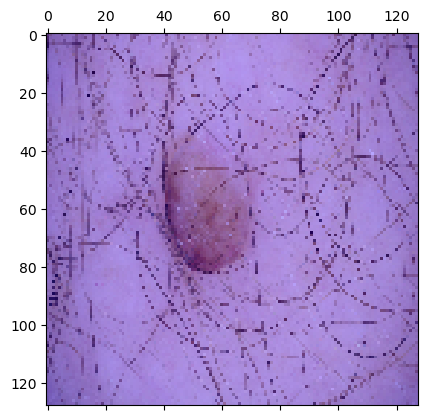

In [165]:
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1, axis=-1)

heatmap =np.maximum(heatmap, 0)/np.max(heatmap) #정규화
#plt.imshow(heatmap)

#열지도를 입력 영상에 씌움
img = image.load_img(r"D:\Data\Final_Project\ISIC_0052060.jpg", target_size = (128,128)) #입력 영상을 다시 받음

img= image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환

jet = cm.get_cmap("jet") #jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]

color_heatmap = image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
color_heatmap = image.img_to_array(color_heatmap)

overlay_img= color_heatmap*0.4+img #덧씌움
overlay_img = image.array_to_img(overlay_img)
plt.matshow(overlay_img)